In [24]:
from tslearn.clustering import TimeSeriesKMeans
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

from sklearn.metrics import davies_bouldin_score
from sklearn.utils import check_random_state
from sklearn.utils import check_X_y
from sklearn.utils import _safe_indexing
from sklearn.metrics.pairwise import pairwise_distances_chunked
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder


In [25]:
def check_number_of_labels(n_labels, n_samples):
    """Check that number of labels are valid.

    Parameters
    ----------
    n_labels : int
        Number of labels.

    n_samples : int
        Number of samples.
    """
    if not 1 < n_labels < n_samples:
        raise ValueError(
            "Number of labels is %d. Valid values are 2 to n_samples - 1 (inclusive)"
            % n_labels
        )

def davies_bouldin_score(X, labels,centroids):
    """Compute the Davies-Bouldin score.

    The score is defined as the average similarity measure of each cluster with
    its most similar cluster, where similarity is the ratio of within-cluster
    distances to between-cluster distances. Thus, clusters which are farther
    apart and less dispersed will result in a better score.

    The minimum score is zero, with lower values indicating better clustering.

    Read more in the :ref:`User Guide <davies-bouldin_index>`.

    .. versionadded:: 0.20

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        A list of ``n_features``-dimensional data points. Each row corresponds
        to a single data point.

    labels : array-like of shape (n_samples,)
        Predicted labels for each sample.

    Returns
    -------
    score: float
        The resulting Davies-Bouldin score.

    References
    ----------
    .. [1] Davies, David L.; Bouldin, Donald W. (1979).
       `"A Cluster Separation Measure"
       <https://ieeexplore.ieee.org/document/4766909>`__.
       IEEE Transactions on Pattern Analysis and Machine Intelligence.
       PAMI-1 (2): 224-227
    """
    X, labels = check_X_y(X, labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    n_samples, _ = X.shape
    n_labels = len(le.classes_)
    check_number_of_labels(n_labels, n_samples)

    intra_dists = np.zeros(n_labels,dtype=np.longdouble)
    for k in range(n_labels):
        cluster_k = _safe_indexing(X, labels == k)
        intra_dists[k] = np.average(pairwise_distances(cluster_k, [centroids[k]]))
    
    centroid_distances = pairwise_distances(centroids)
    

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0
    
    for k in range(n_labels):
        centroid_distances[k,k] = np.inf
        
    combined_intra_dists = intra_dists[:, None] + intra_dists
    scores = np.max(combined_intra_dists / centroid_distances, axis=1)
    return np.mean(scores)


In [26]:
centroids_3 = []
centroids_4 = []
centroids_6 = []

kmeans_3 = []
kmeans_4 = []
kmeans_6 = []

with open('./pickles/allPixelNDVIPoly.pickle', 'rb') as handle:
    allPixelNDVIPoly3 = pickle.load(handle)
with open('./pickles/allPixelNDVIPoly4.pickle', 'rb') as handle:
    allPixelNDVIPoly4 = pickle.load(handle)
with open('./pickles/allPixelNDVIPoly6.pickle', 'rb') as handle:
    allPixelNDVIPoly6 = pickle.load(handle)


with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)
with open('./pickles/newResa4.pickle', 'rb') as handle:
    newResa4 = pickle.load(handle)
with open('./pickles/newResa6.pickle', 'rb') as handle:
    newResa6 = pickle.load(handle)



num_cluster = 2

In [27]:
allPixelNDVIPoly3 = allPixelNDVIPoly3[(newResa3<=11000) & (newResa3 >= 4000),:]
newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]

allPixelNDVIPoly4 = allPixelNDVIPoly4[(newResa4<=11000) & (newResa4 >= 4000),:]
newResa4 = newResa4[(newResa4<=11000) & (newResa4 >= 4000)]
print(len(newResa4))

allPixelNDVIPoly6 = allPixelNDVIPoly6[(newResa6<=11000) & (newResa6 >= 4000),:]
newResa6 = newResa6[(newResa6<=11000) & (newResa6 >= 4000)]
print(len(newResa6))

1065
1700


In [28]:
# k-means su tutto l'asse temporale 

km_one3 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one3 = km_one3.fit_predict(allPixelNDVIPoly3)

km_one4 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one4 = km_one4.fit_predict(allPixelNDVIPoly4)

km_one6 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one6 = km_one6.fit_predict(allPixelNDVIPoly6)

In [29]:
print(len(allPixelNDVIPoly3[y_pred_one3 == 0][0]))
print(len(km_one3.cluster_centers_[0].ravel()))
print(np.linalg.norm(allPixelNDVIPoly3[y_pred_one3 == 0][0] - km_one3.cluster_centers_[0].ravel()))
print(dist.euclidean(allPixelNDVIPoly3[y_pred_one3 == 0][0],km_one3.cluster_centers_[0].ravel()))

150
150
1.4875373563042251
1.4875373563042251


In [30]:
distancefromC = []
centroids = []
for cluster in range(0,num_cluster):
    
    #
    ClusterTs = allPixelNDVIPoly3[y_pred_one3 == cluster]
    centroids = np.tile(km_one3.cluster_centers_[cluster].ravel(),(ClusterTs.shape[0],1))
    distancefromC.append(np.linalg.norm(ClusterTs - centroids,axis=1))

In [31]:
print(len(distancefromC[0]),len(distancefromC[1]))

533 938


# Coesione del TS

In [32]:
for cluster in range(0,num_cluster):
    print("cluster"+str(cluster))
    print(np.array(distancefromC[cluster]).mean())
    print(np.array(distancefromC[cluster]).std())



cluster0
0.3983831975975734
0.23879895848444946
cluster1
0.2829296657076909
0.10894201014921998


# Davies–Bouldin index

In [33]:
#Rese 3 
centroids = []
for cluster in range(0,num_cluster):
    centroids.append(km_one3.cluster_centers_[cluster].ravel())
centroids = np.array(centroids)
print("indice dv del campo",3)
print(davies_bouldin_score(allPixelNDVIPoly3,y_pred_one3,centroids))

#Resa 4
centroids = []
for cluster in range(0,num_cluster):
    centroids.append(km_one4.cluster_centers_[cluster].ravel())
centroids = np.array(centroids)
print("indice dv del campo",4)
print(davies_bouldin_score(allPixelNDVIPoly4,y_pred_one4,centroids))

#Resa 6
centroids = []
for cluster in range(0,num_cluster):
    centroids.append(km_one6.cluster_centers_[cluster].ravel())
centroids = np.array(centroids)
print("indice dv del campo",6)
print(davies_bouldin_score(allPixelNDVIPoly6,y_pred_one6,centroids))

indice dv del campo 3
0.918215574520606
indice dv del campo 4
0.695955169397742
indice dv del campo 6
0.3561120797190379


# Andiamo a utilizzare le metriche su tutti i cluster delle varie curve

In [34]:
for i in range(2,7):
    with open('./pickles/kluster_centroids_3_c'+str(i)+'.pickle', 'rb') as handle:
        centroids_3.append(pickle.load(handle))
    with open('./pickles/kluster_centroids_4_c'+str(i)+'.pickle', 'rb') as handle:
        centroids_4.append(pickle.load(handle))
    with open('./pickles/kluster_centroids_6_c'+str(i)+'.pickle', 'rb') as handle:
        centroids_6.append(pickle.load(handle))

    with open('./pickles/kmeans_total_3_c'+str(i)+'.pickle', 'rb') as handle:
        kmeans_3.append(pickle.load(handle))
    with open('./pickles/kmeans_total_4_c'+str(i)+'.pickle', 'rb') as handle:
        kmeans_4.append(pickle.load(handle))
    with open('./pickles/kmeans_total_6_c'+str(i)+'.pickle', 'rb') as handle:
        kmeans_6.append(pickle.load(handle))

with open('./pickles/newSeries_total_3.pickle', 'rb') as handle:
    newSeries_total_3 = pickle.load(handle)
with open('./pickles/newSeries_total_4.pickle', 'rb') as handle:
    newSeries_total_4 = pickle.load(handle)
with open('./pickles/newSeries_total_6.pickle', 'rb') as handle:
    newSeries_total_6 = pickle.load(handle)

In [35]:
def calculateDistance(NDVIpoly,kmeans_total,centroid,cluster):
    ClusterTs = NDVIpoly[kmeans_total == cluster]
    return np.linalg.norm(ClusterTs - np.tile(centroid,(ClusterTs.shape[0],1)),axis=1)

In [36]:
x,y = 0,24
#print(centroids_3[x,y])
centroid_test = [centroids_3[0][x,y,0],centroids_3[0][x,y,1]]
davies_bouldin_score(newSeries_total_3[x,y],kmeans_3[0][x,y],centroid_test)

0.8588622227752502

In [37]:
kmeans = 5

XMax = 15
YMax = 15


davisBouldin3All = []
davisBouldin4All = []
davisBouldin6All = []
Coesione3All = []
Coesione4All = []
Coesione6All = []
for k in range(0,5):
    davisBouldin3 = np.zeros((XMax,YMax),dtype=np.longdouble)
    davisBouldin4 = np.zeros((XMax,YMax),dtype=np.longdouble)
    davisBouldin6 = np.zeros((XMax,YMax),dtype=np.longdouble)

    coesione_3 = np.zeros((XMax,YMax,k+2))
    coesione_4 = np.zeros((XMax,YMax,k+2))
    coesione_6 = np.zeros((XMax,YMax,k+2))
    for x in range(0,XMax):
        for y in range(0,YMax):
            if(kmeans_3[k][x,y] is not None):
                centroid3 = []
                centroid4 = []
                centroid6 = []
                for cluster in range(0,k+2):

                    centroid3.append(centroids_3[k][x,y,cluster])
                    centroid4.append(centroids_4[k][x,y,cluster])
                    centroid6.append(centroids_6[k][x,y,cluster])


                    #Coesione Cluster (deviazione standard)
                    distancefromC3 = calculateDistance(newSeries_total_3[x,y],kmeans_3[k][x,y],centroids_3[k][x,y,cluster],cluster)
                    distancefromC4 = calculateDistance(newSeries_total_4[x,y],kmeans_4[k][x,y],centroids_4[k][x,y,cluster],cluster)
                    distancefromC6 = calculateDistance(newSeries_total_6[x,y],kmeans_6[k][x,y],centroids_6[k][x,y,cluster],cluster)

                    coesione_3[x,y,cluster] = distancefromC3.std()
                    coesione_4[x,y,cluster] = distancefromC4.std()
                    coesione_6[x,y,cluster] = distancefromC6.std()

                davisBouldin3[x,y] = davies_bouldin_score(newSeries_total_3[x,y],kmeans_3[k][x,y],centroid3)
                davisBouldin4[x,y] = davies_bouldin_score(newSeries_total_4[x,y],kmeans_4[k][x,y],centroid4)
                davisBouldin6[x,y] = davies_bouldin_score(newSeries_total_6[x,y],kmeans_6[k][x,y],centroid6)
            else:
                continue
    Coesione3All.append(coesione_3)
    Coesione4All.append(coesione_4)
    Coesione6All.append(coesione_6)
    
    davisBouldin3All.append(np.copy(davisBouldin3))
    davisBouldin4All.append(np.copy(davisBouldin4))
    davisBouldin6All.append(np.copy(davisBouldin6))
        

# Davis Bouldin

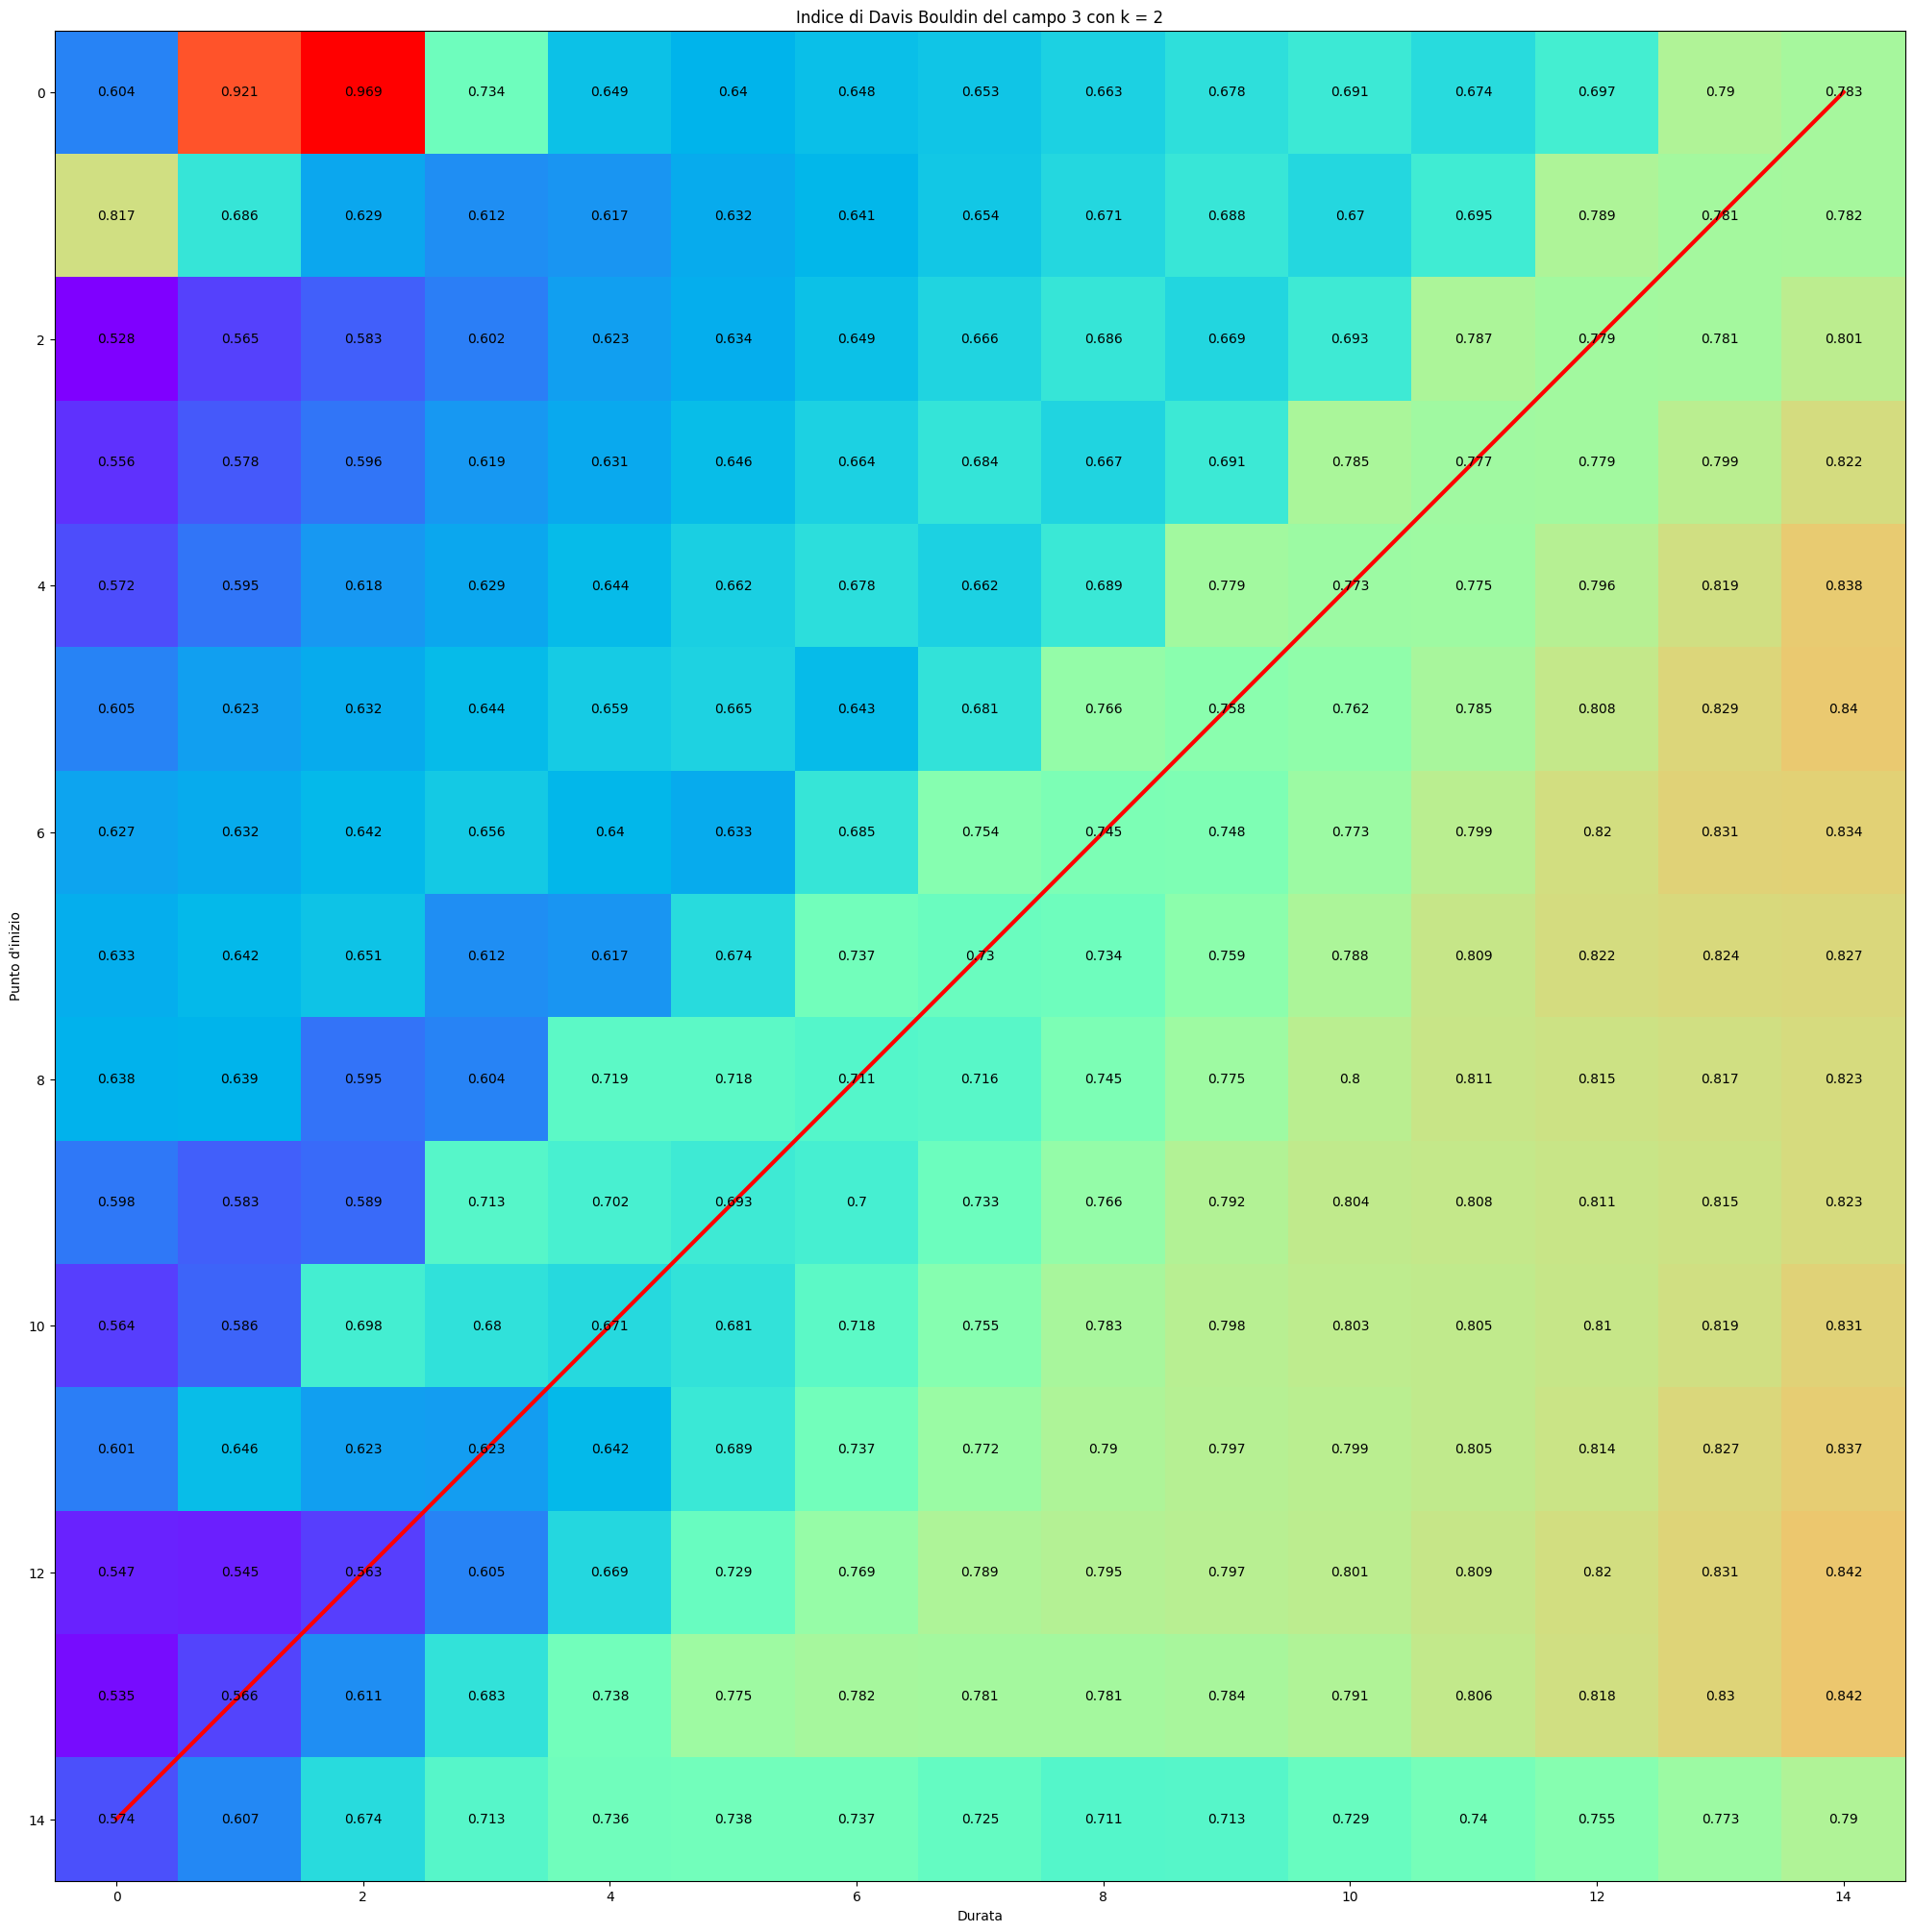

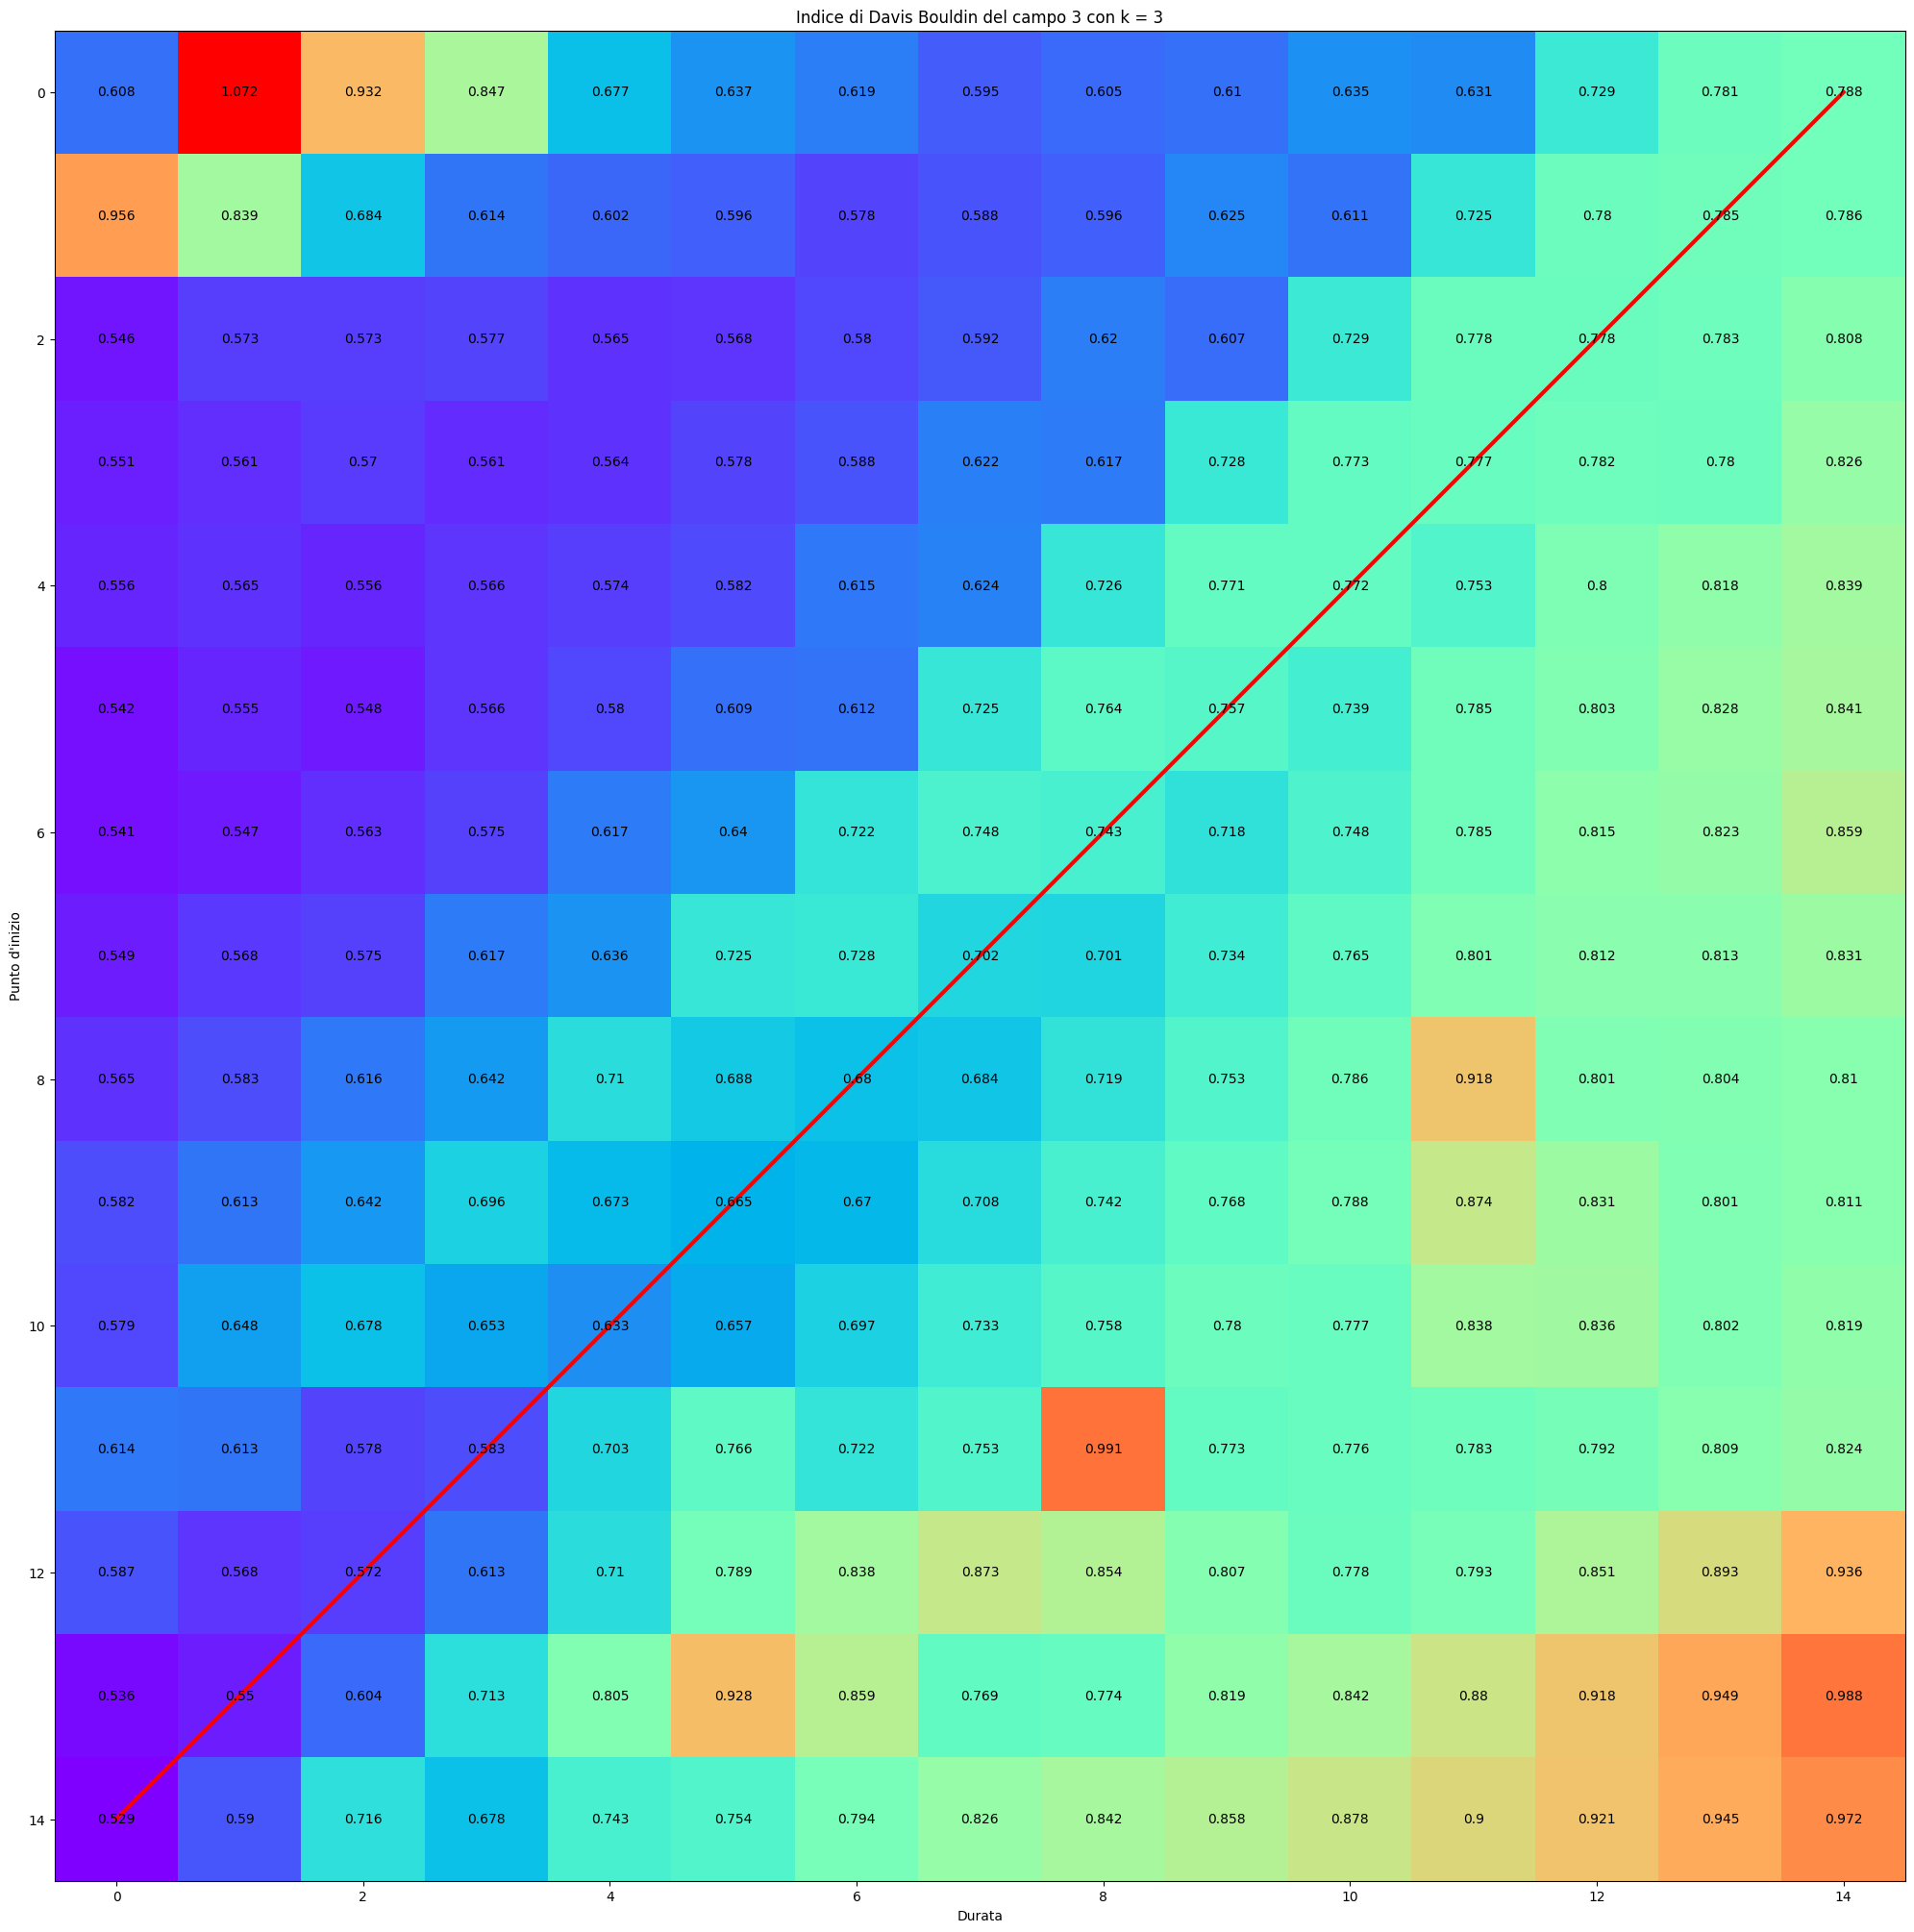

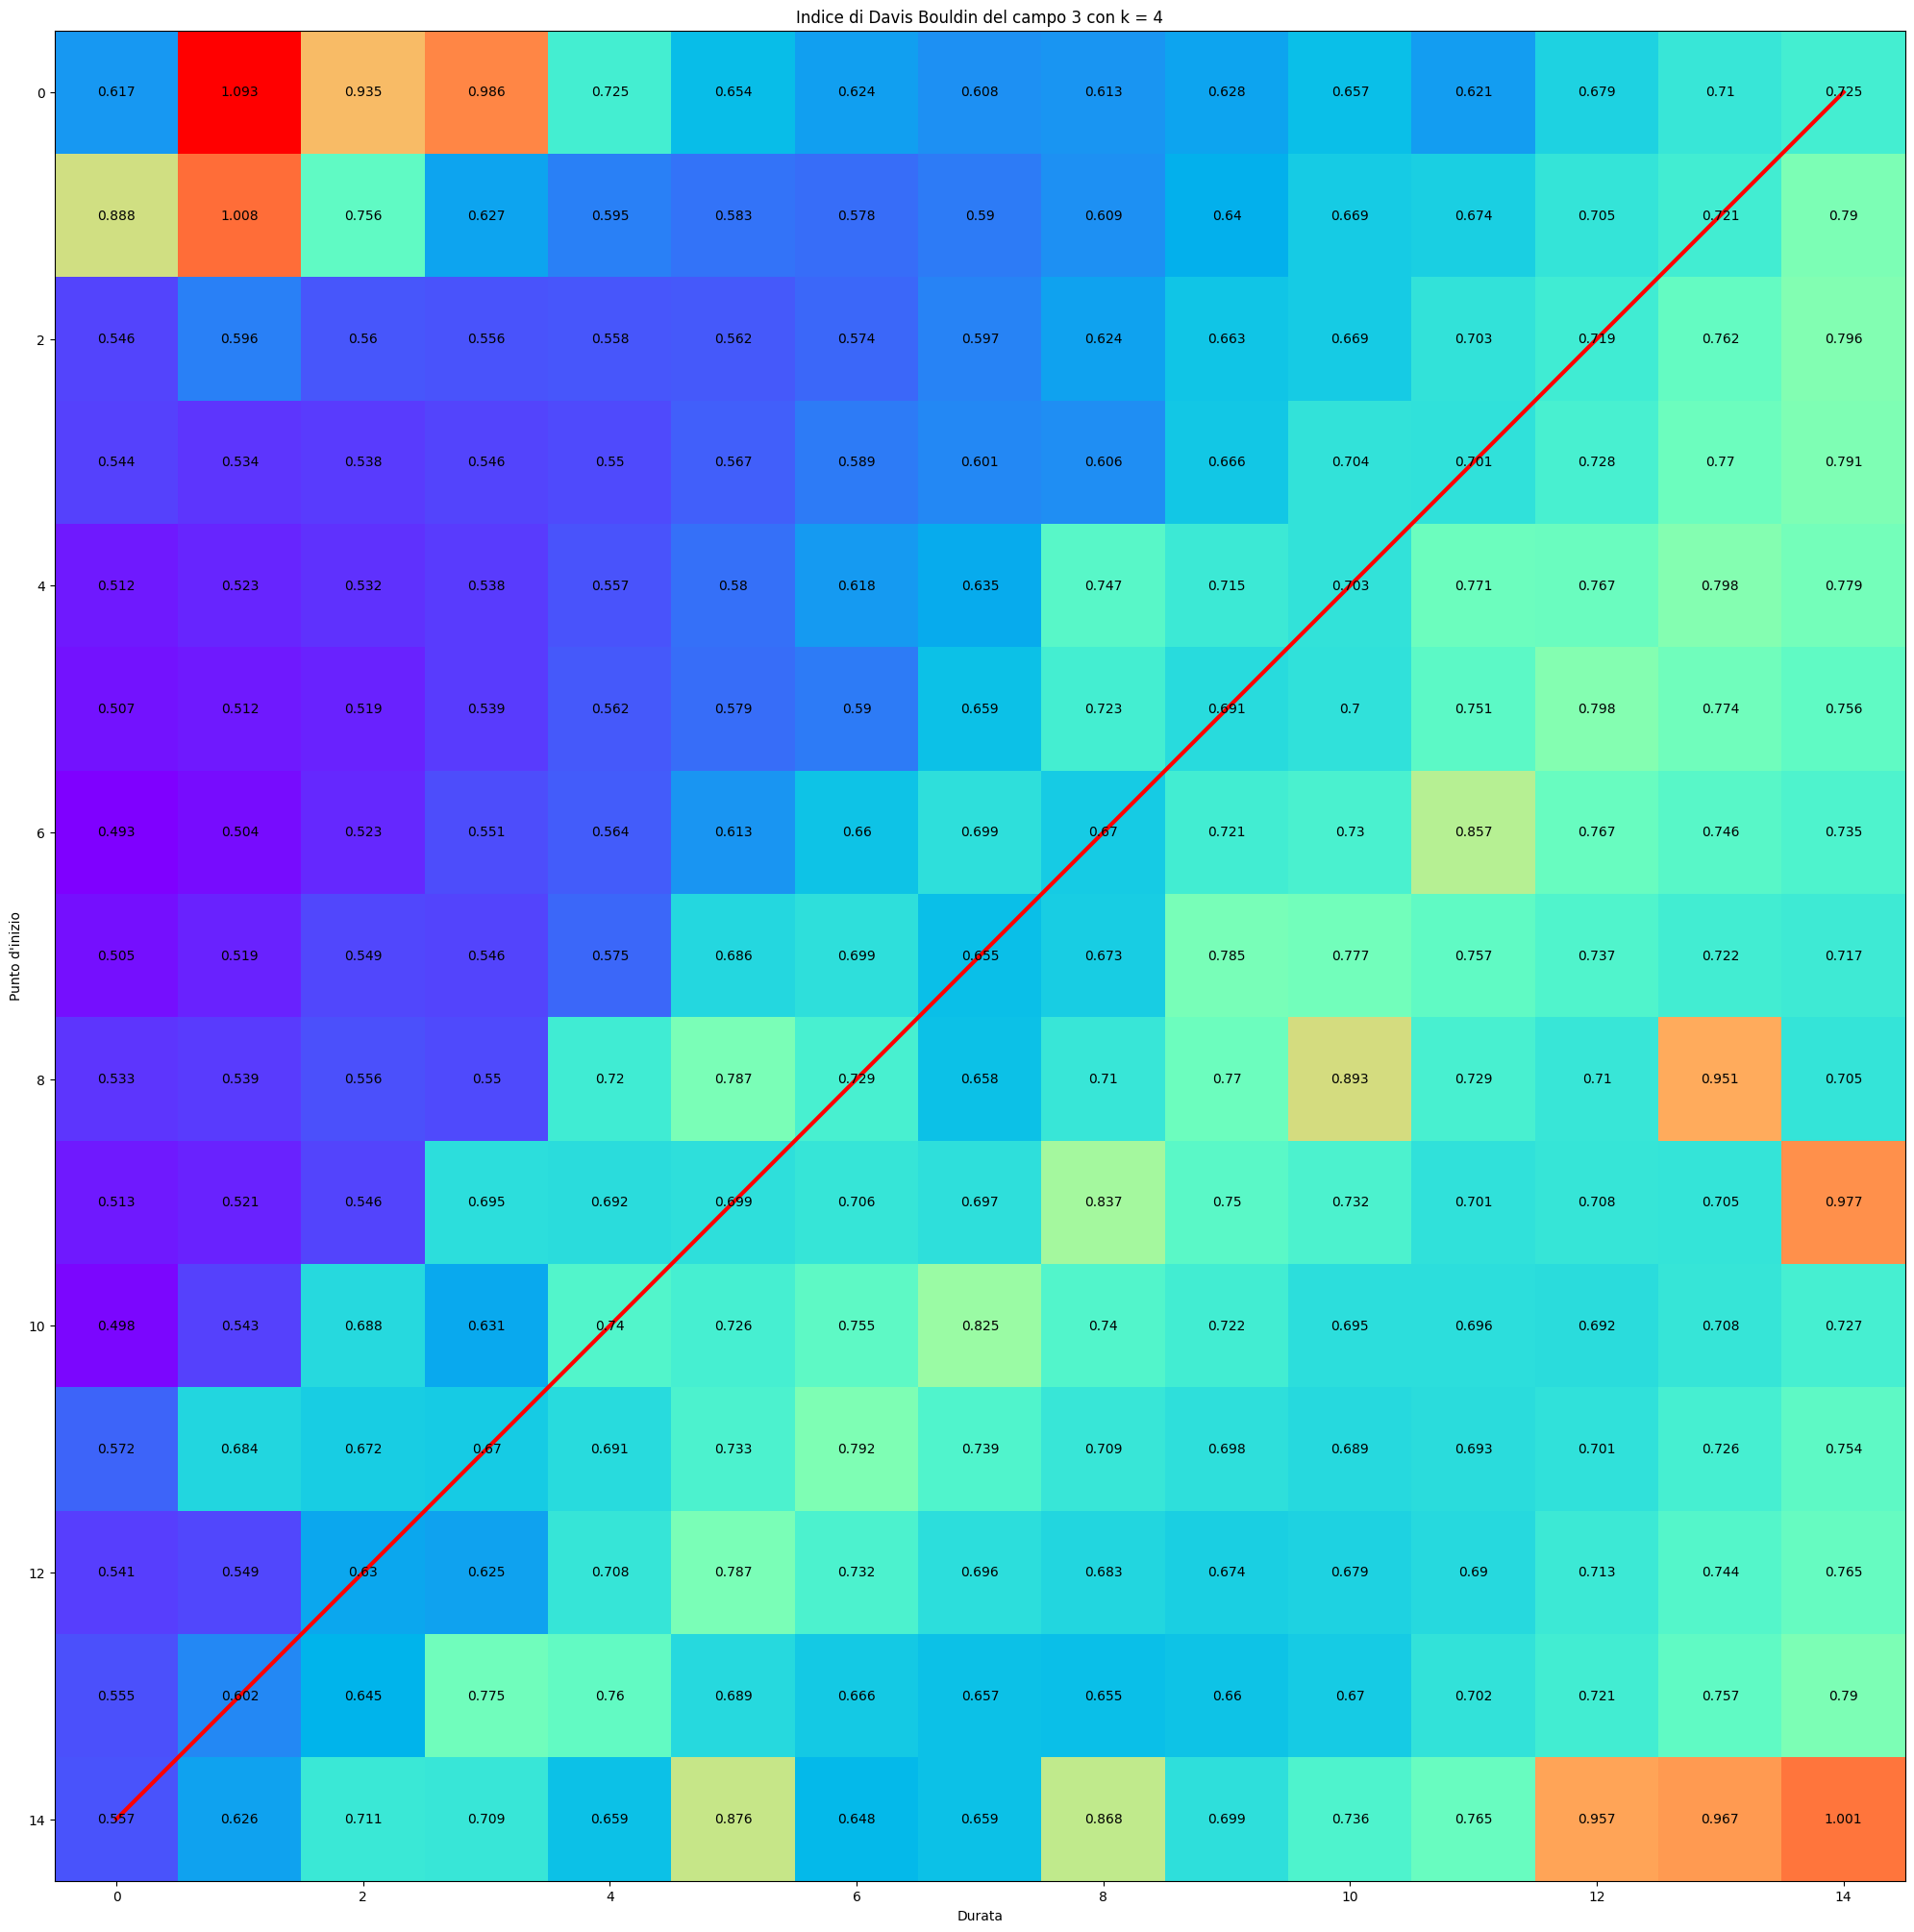

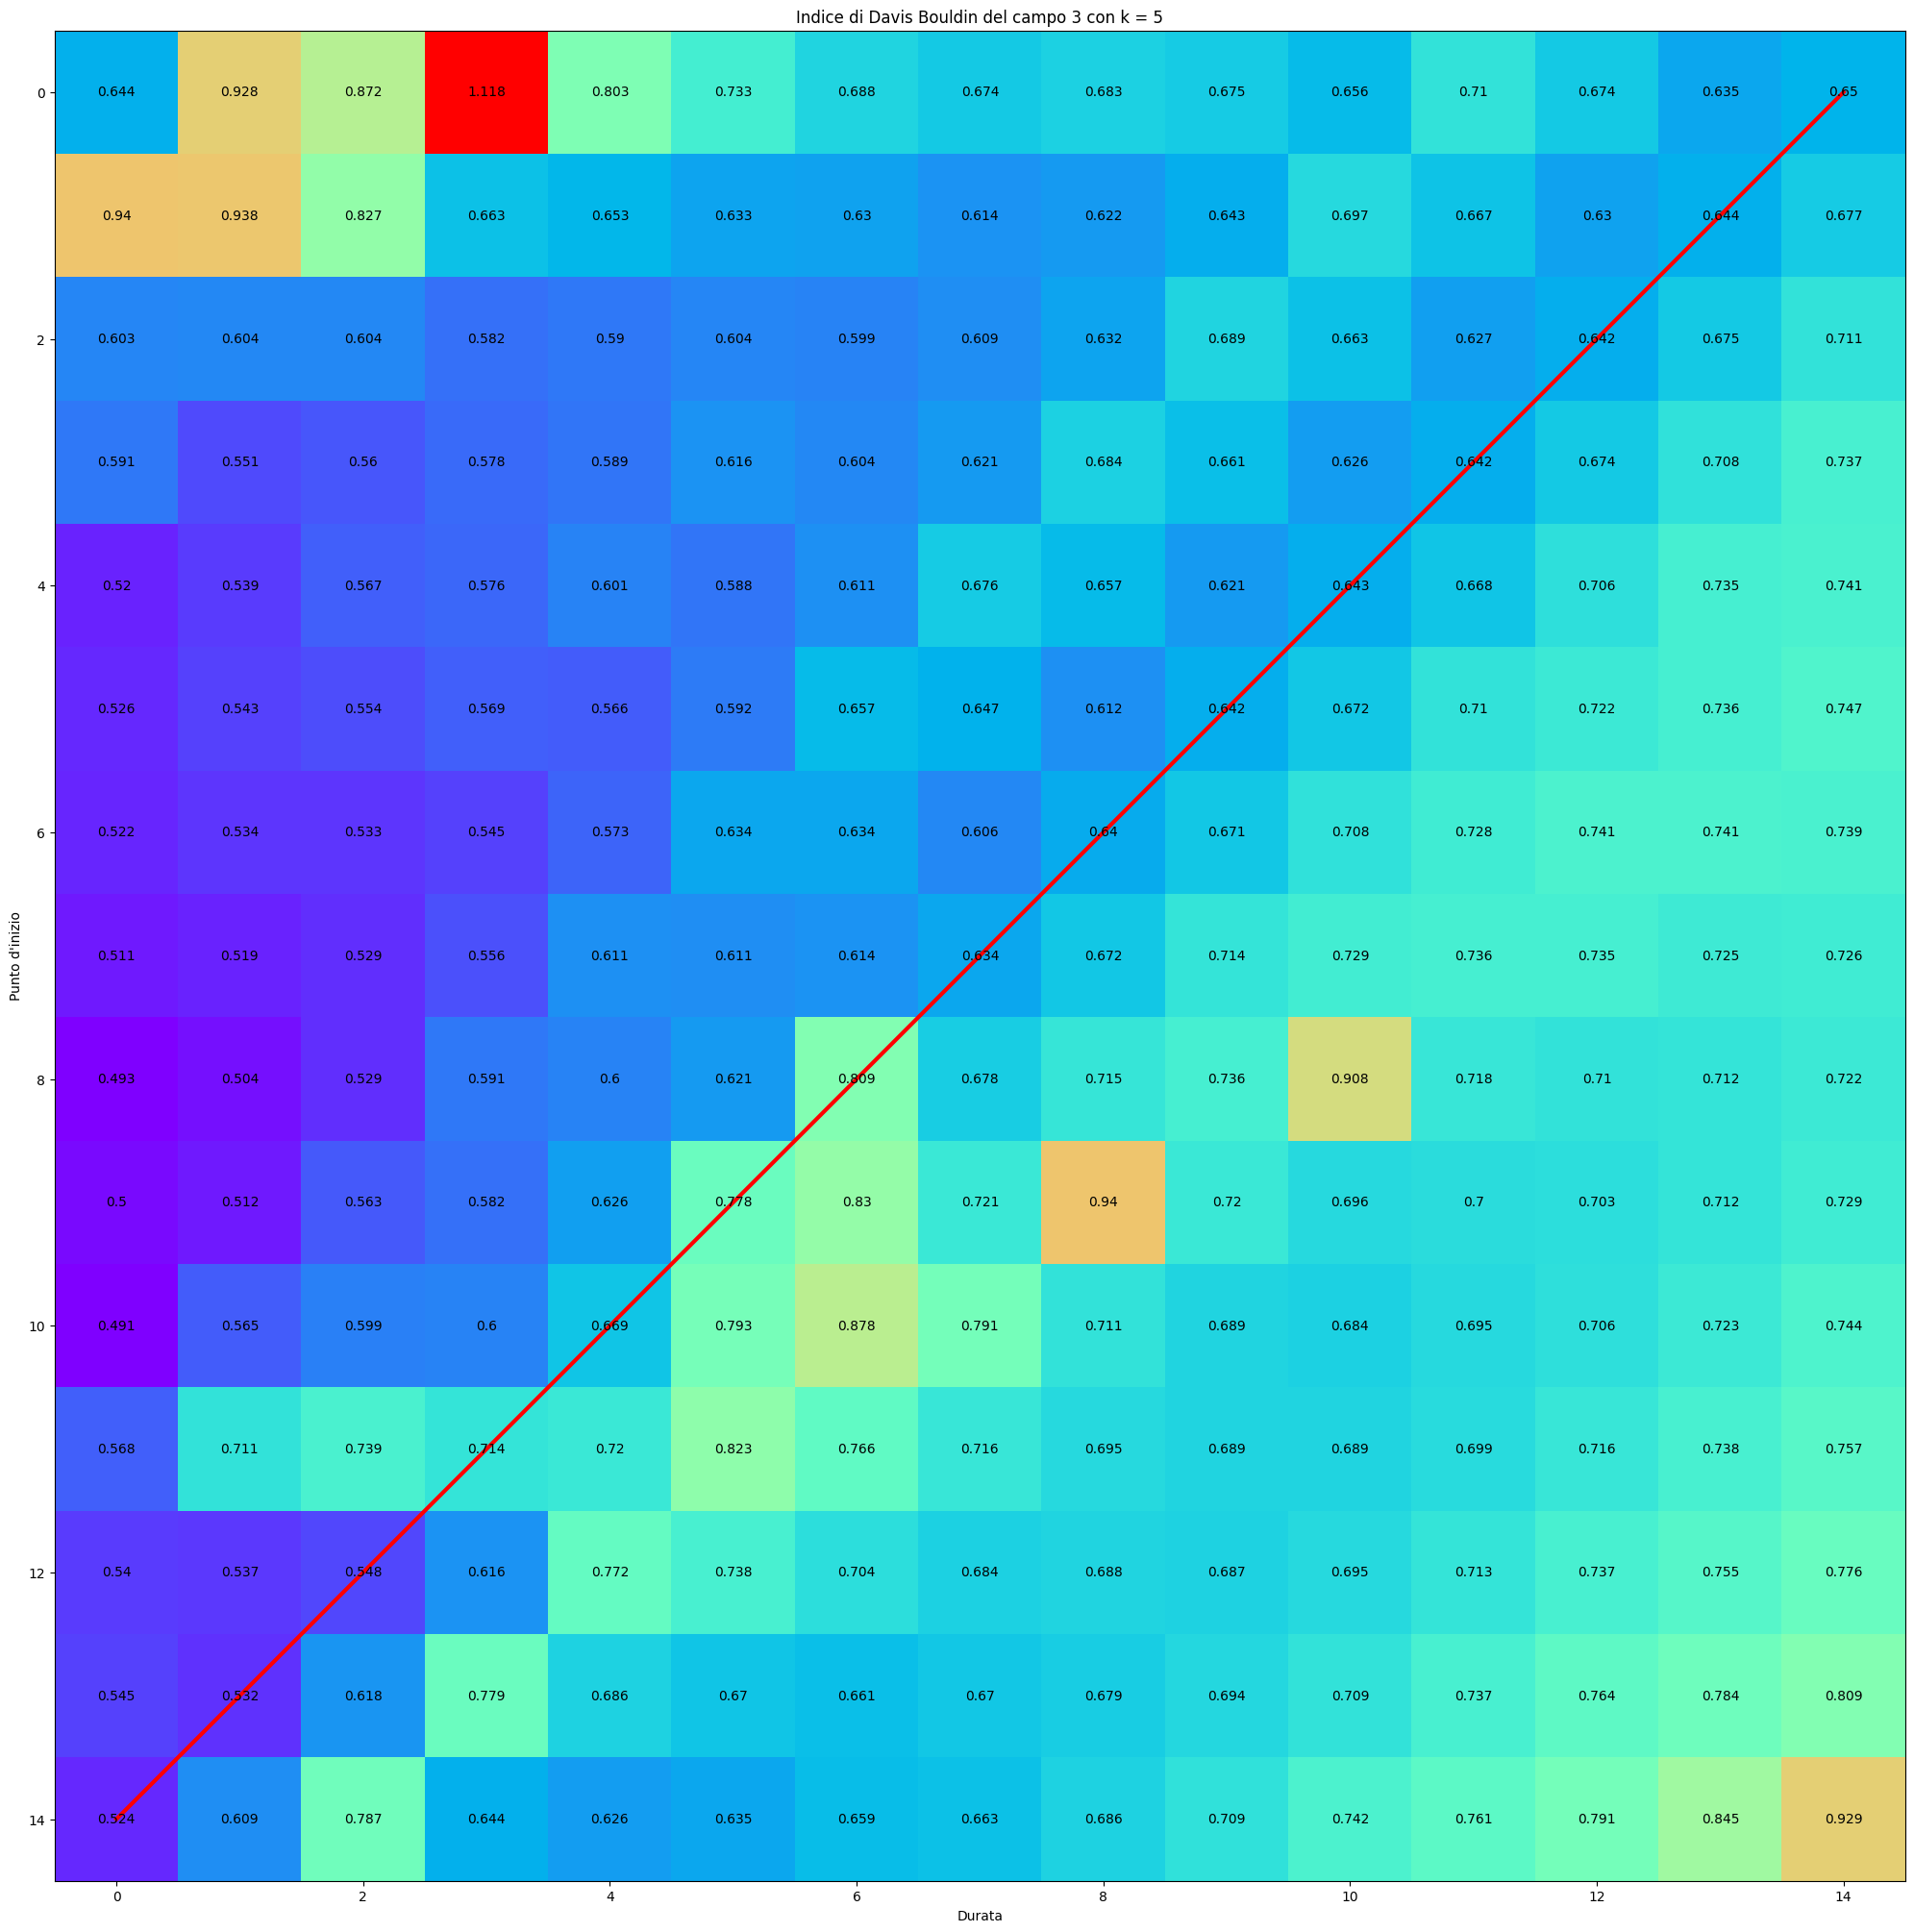

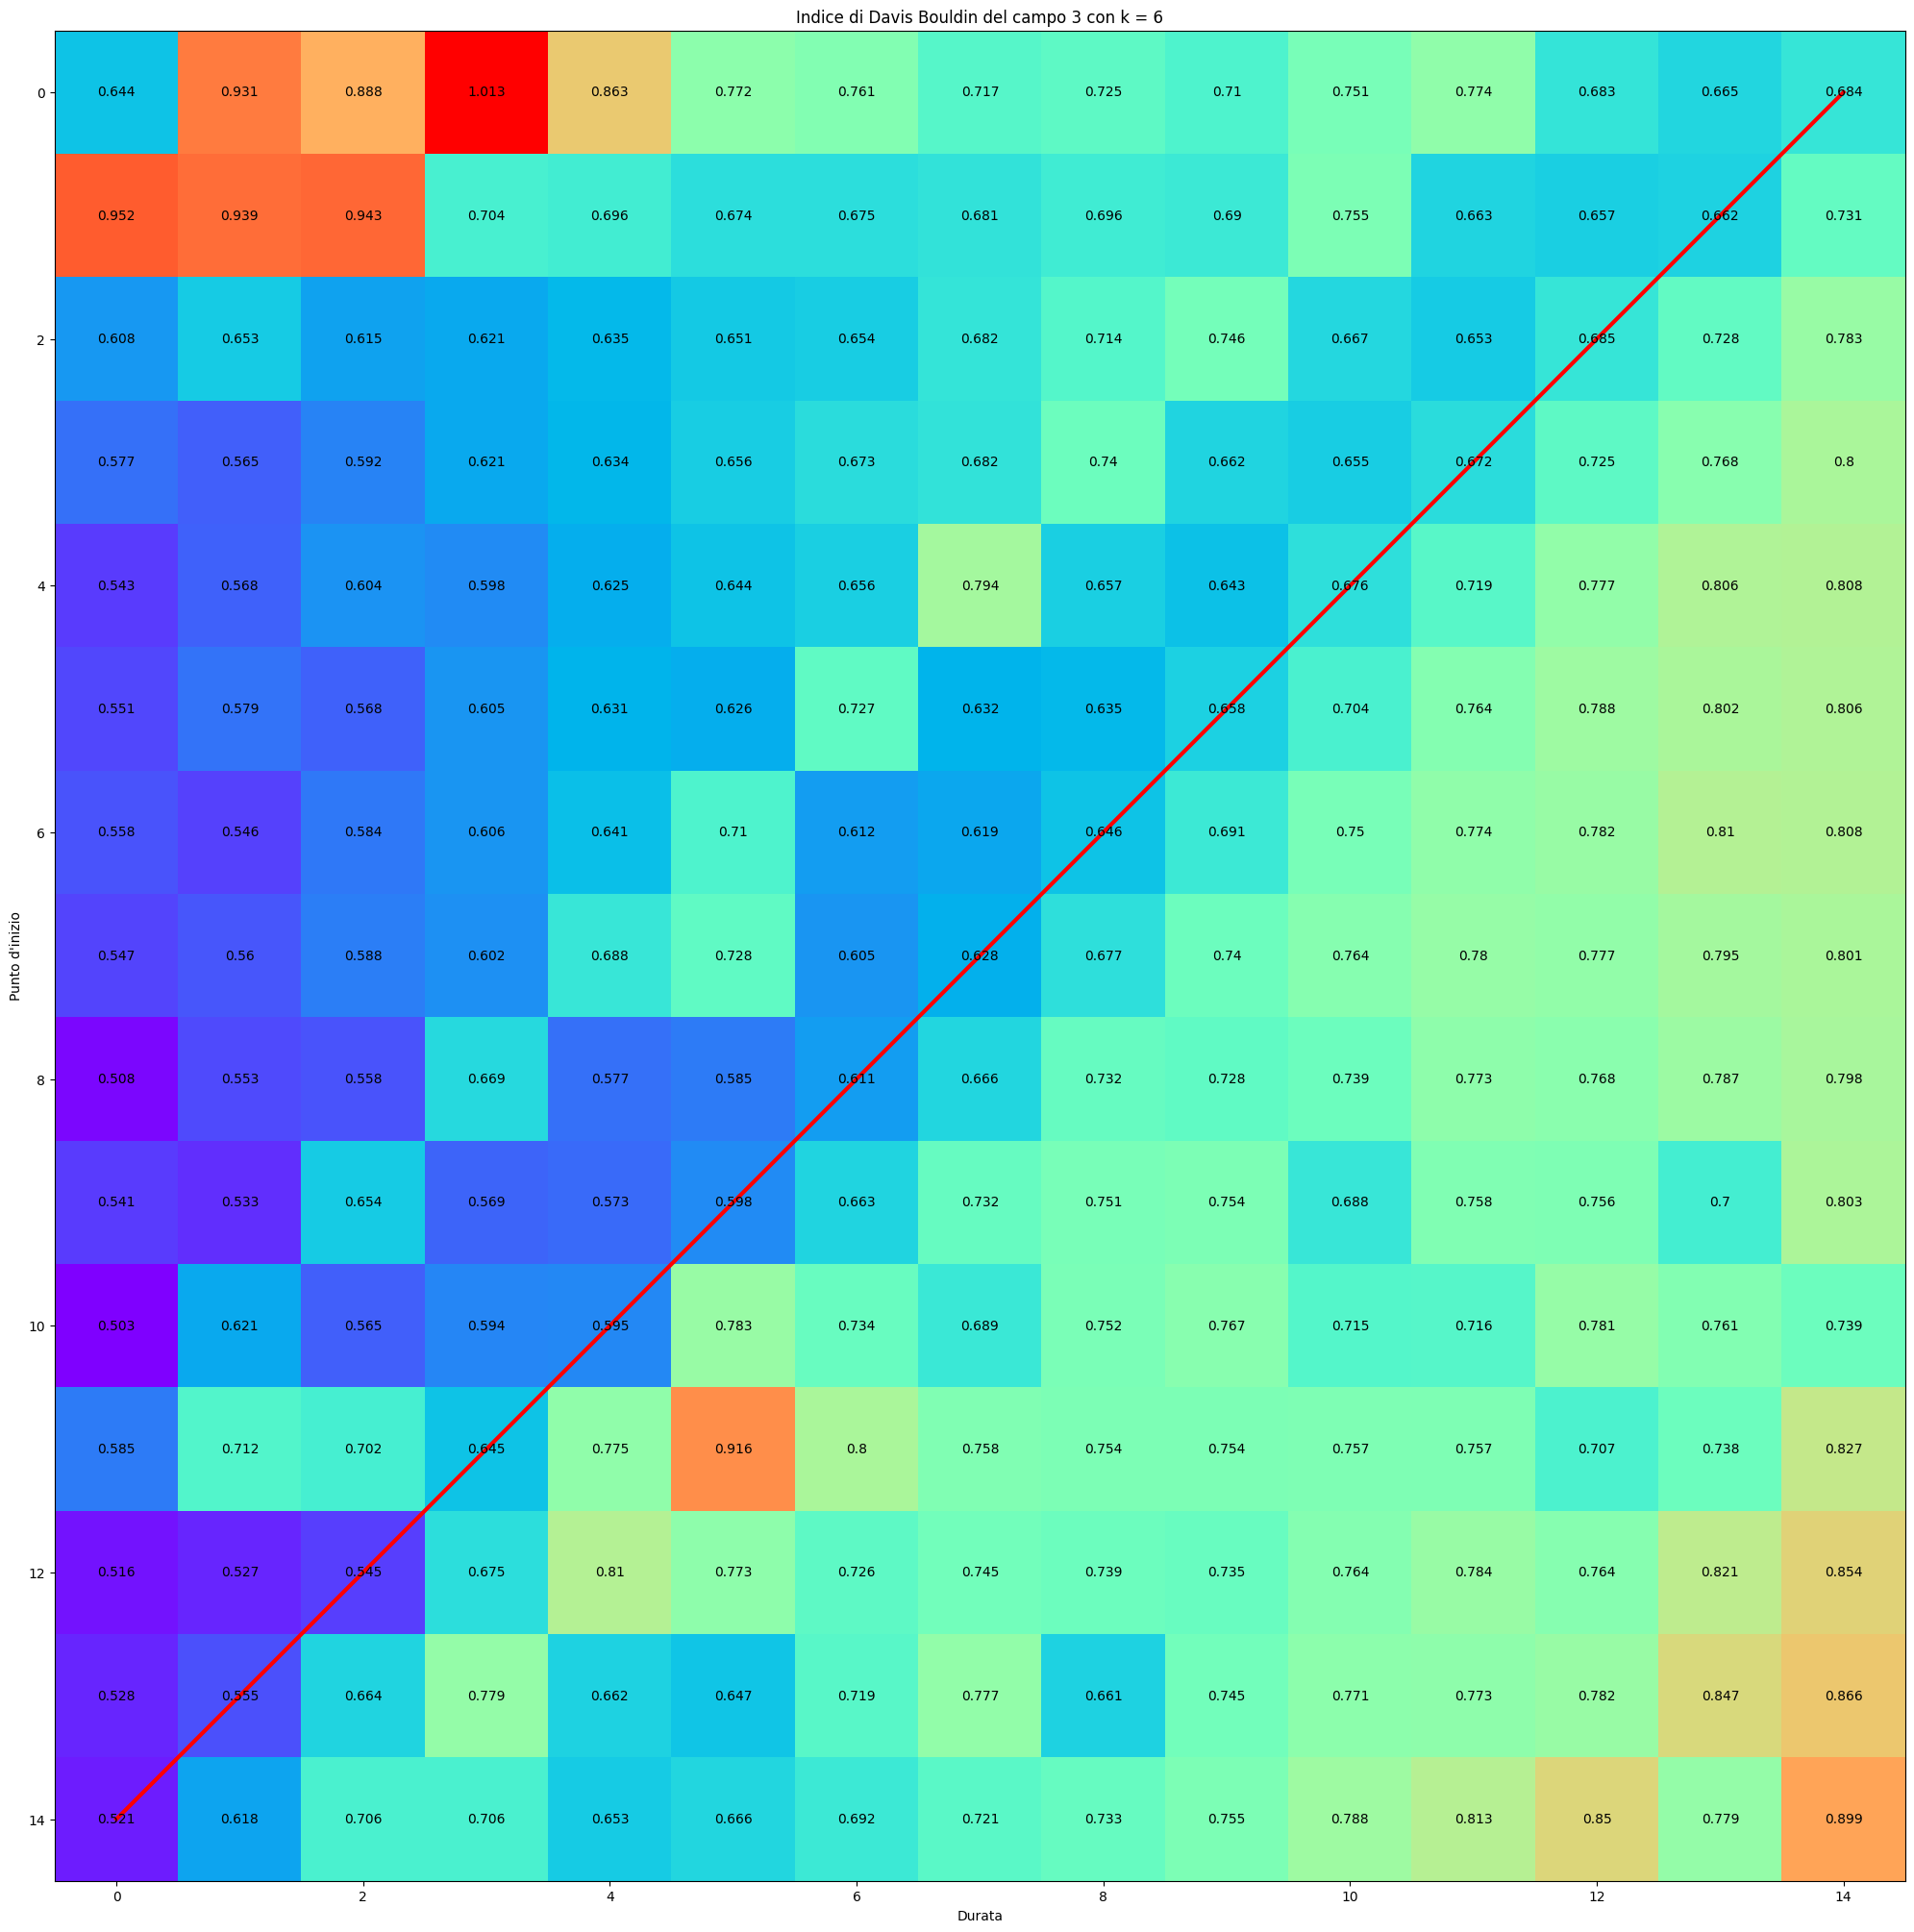

In [38]:
for i in range(0,5):
    Indice = davisBouldin3All[i]
    fig, ax = plt.subplots()
    #Indice[XMax-1,YMax-1] = 0
    image = ax.imshow(Indice[:,:],cmap='rainbow')
    line_start = [0, np.floor(71/5)]
    line_end = [np.floor(71/5), 0]
    plt.plot(line_start, line_end, color="red", linewidth=3)
    plt.title('Indice di Davis Bouldin del campo 3 con k = '+str(i+2))
    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")

    fig.set_size_inches(25,25)
    for i in range(XMax):
        for j in range(YMax):
            c = np.round(Indice[i,j],decimals=3)
            ax.text(j, i, str(c), va='center', ha='center')


    plt.show()

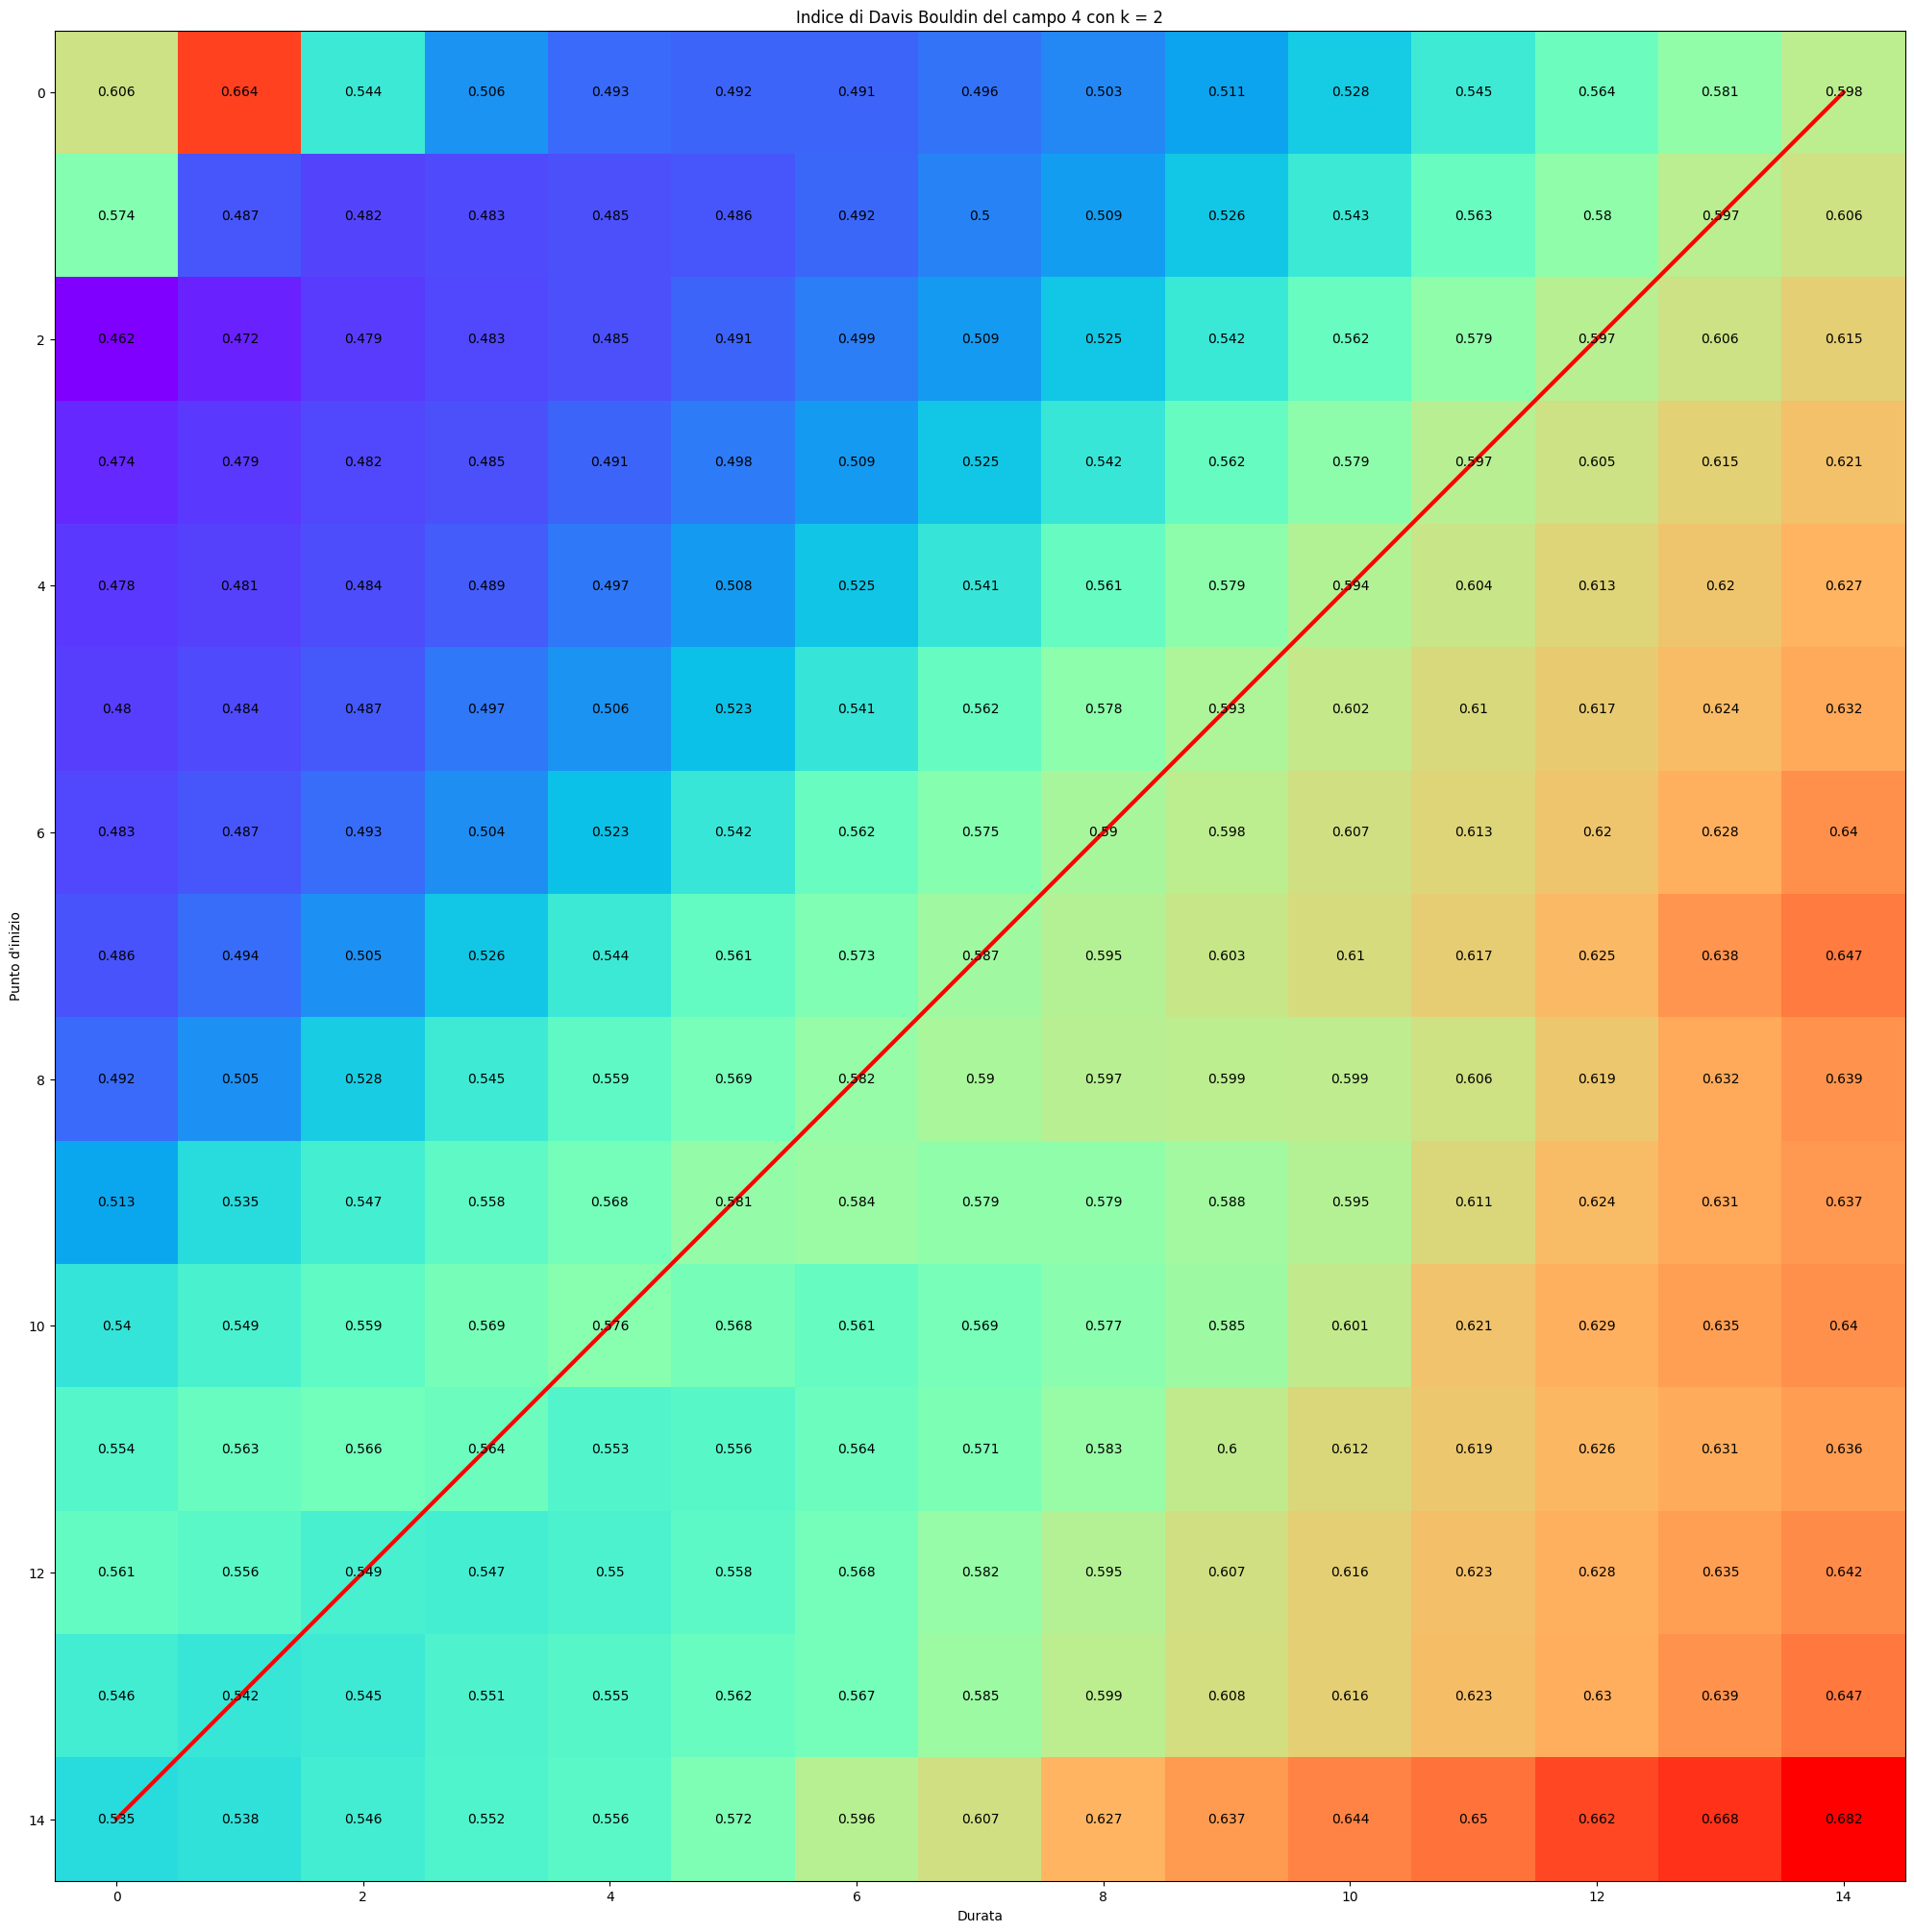

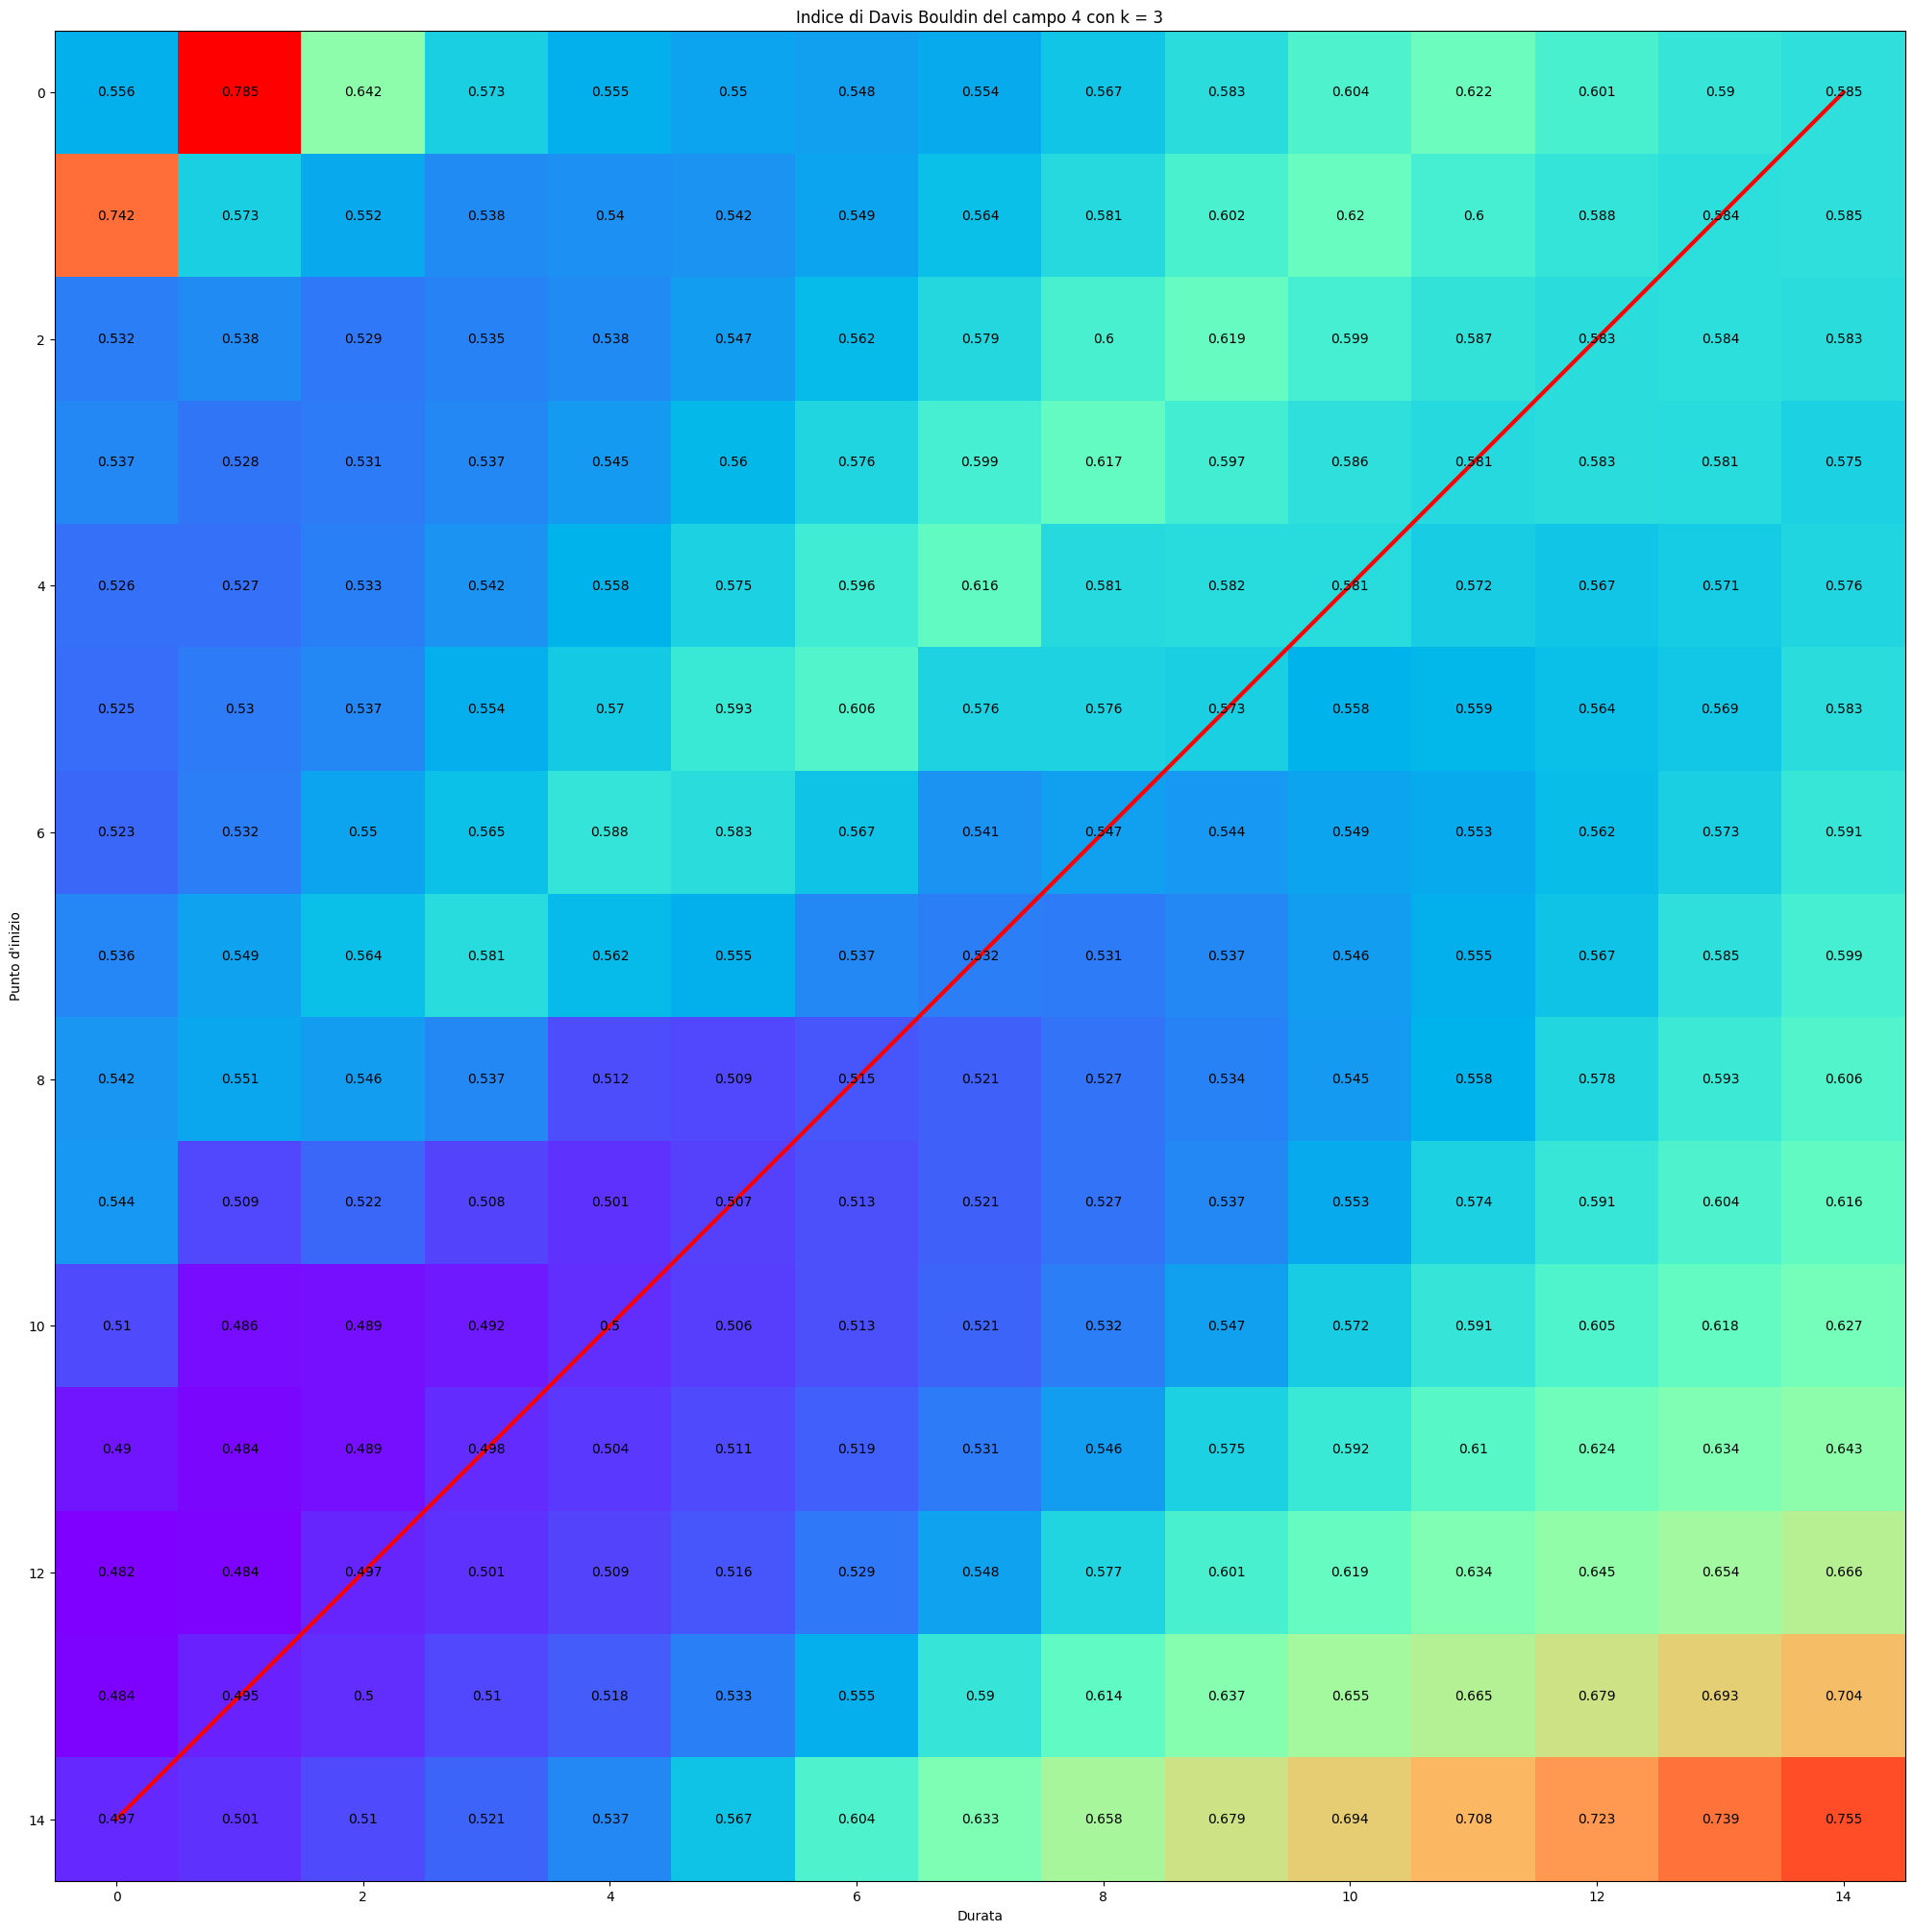

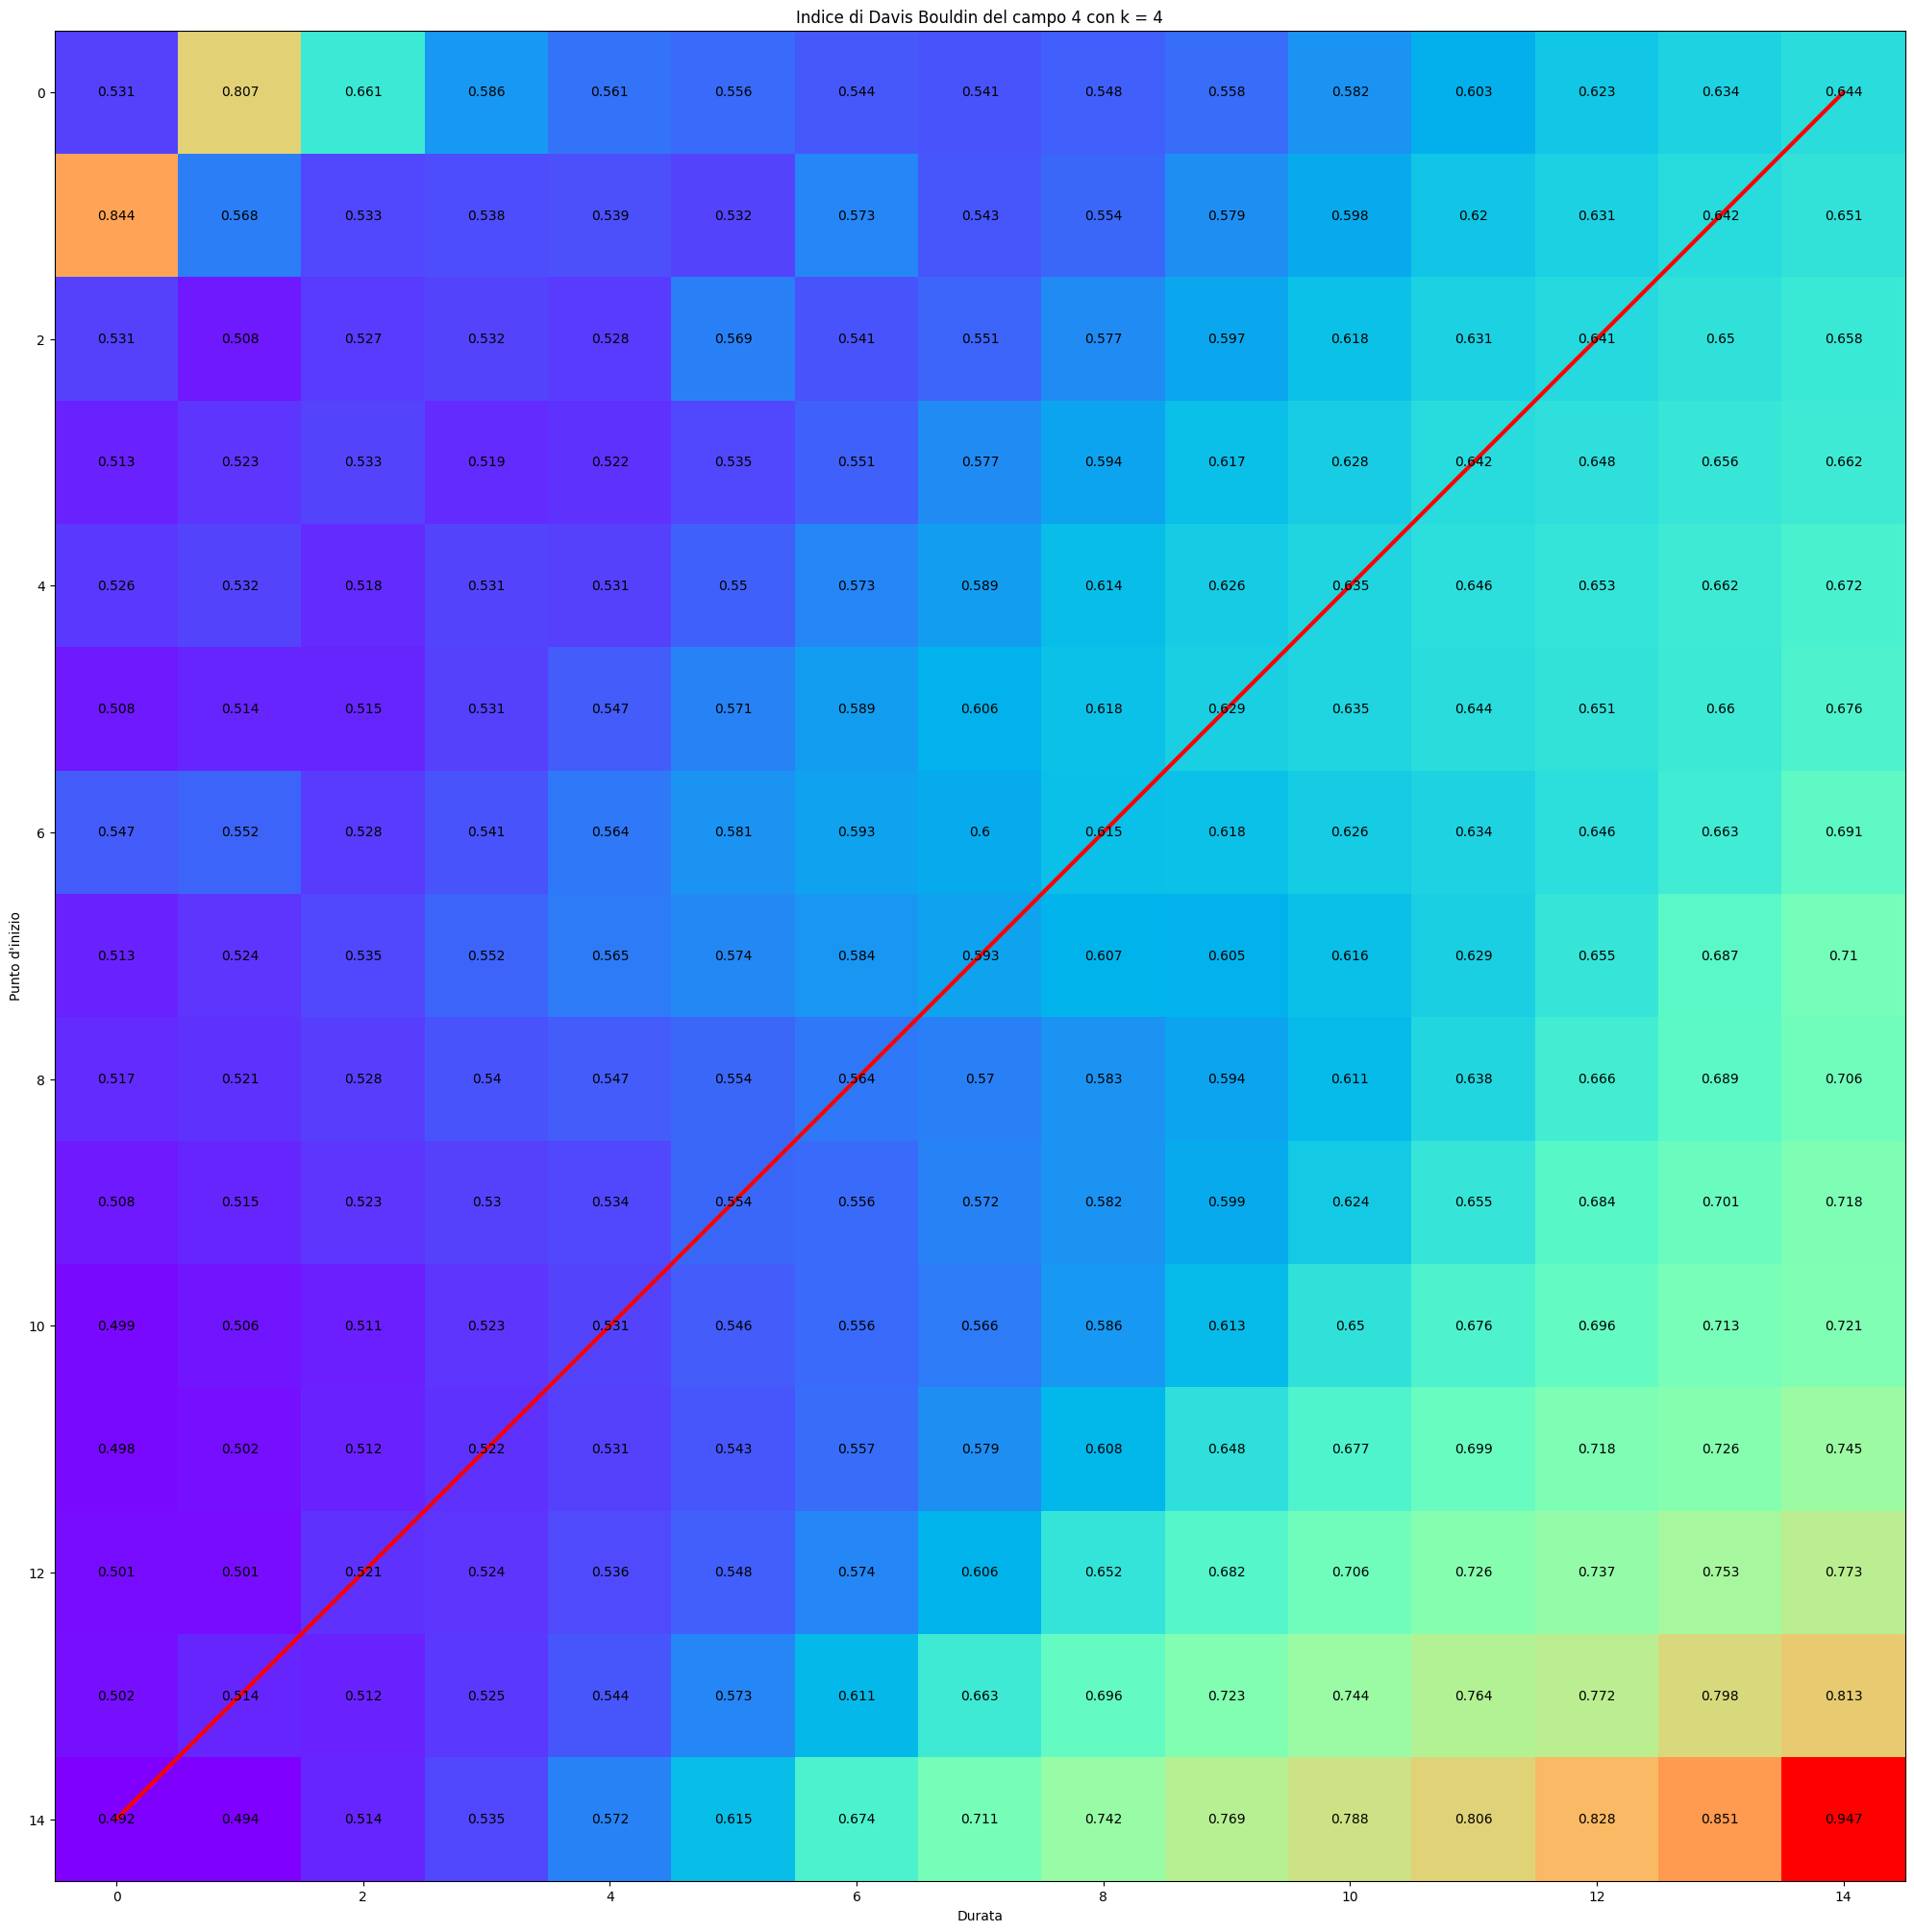

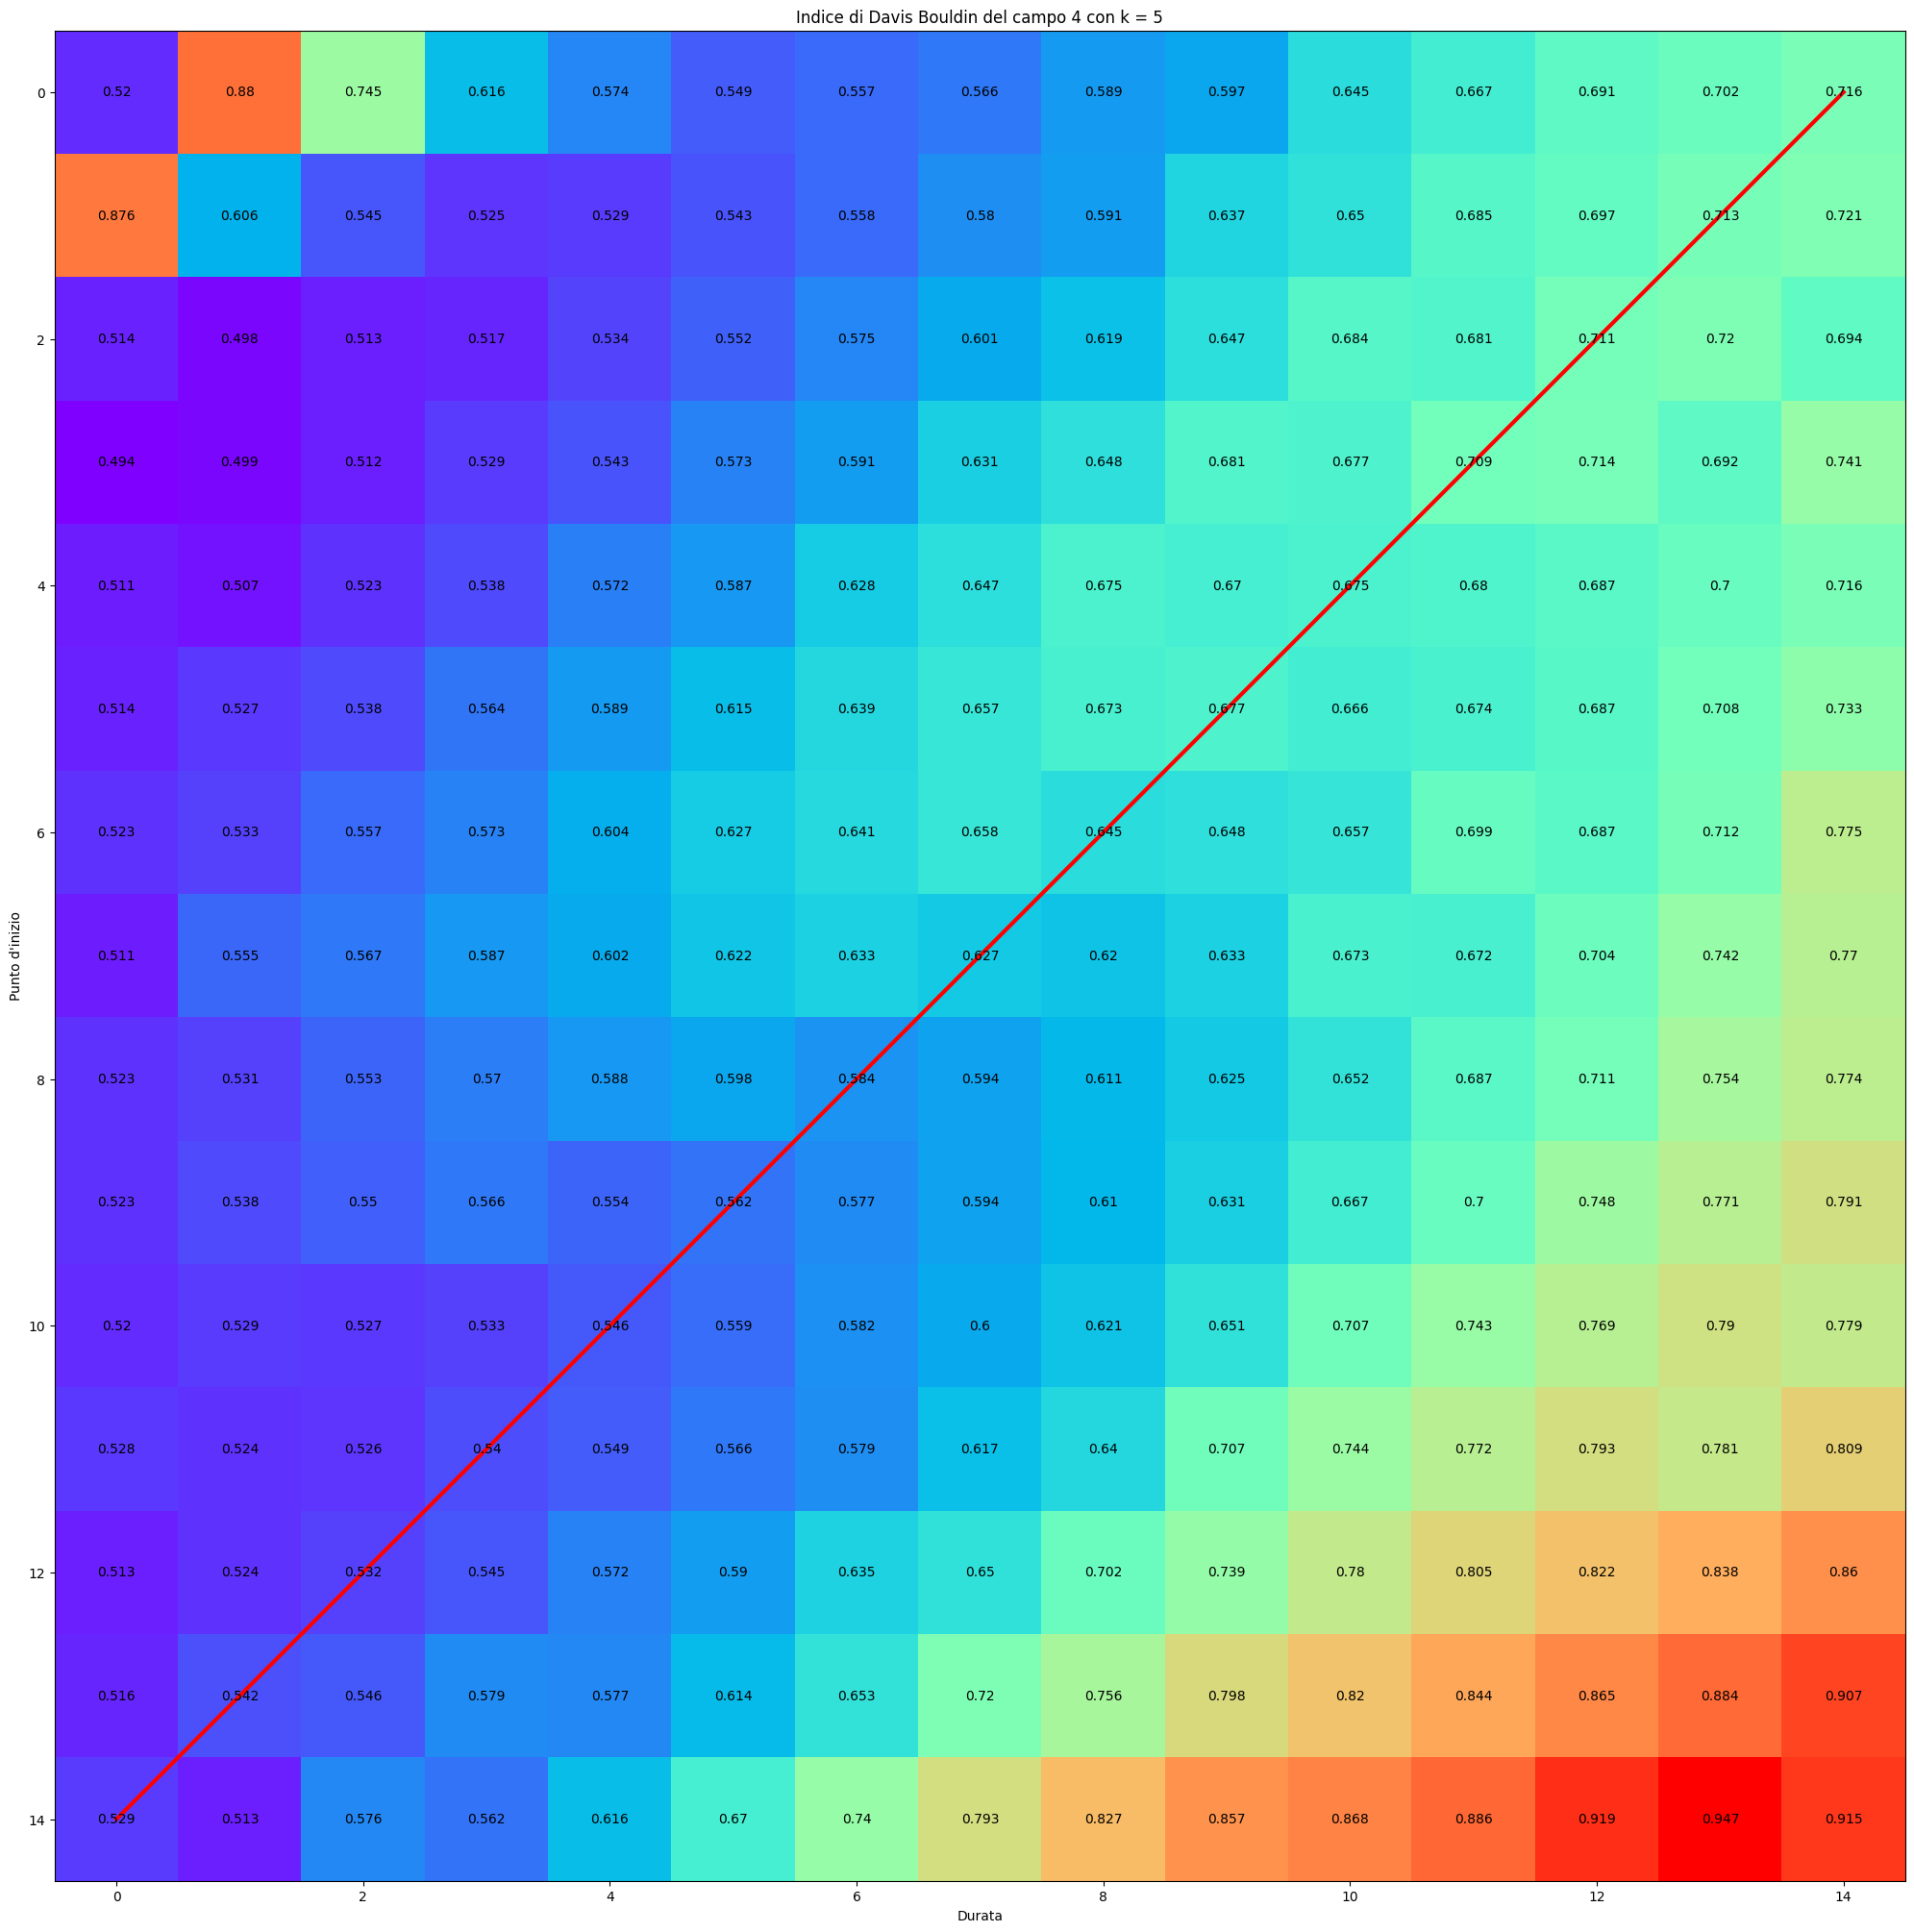

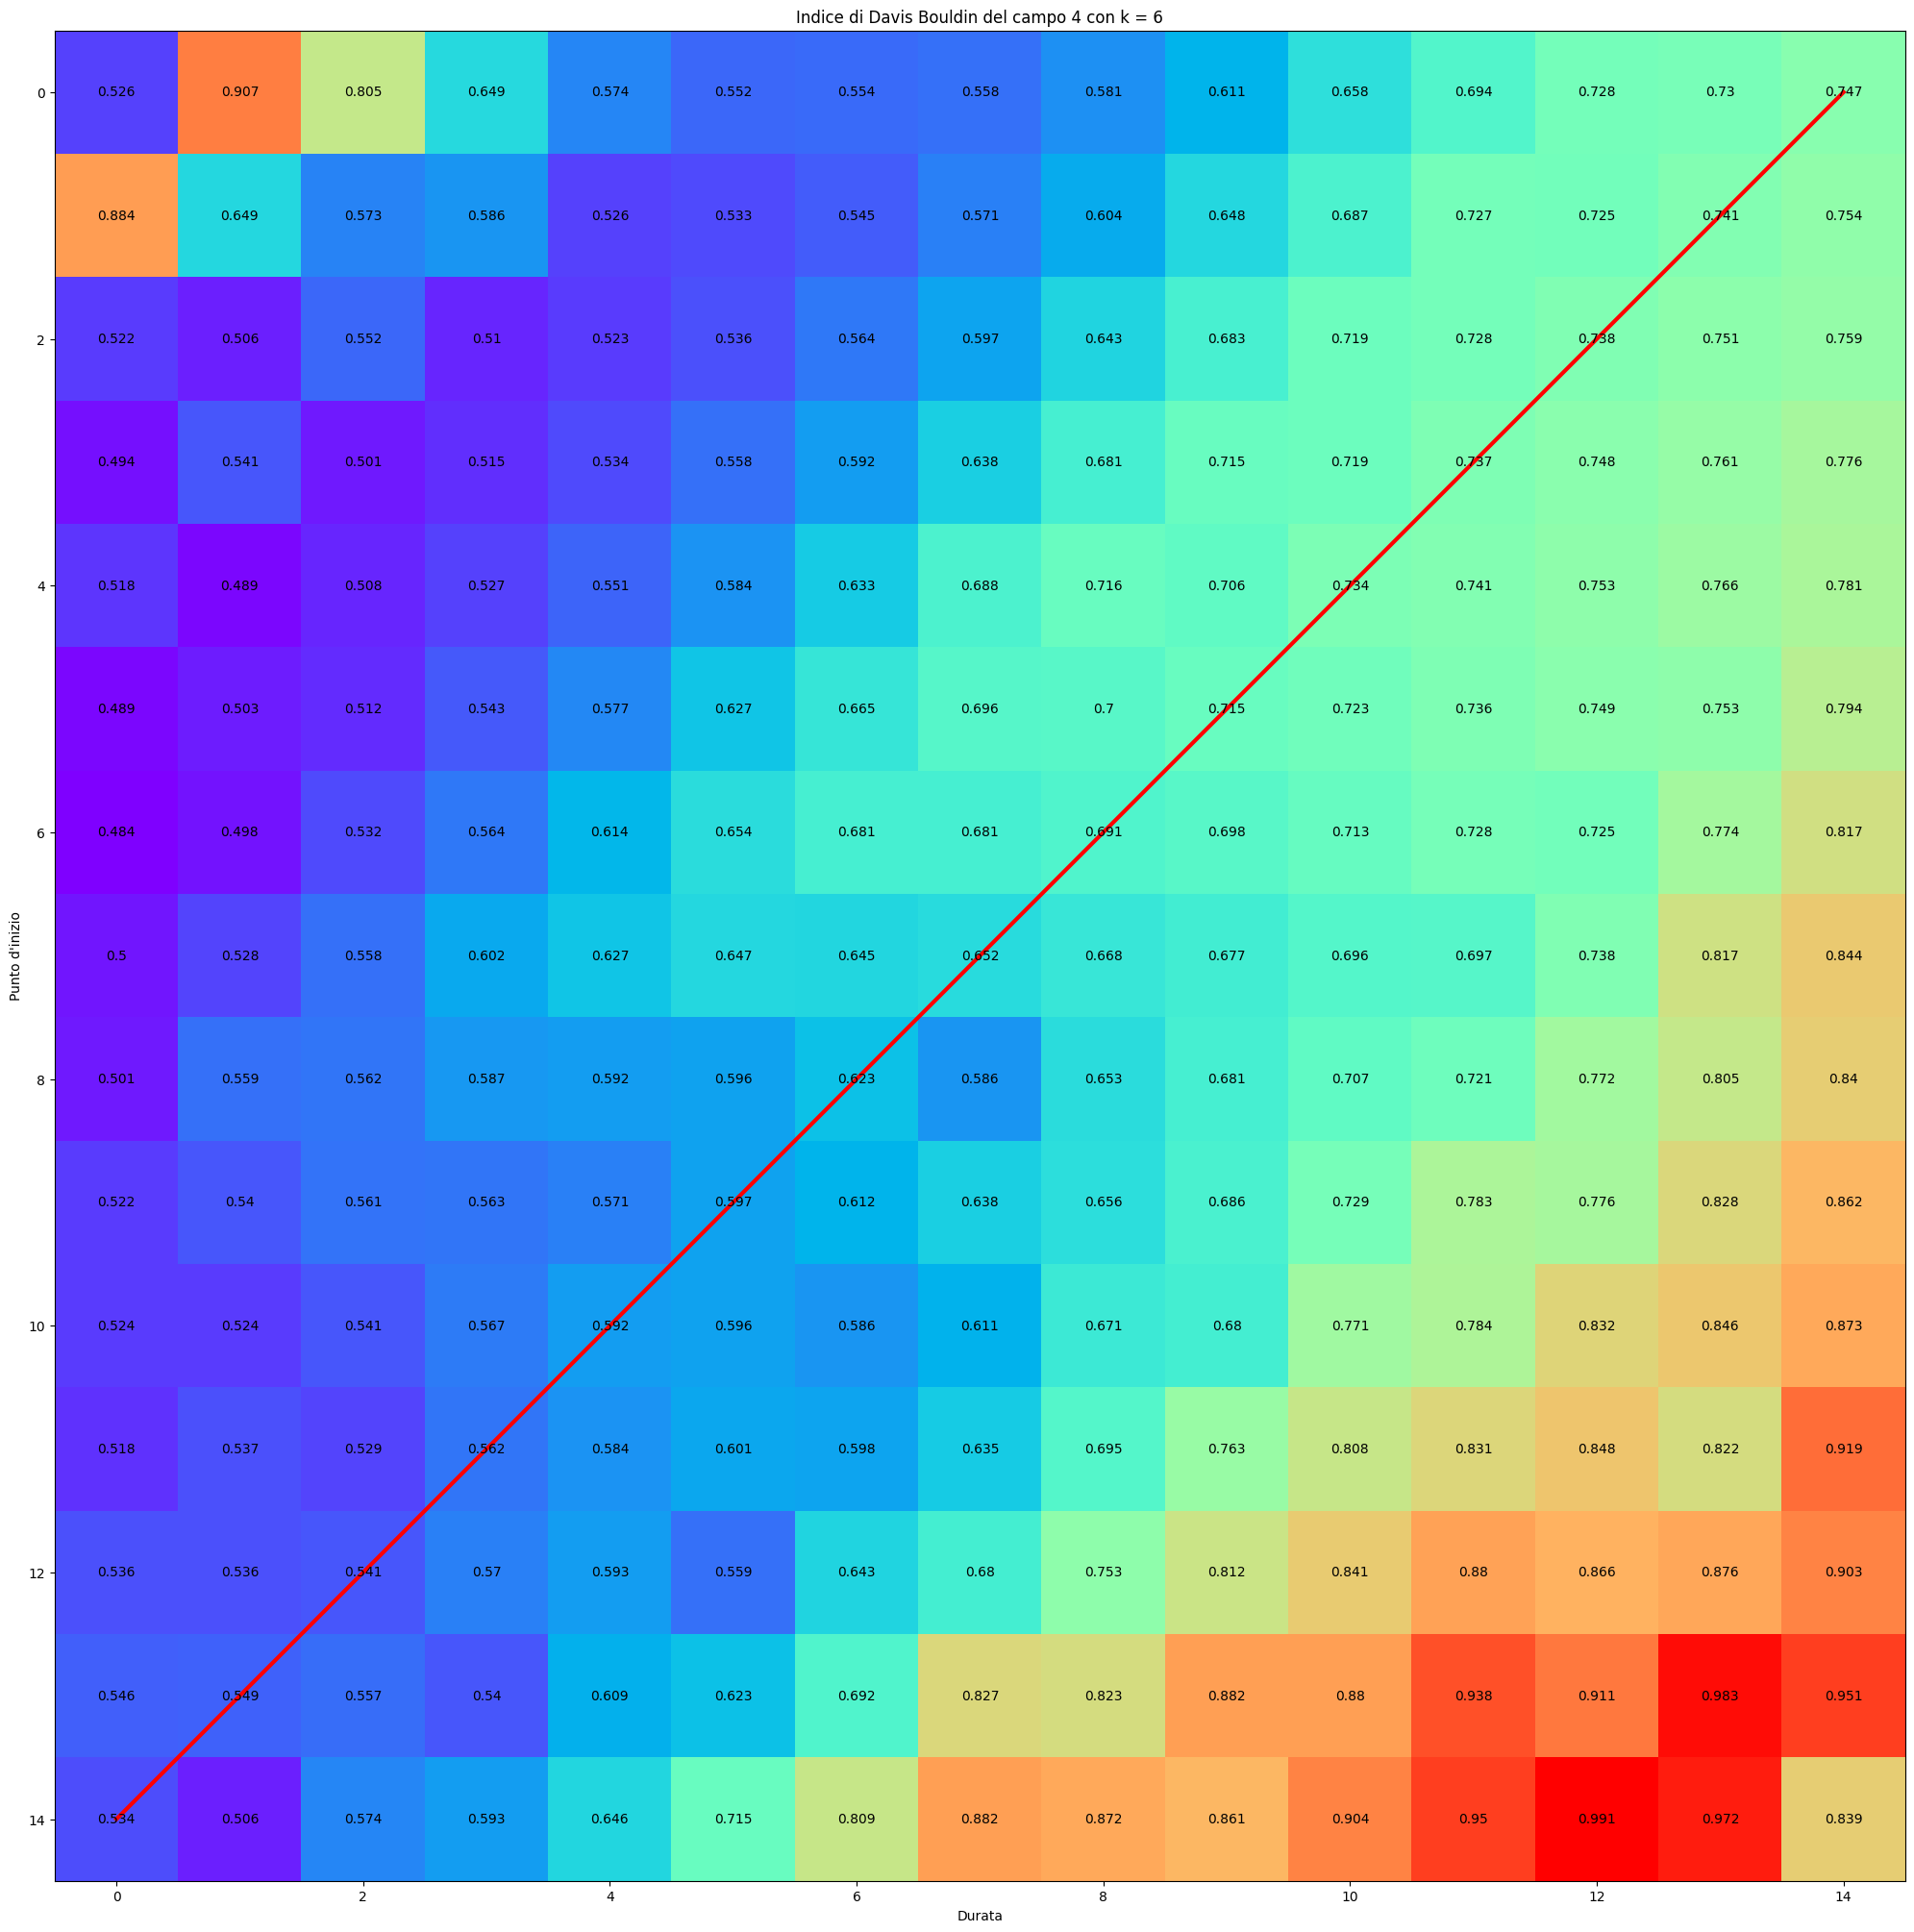

In [39]:
for i in range(0,5):
    Indice = davisBouldin4All[i]
    fig, ax = plt.subplots()
    image = ax.imshow(Indice[:,:],cmap='rainbow')
    line_start = [0, np.floor(71/5)]
    line_end = [np.floor(71/5), 0]
    plt.plot(line_start, line_end, color="red", linewidth=3)
    plt.title('Indice di Davis Bouldin del campo 4 con k = '+str(i+2))
    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")

    fig.set_size_inches(25,25)
    for i in range(XMax):
        for j in range(YMax):
            c = np.round(Indice[i,j],decimals=3)
            ax.text(j, i, str(c), va='center', ha='center')


    plt.show()

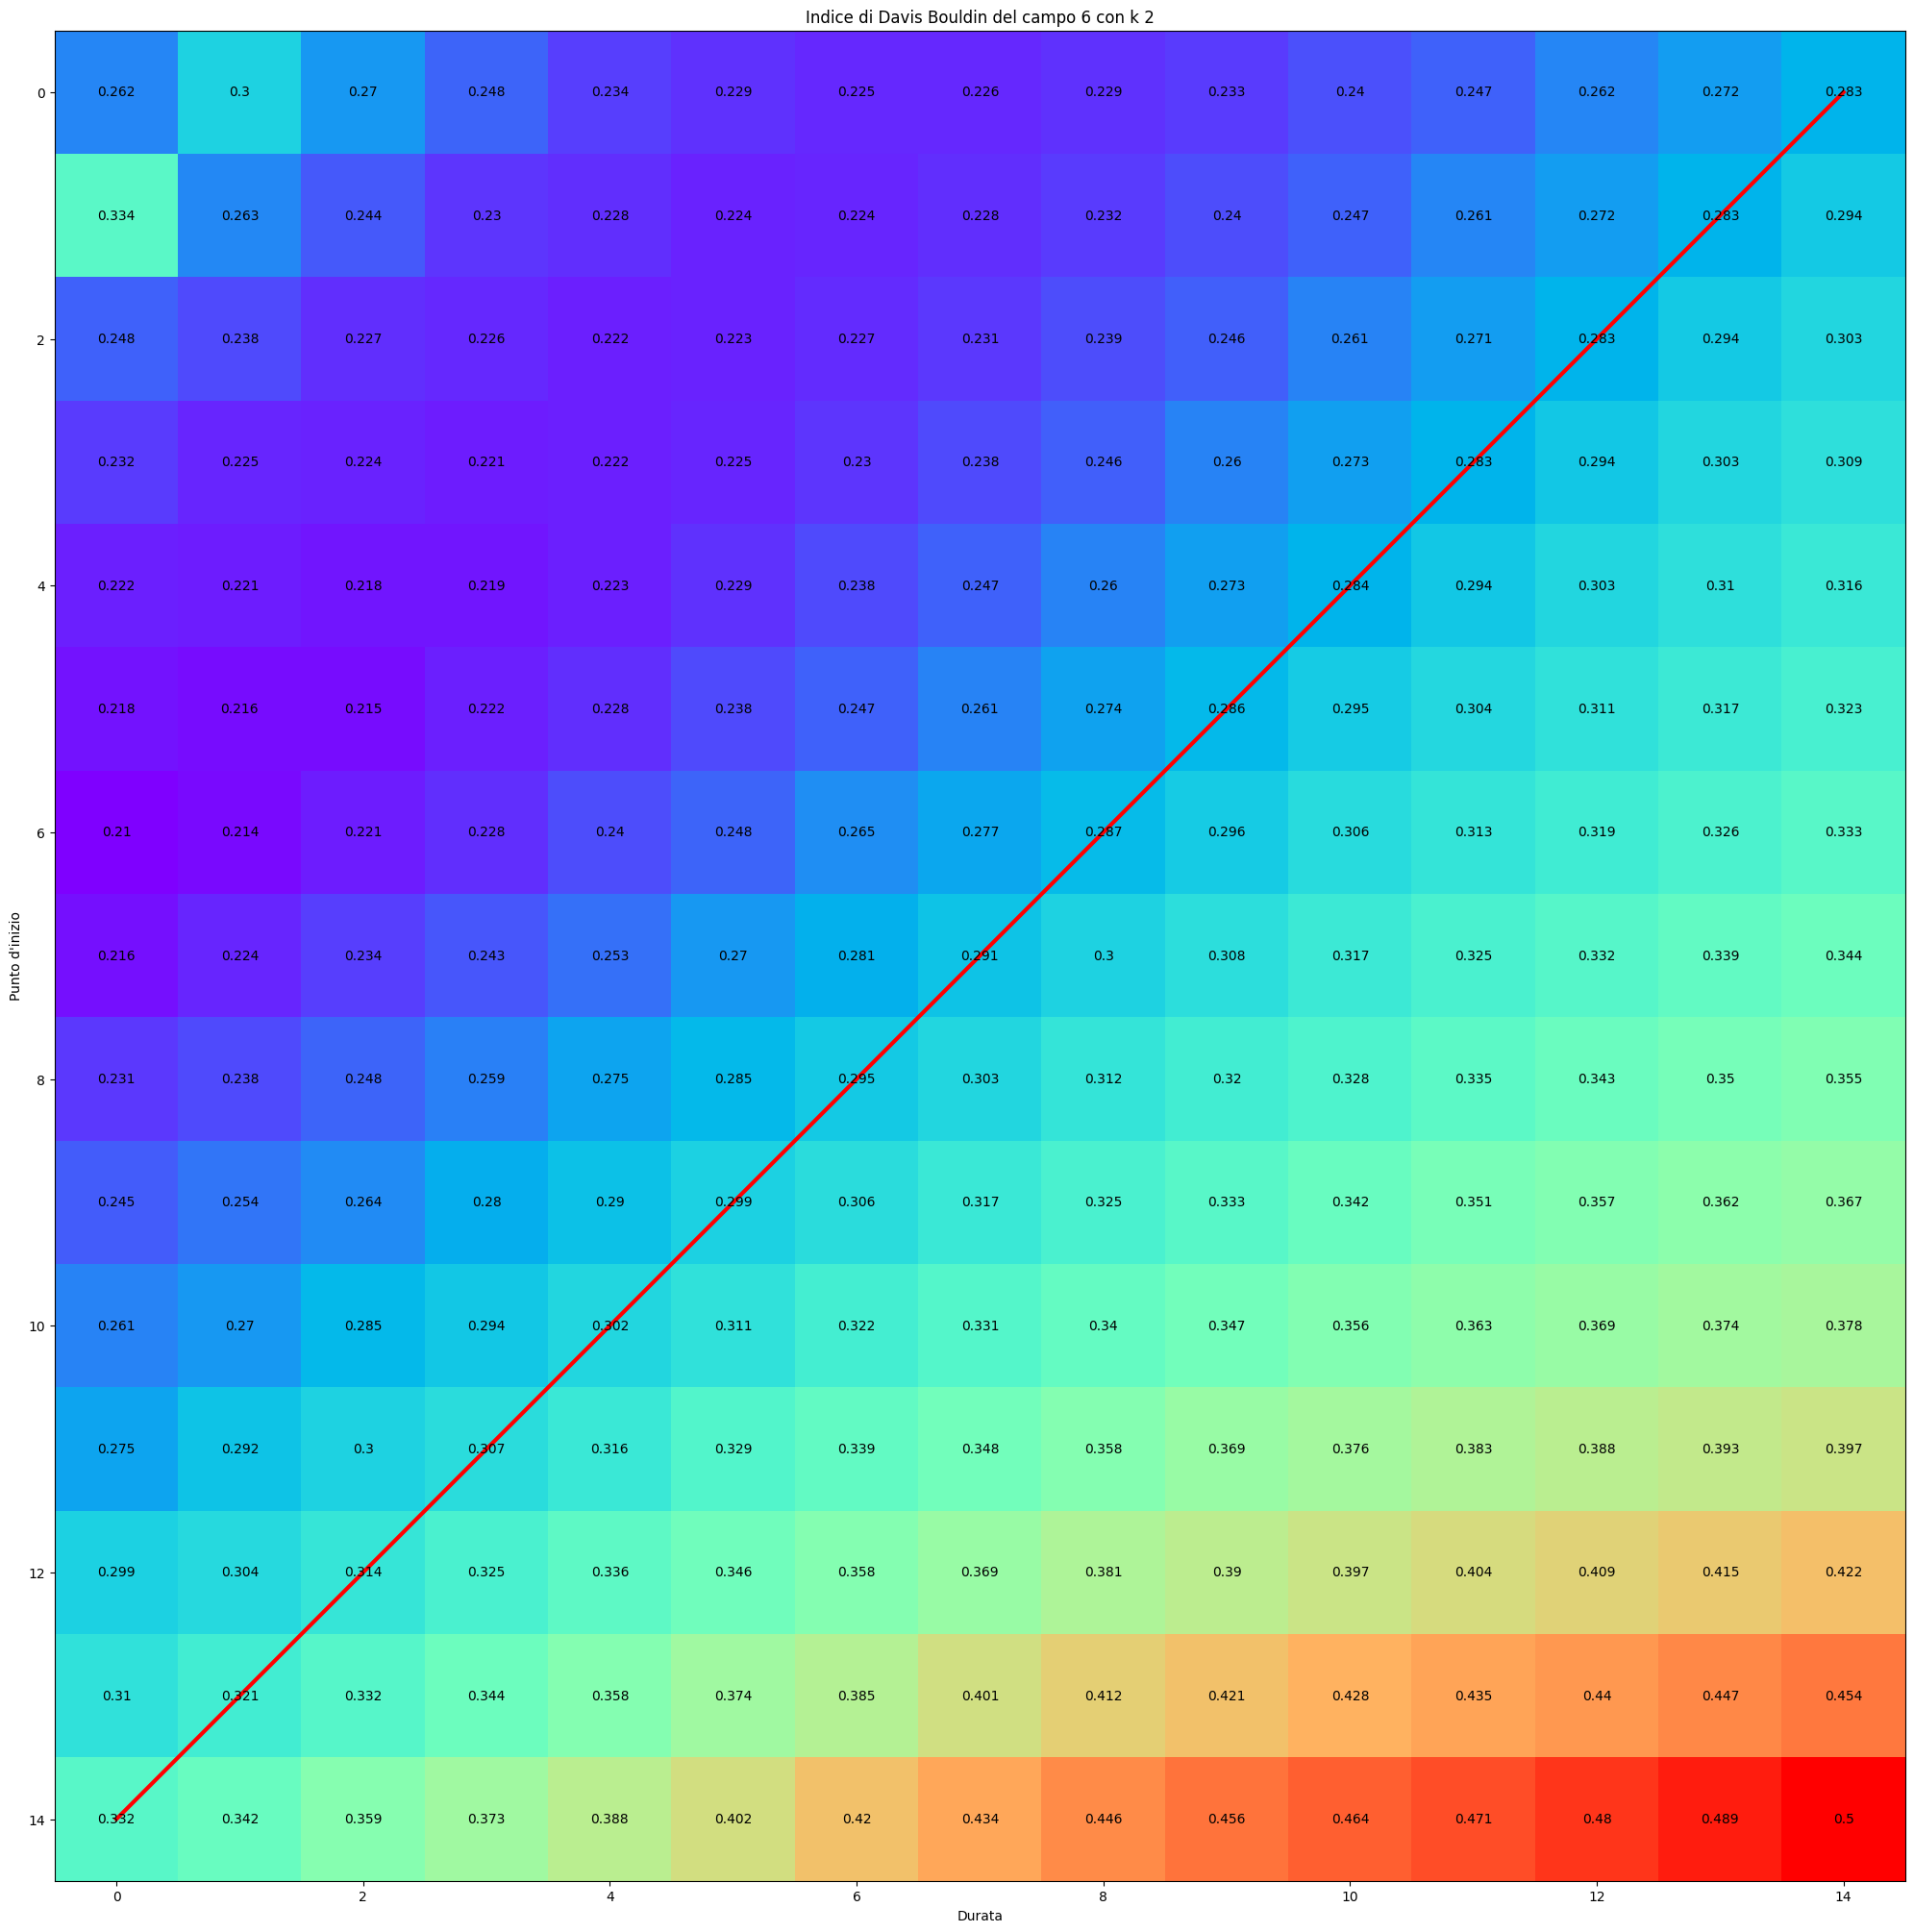

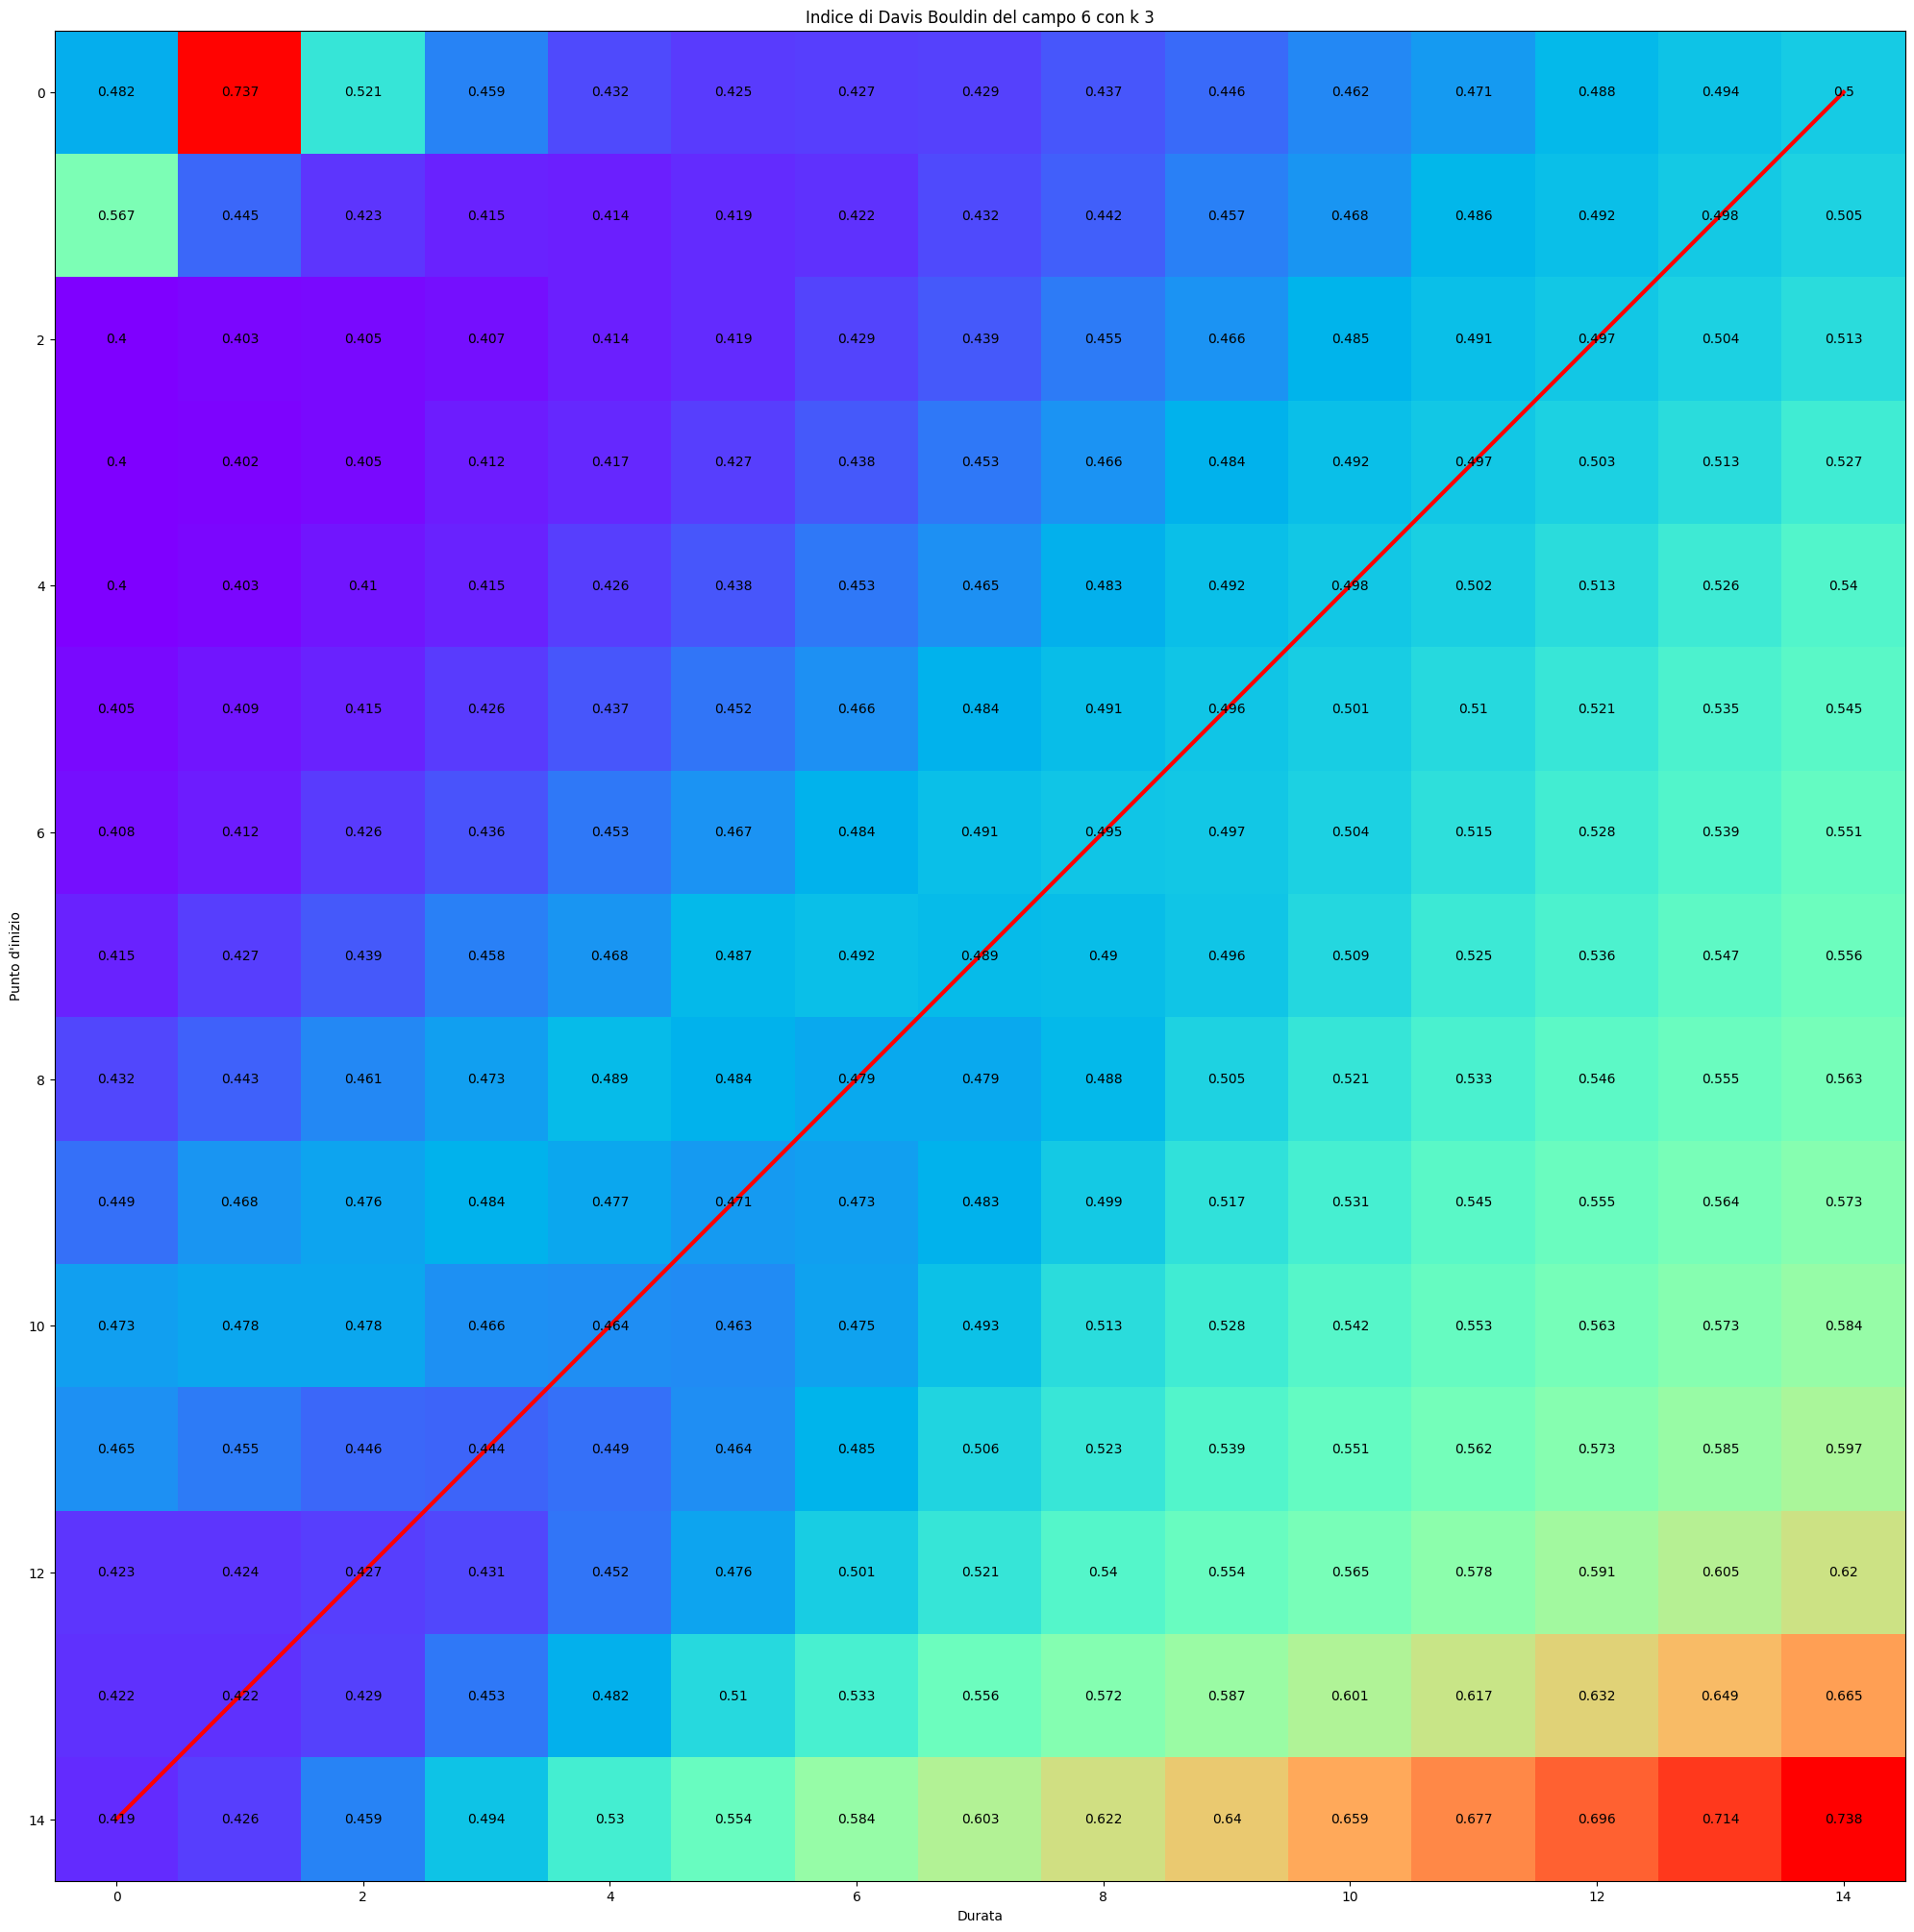

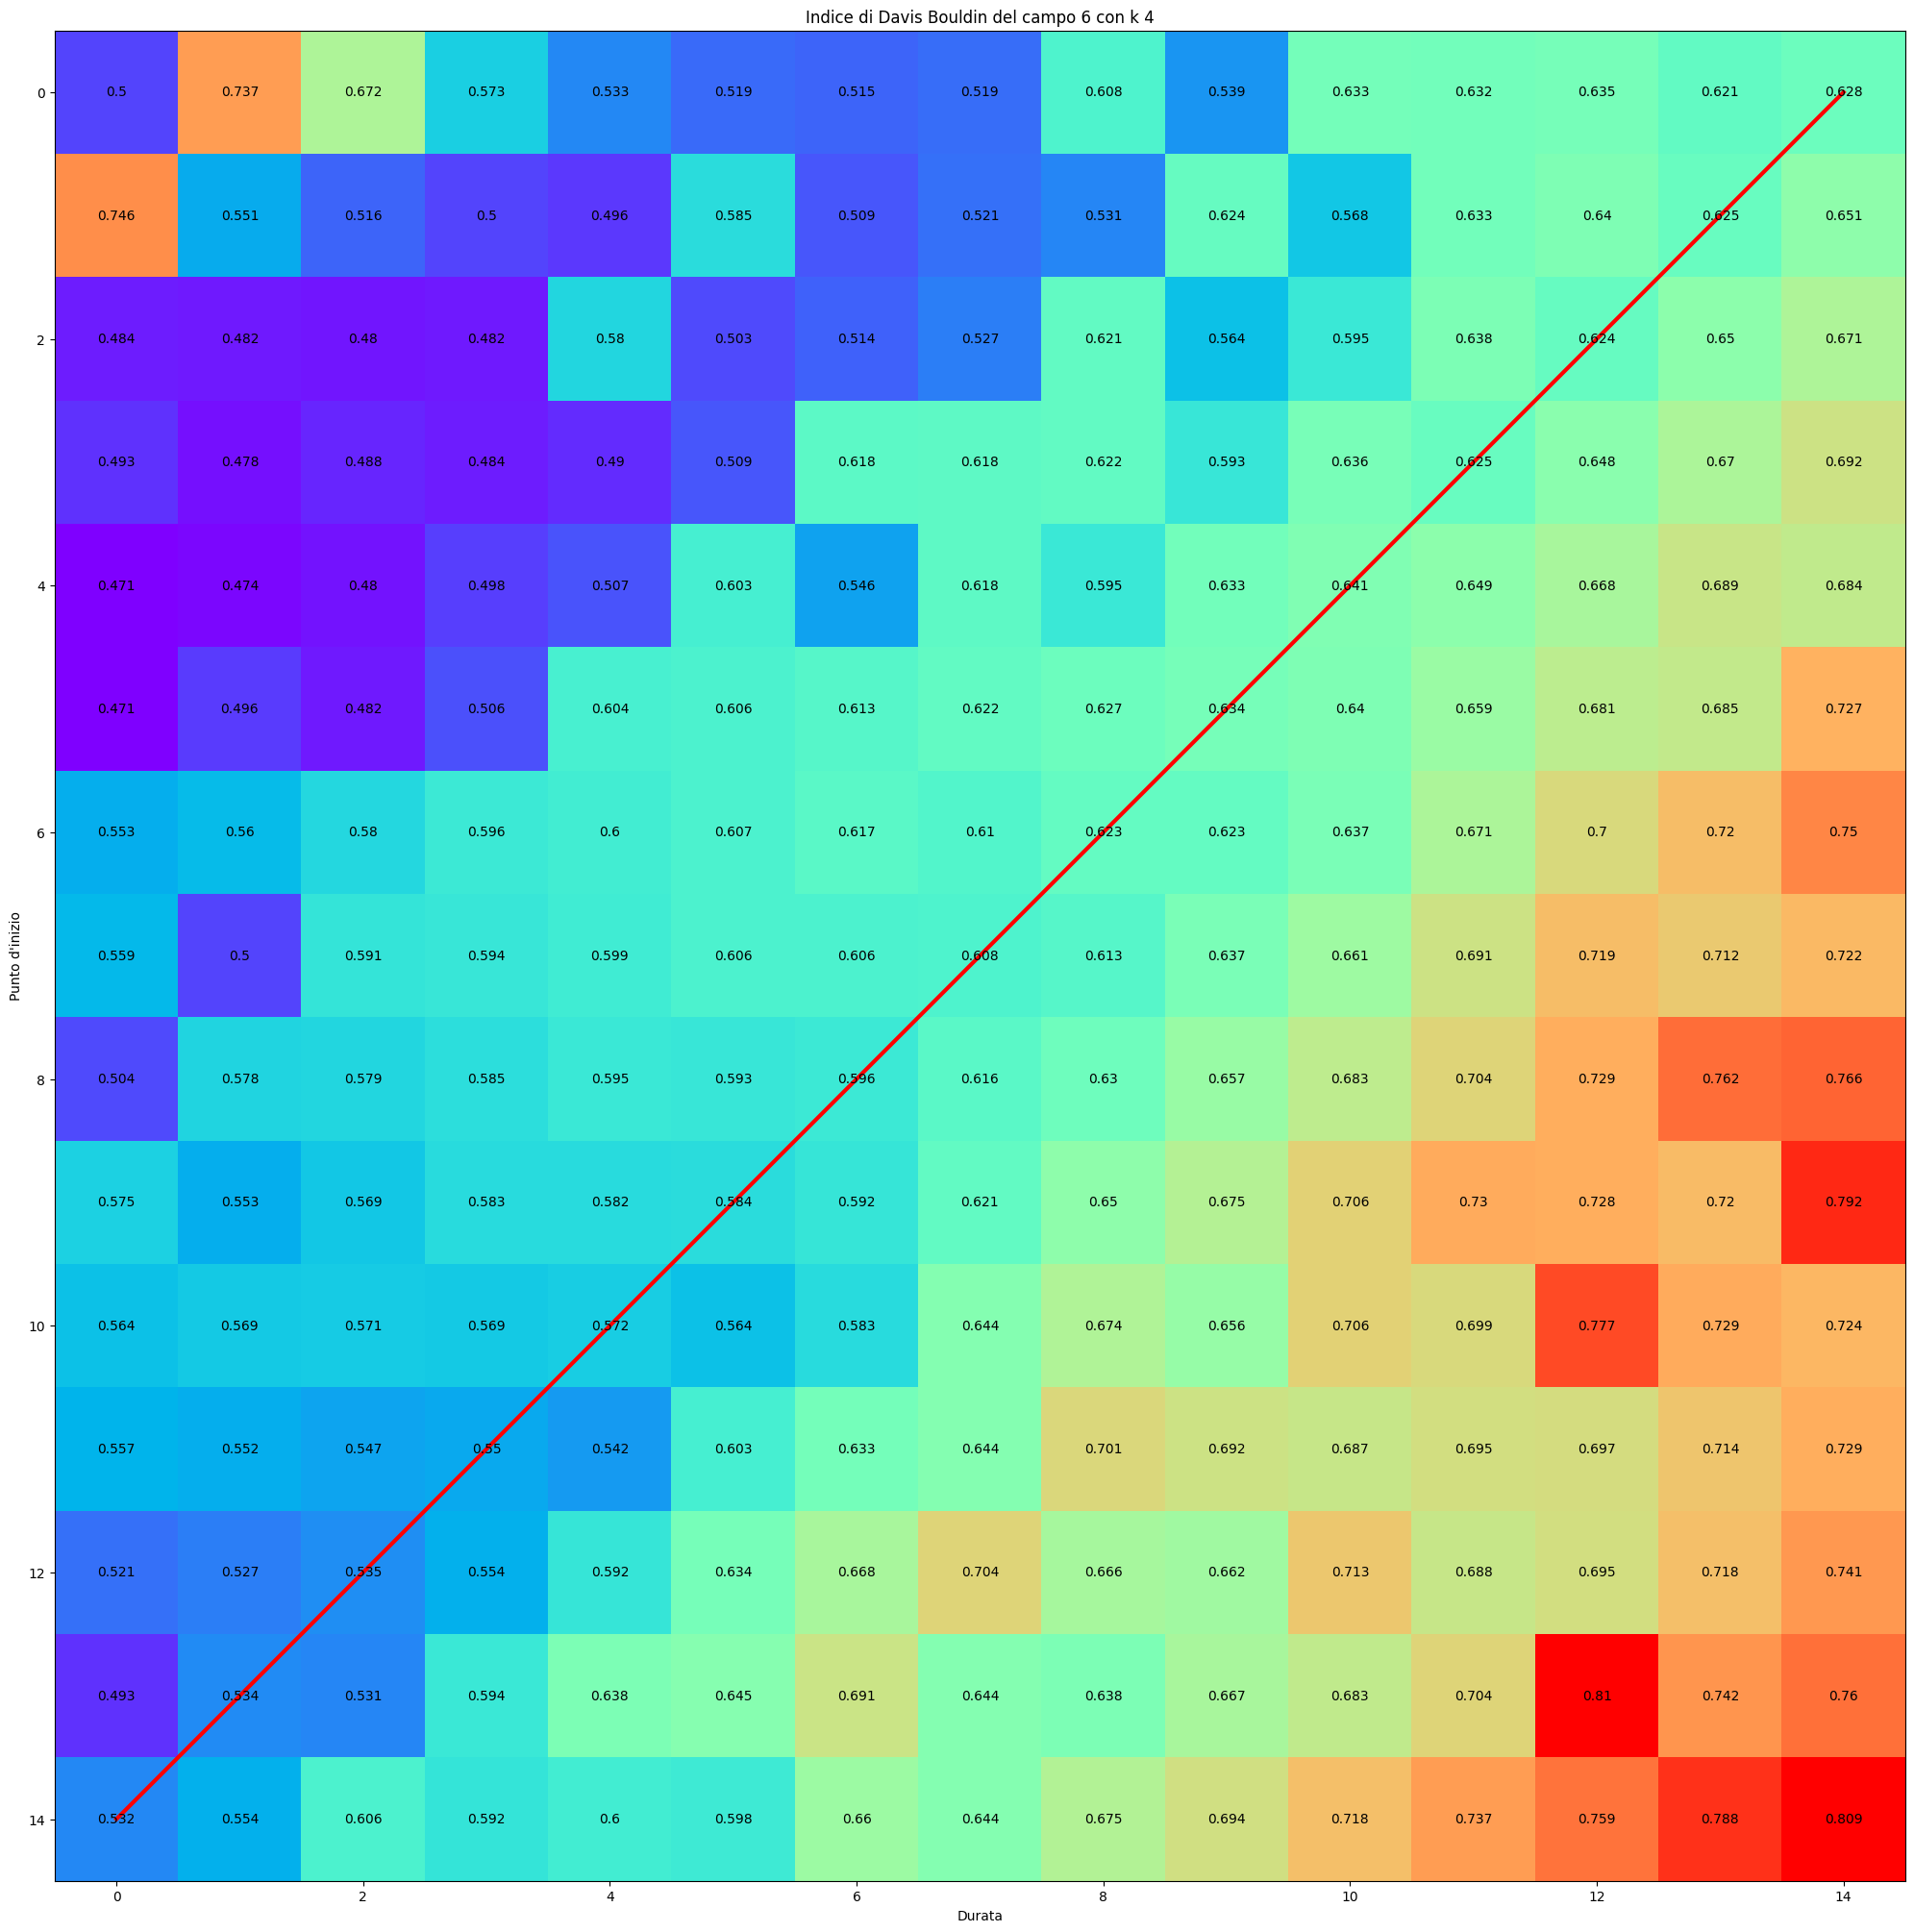

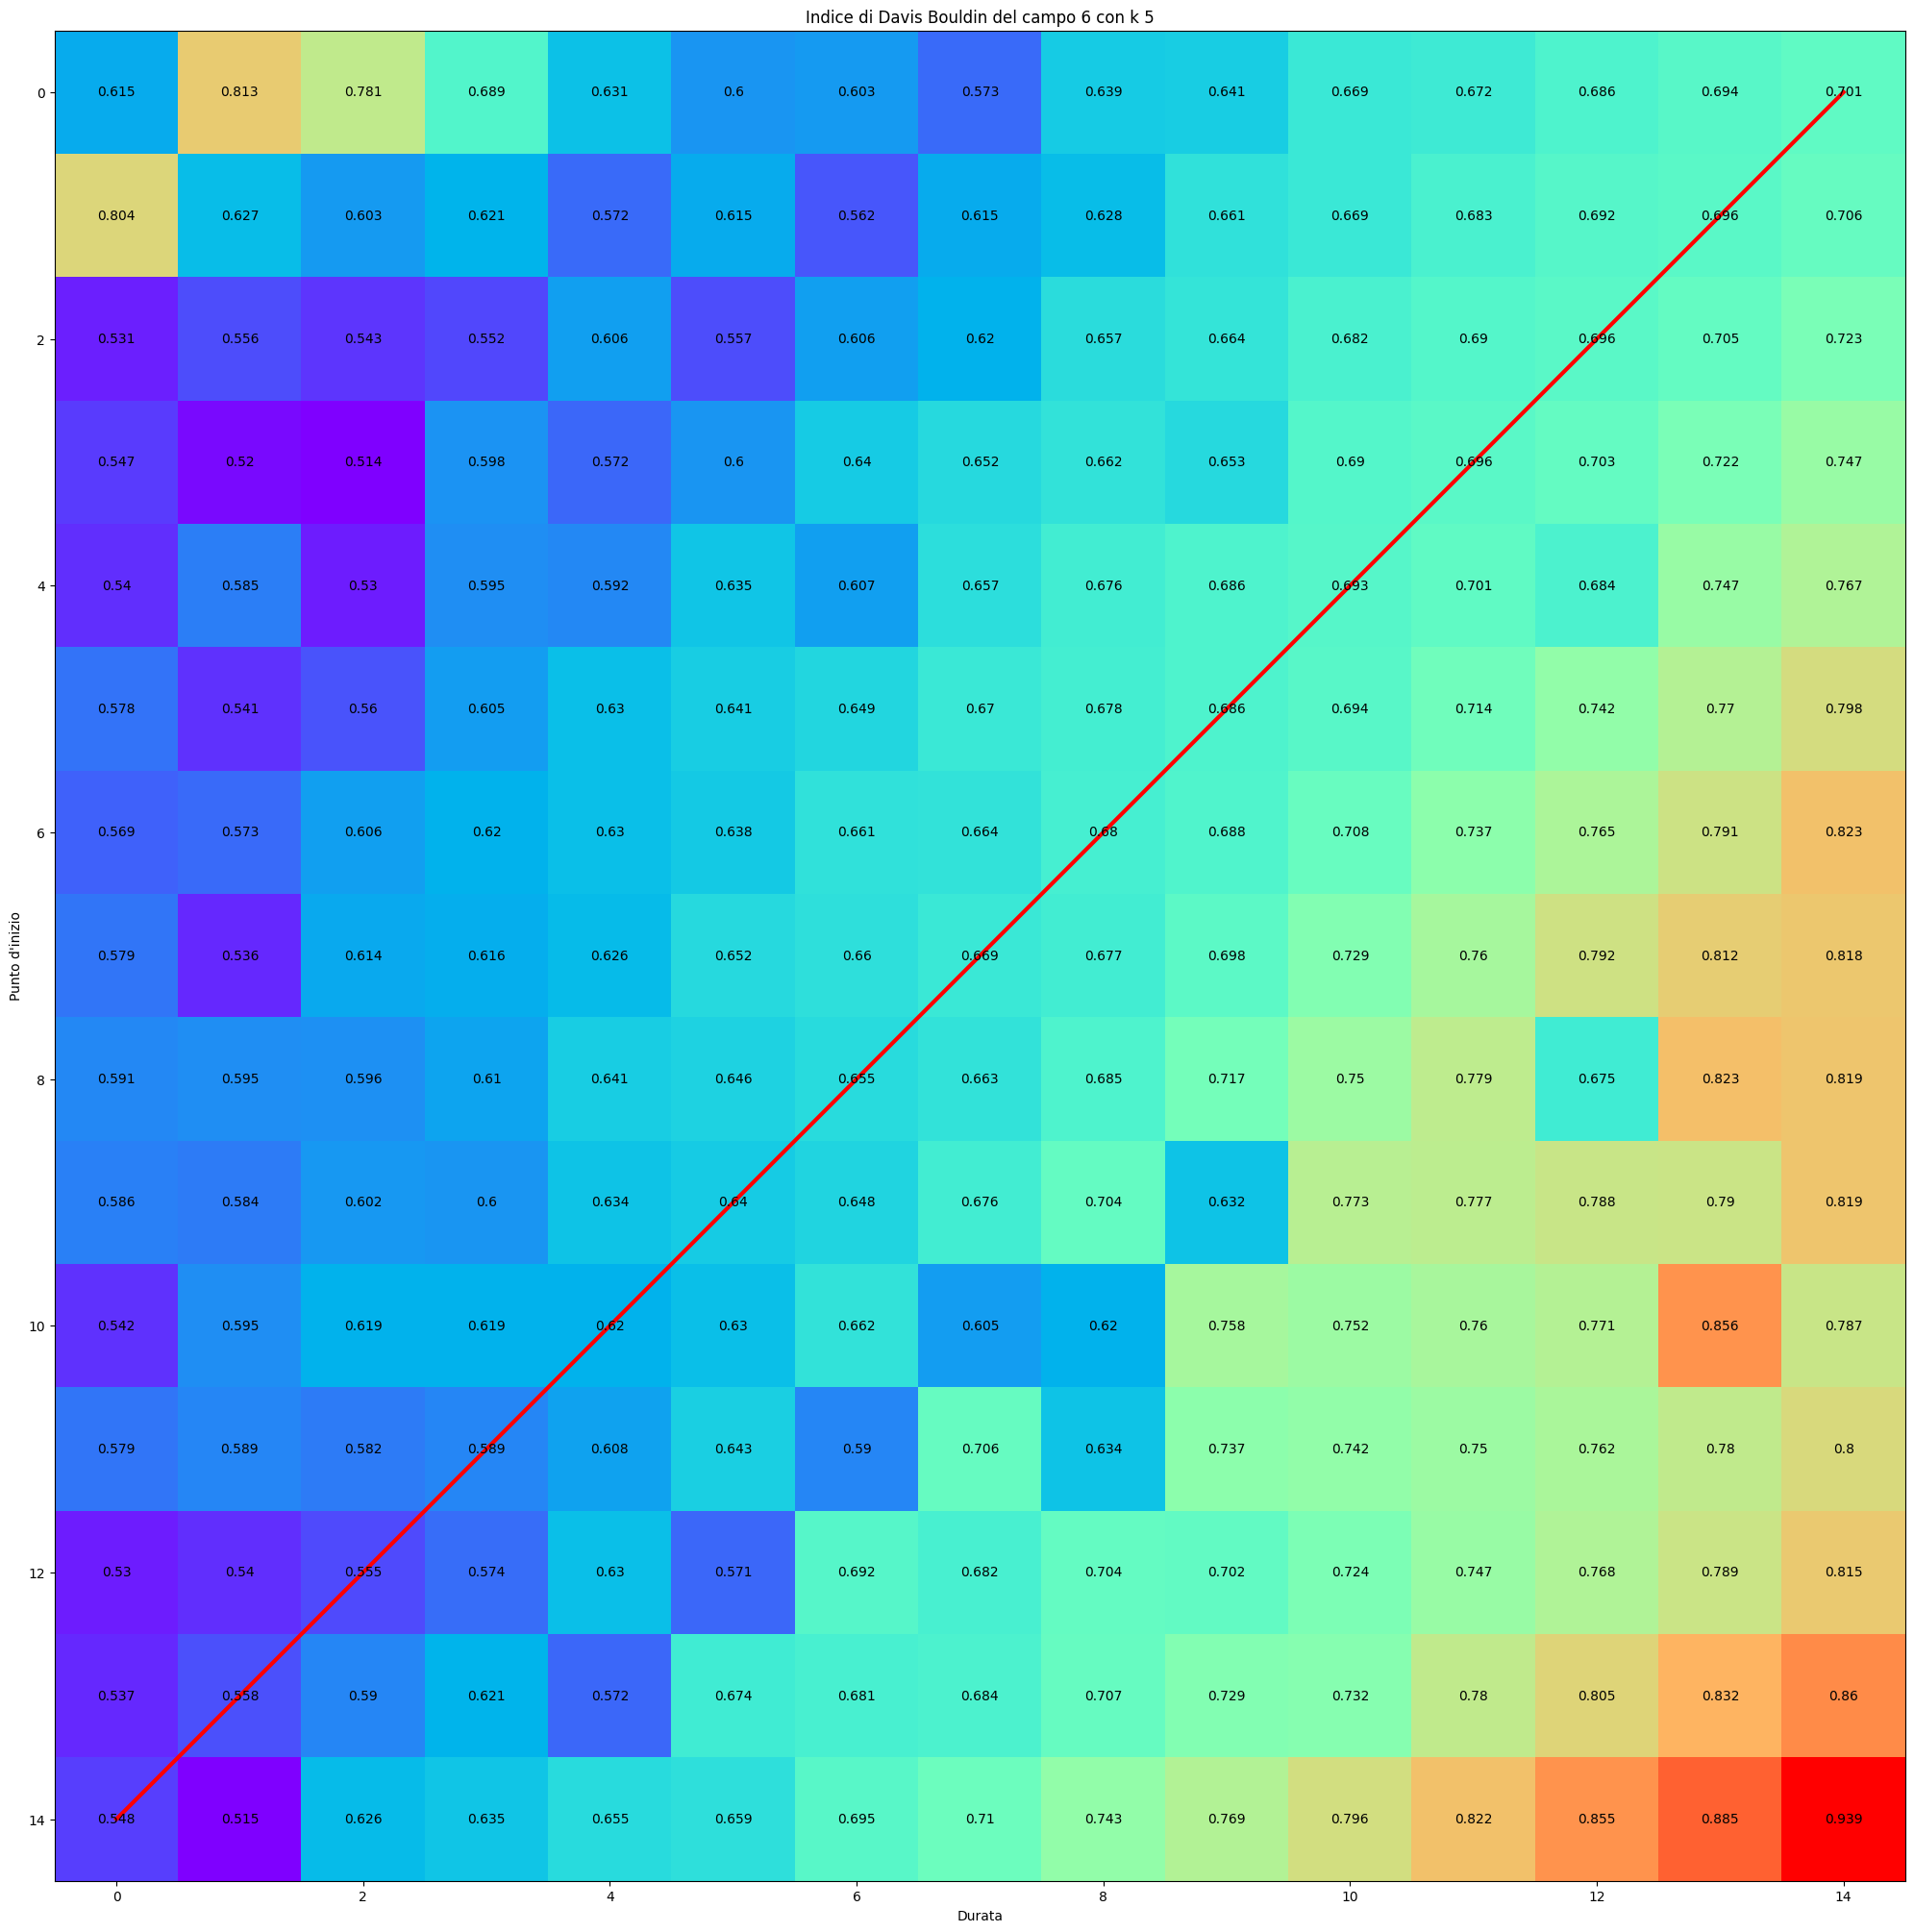

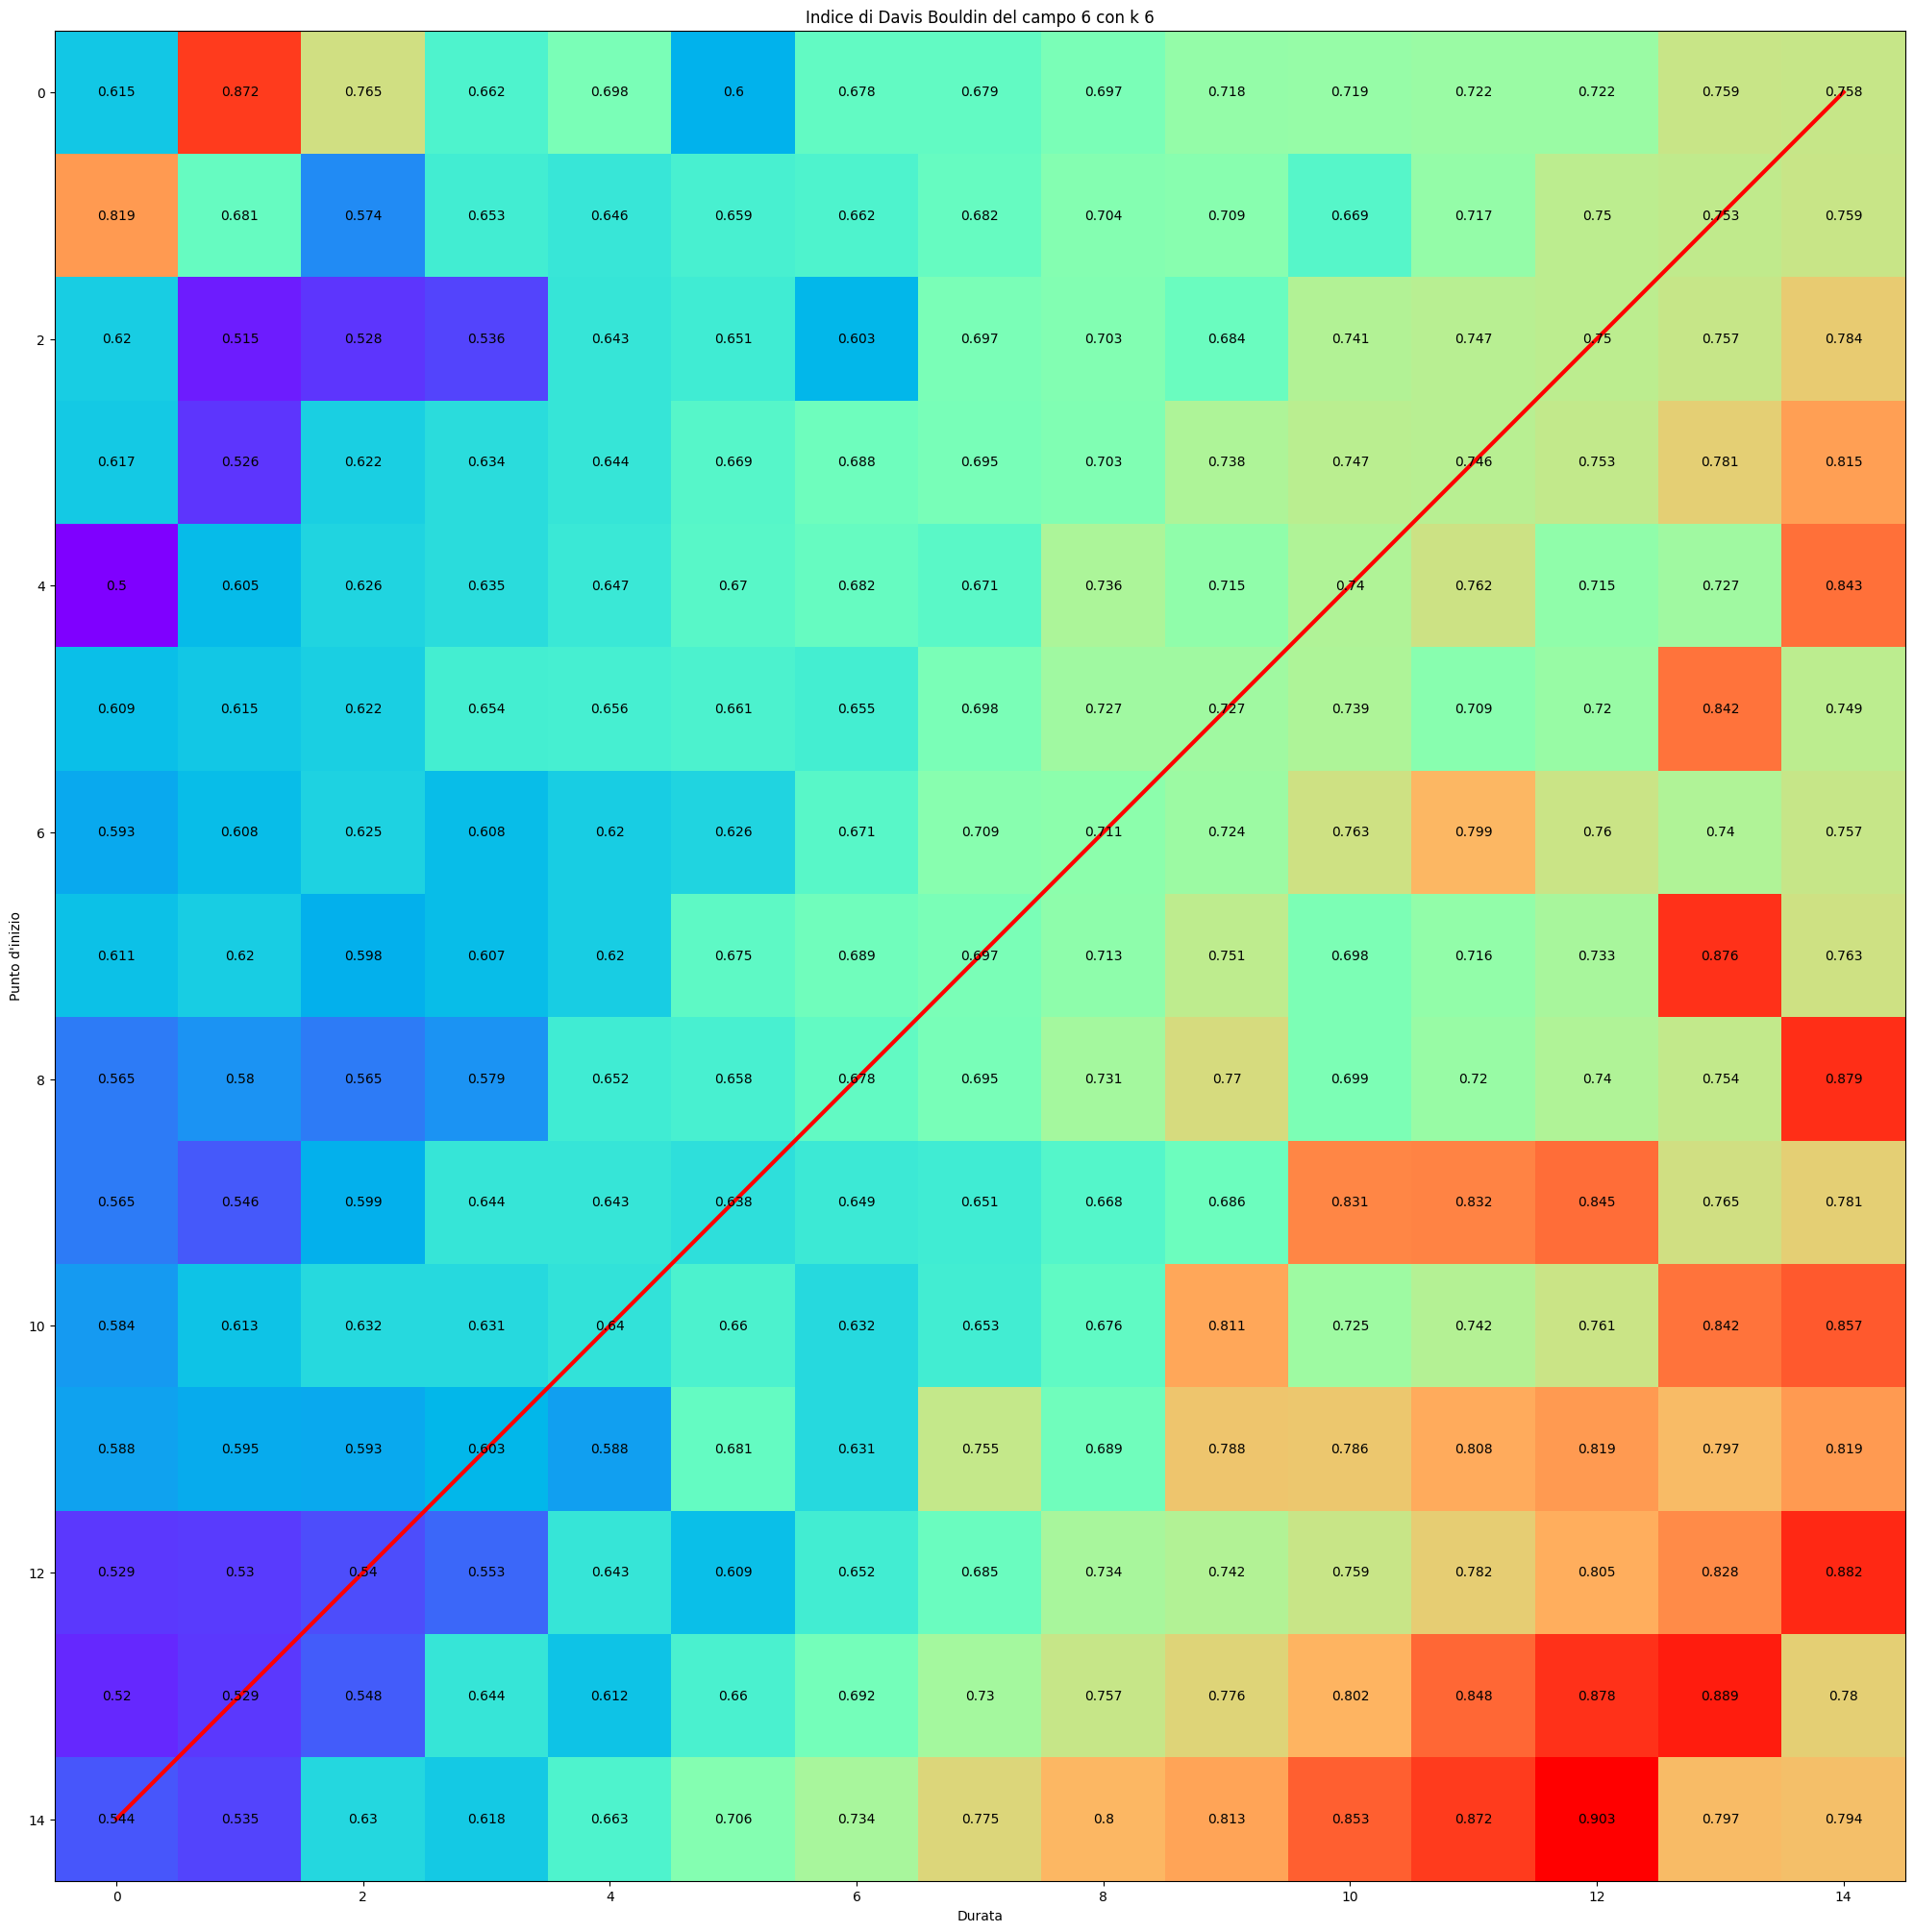

In [90]:
for i in range(0,5):
    Indice = davisBouldin6All[i]
    fig, ax = plt.subplots()
    image = ax.imshow(Indice[:,:],cmap='rainbow')
    line_start = [0, np.floor(71/5)]
    line_end = [np.floor(71/5), 0]
    plt.plot(line_start, line_end, color="red", linewidth=3)
    plt.title('Indice di Davis Bouldin del campo 6 con k = '+str(i+2))
    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")

    fig.set_size_inches(25,25)
    for i in range(XMax):
        for j in range(YMax):
            c = np.round(Indice[i,j],decimals=3)
            ax.text(j, i, str(c), va='center', ha='center')


    plt.show()

# Andiamo a rappresentare i valori di coesione dentro delle matrici

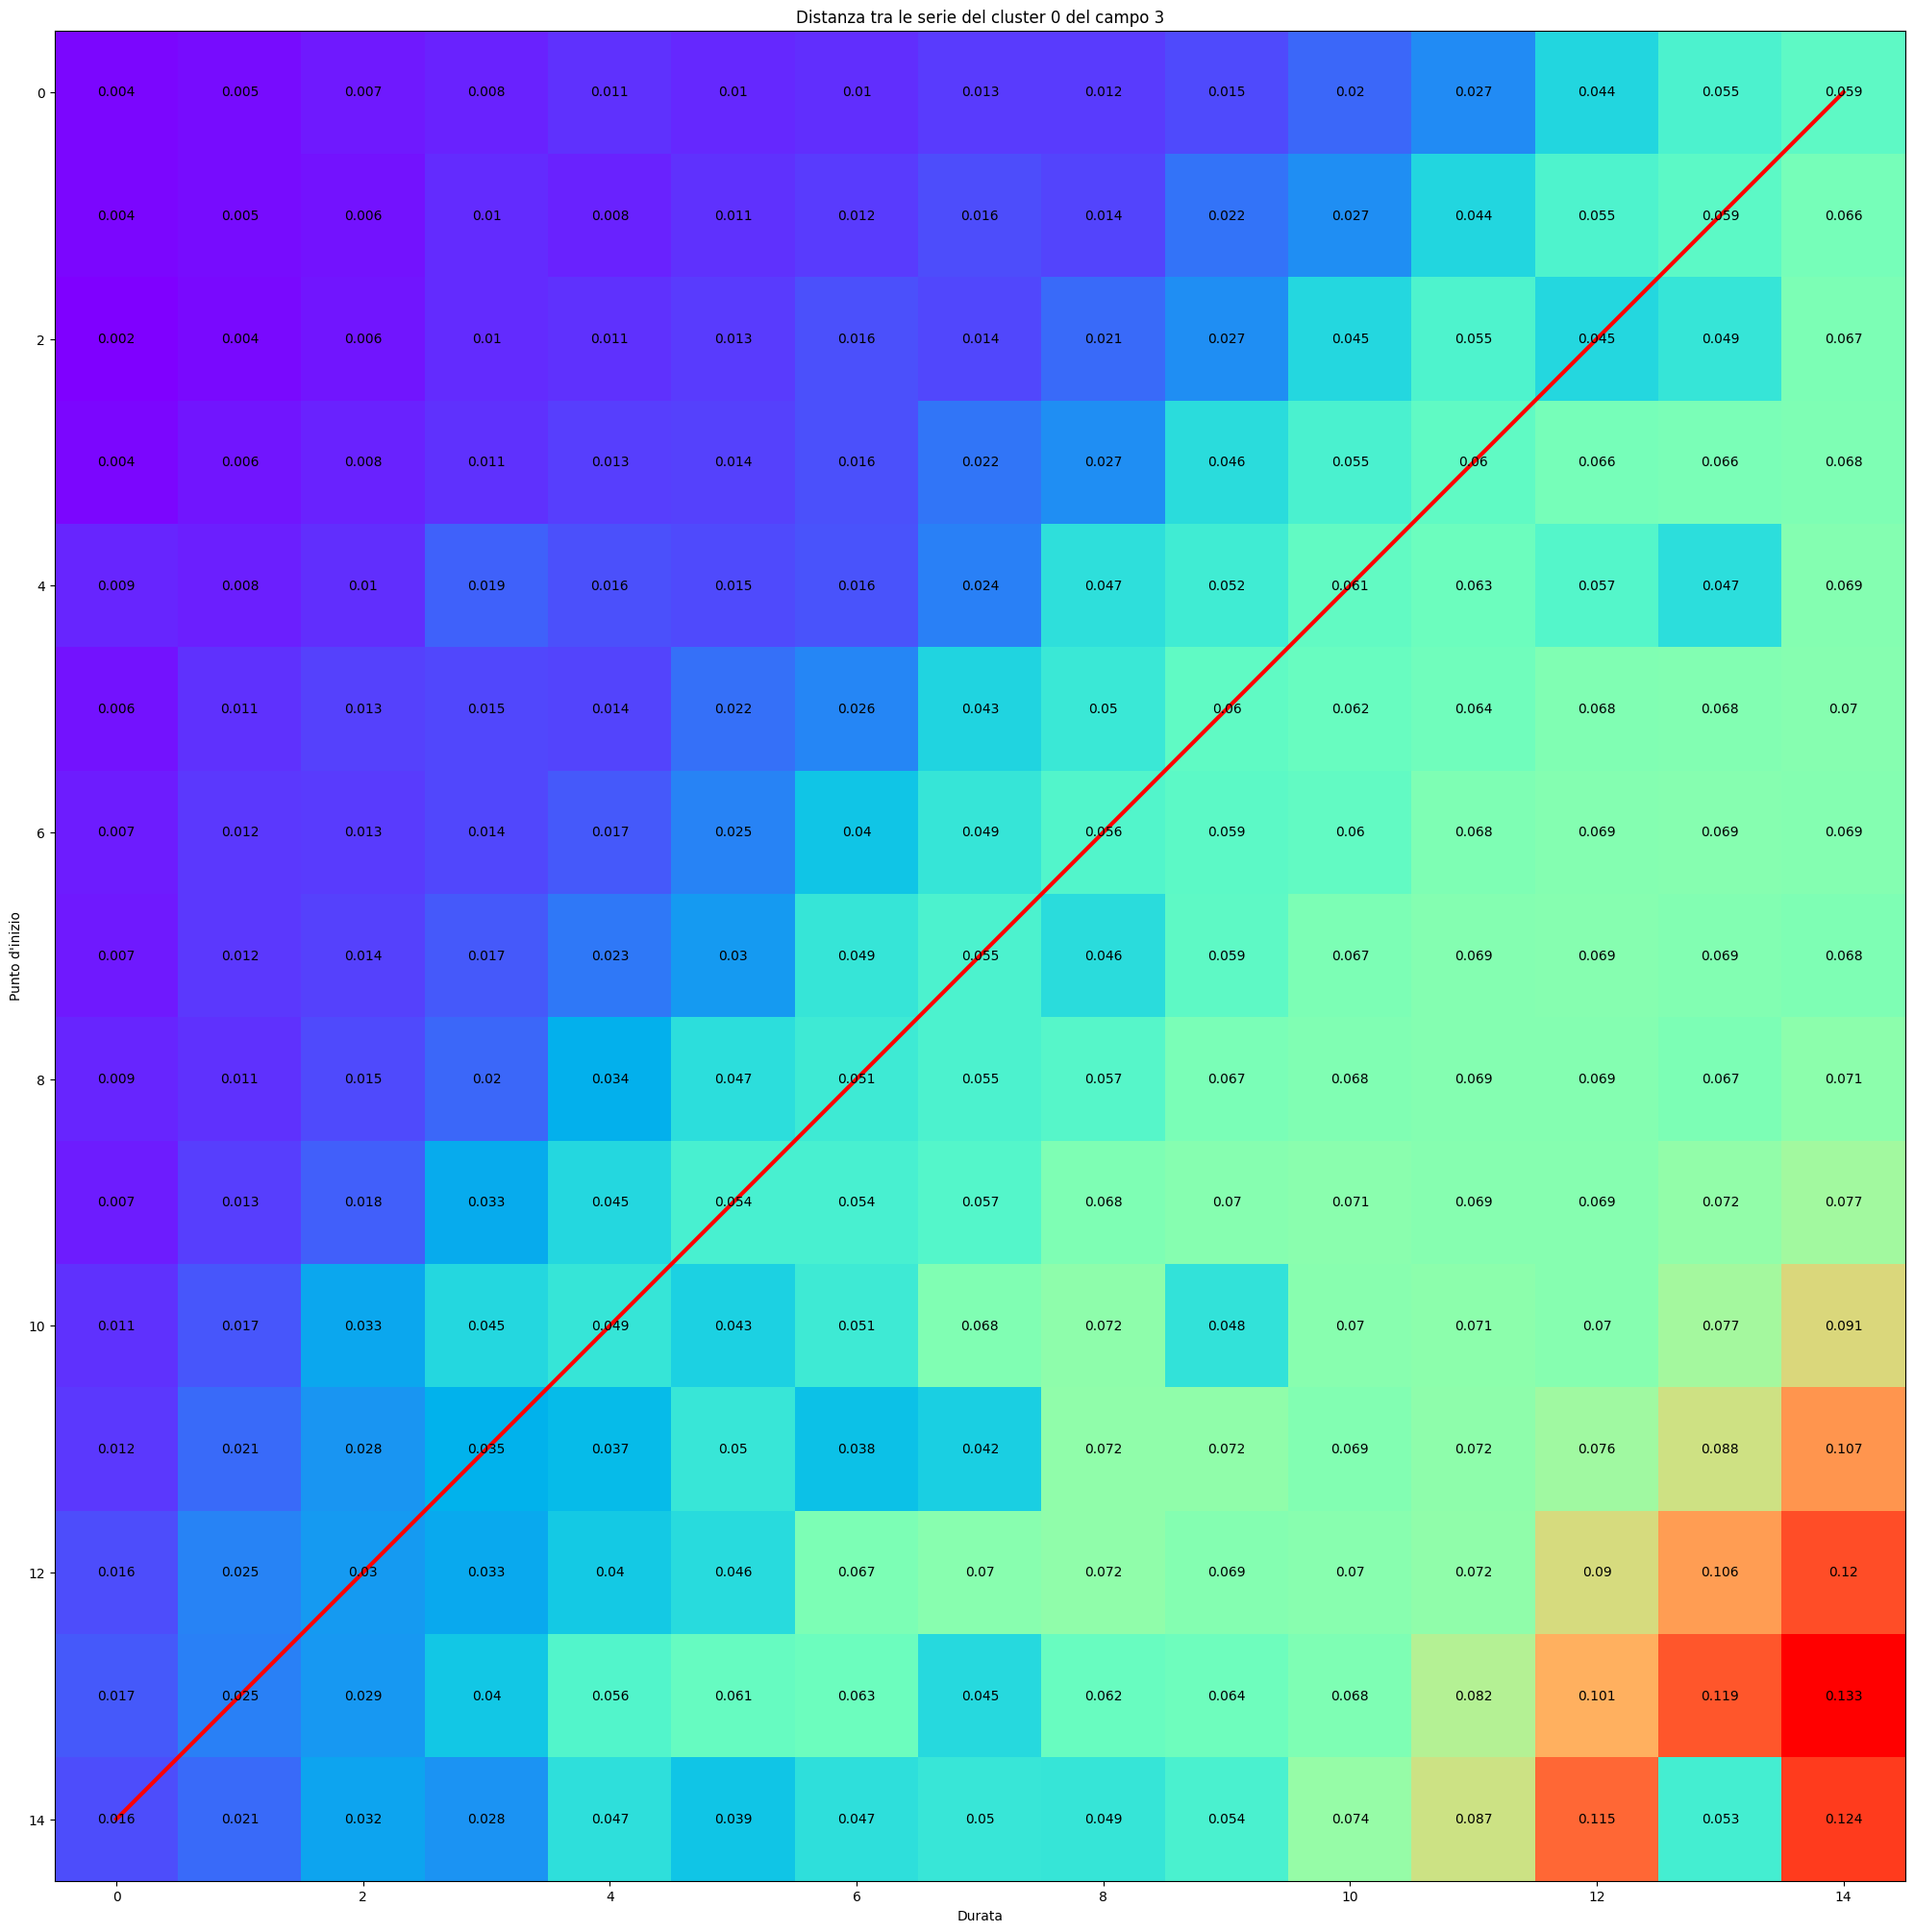

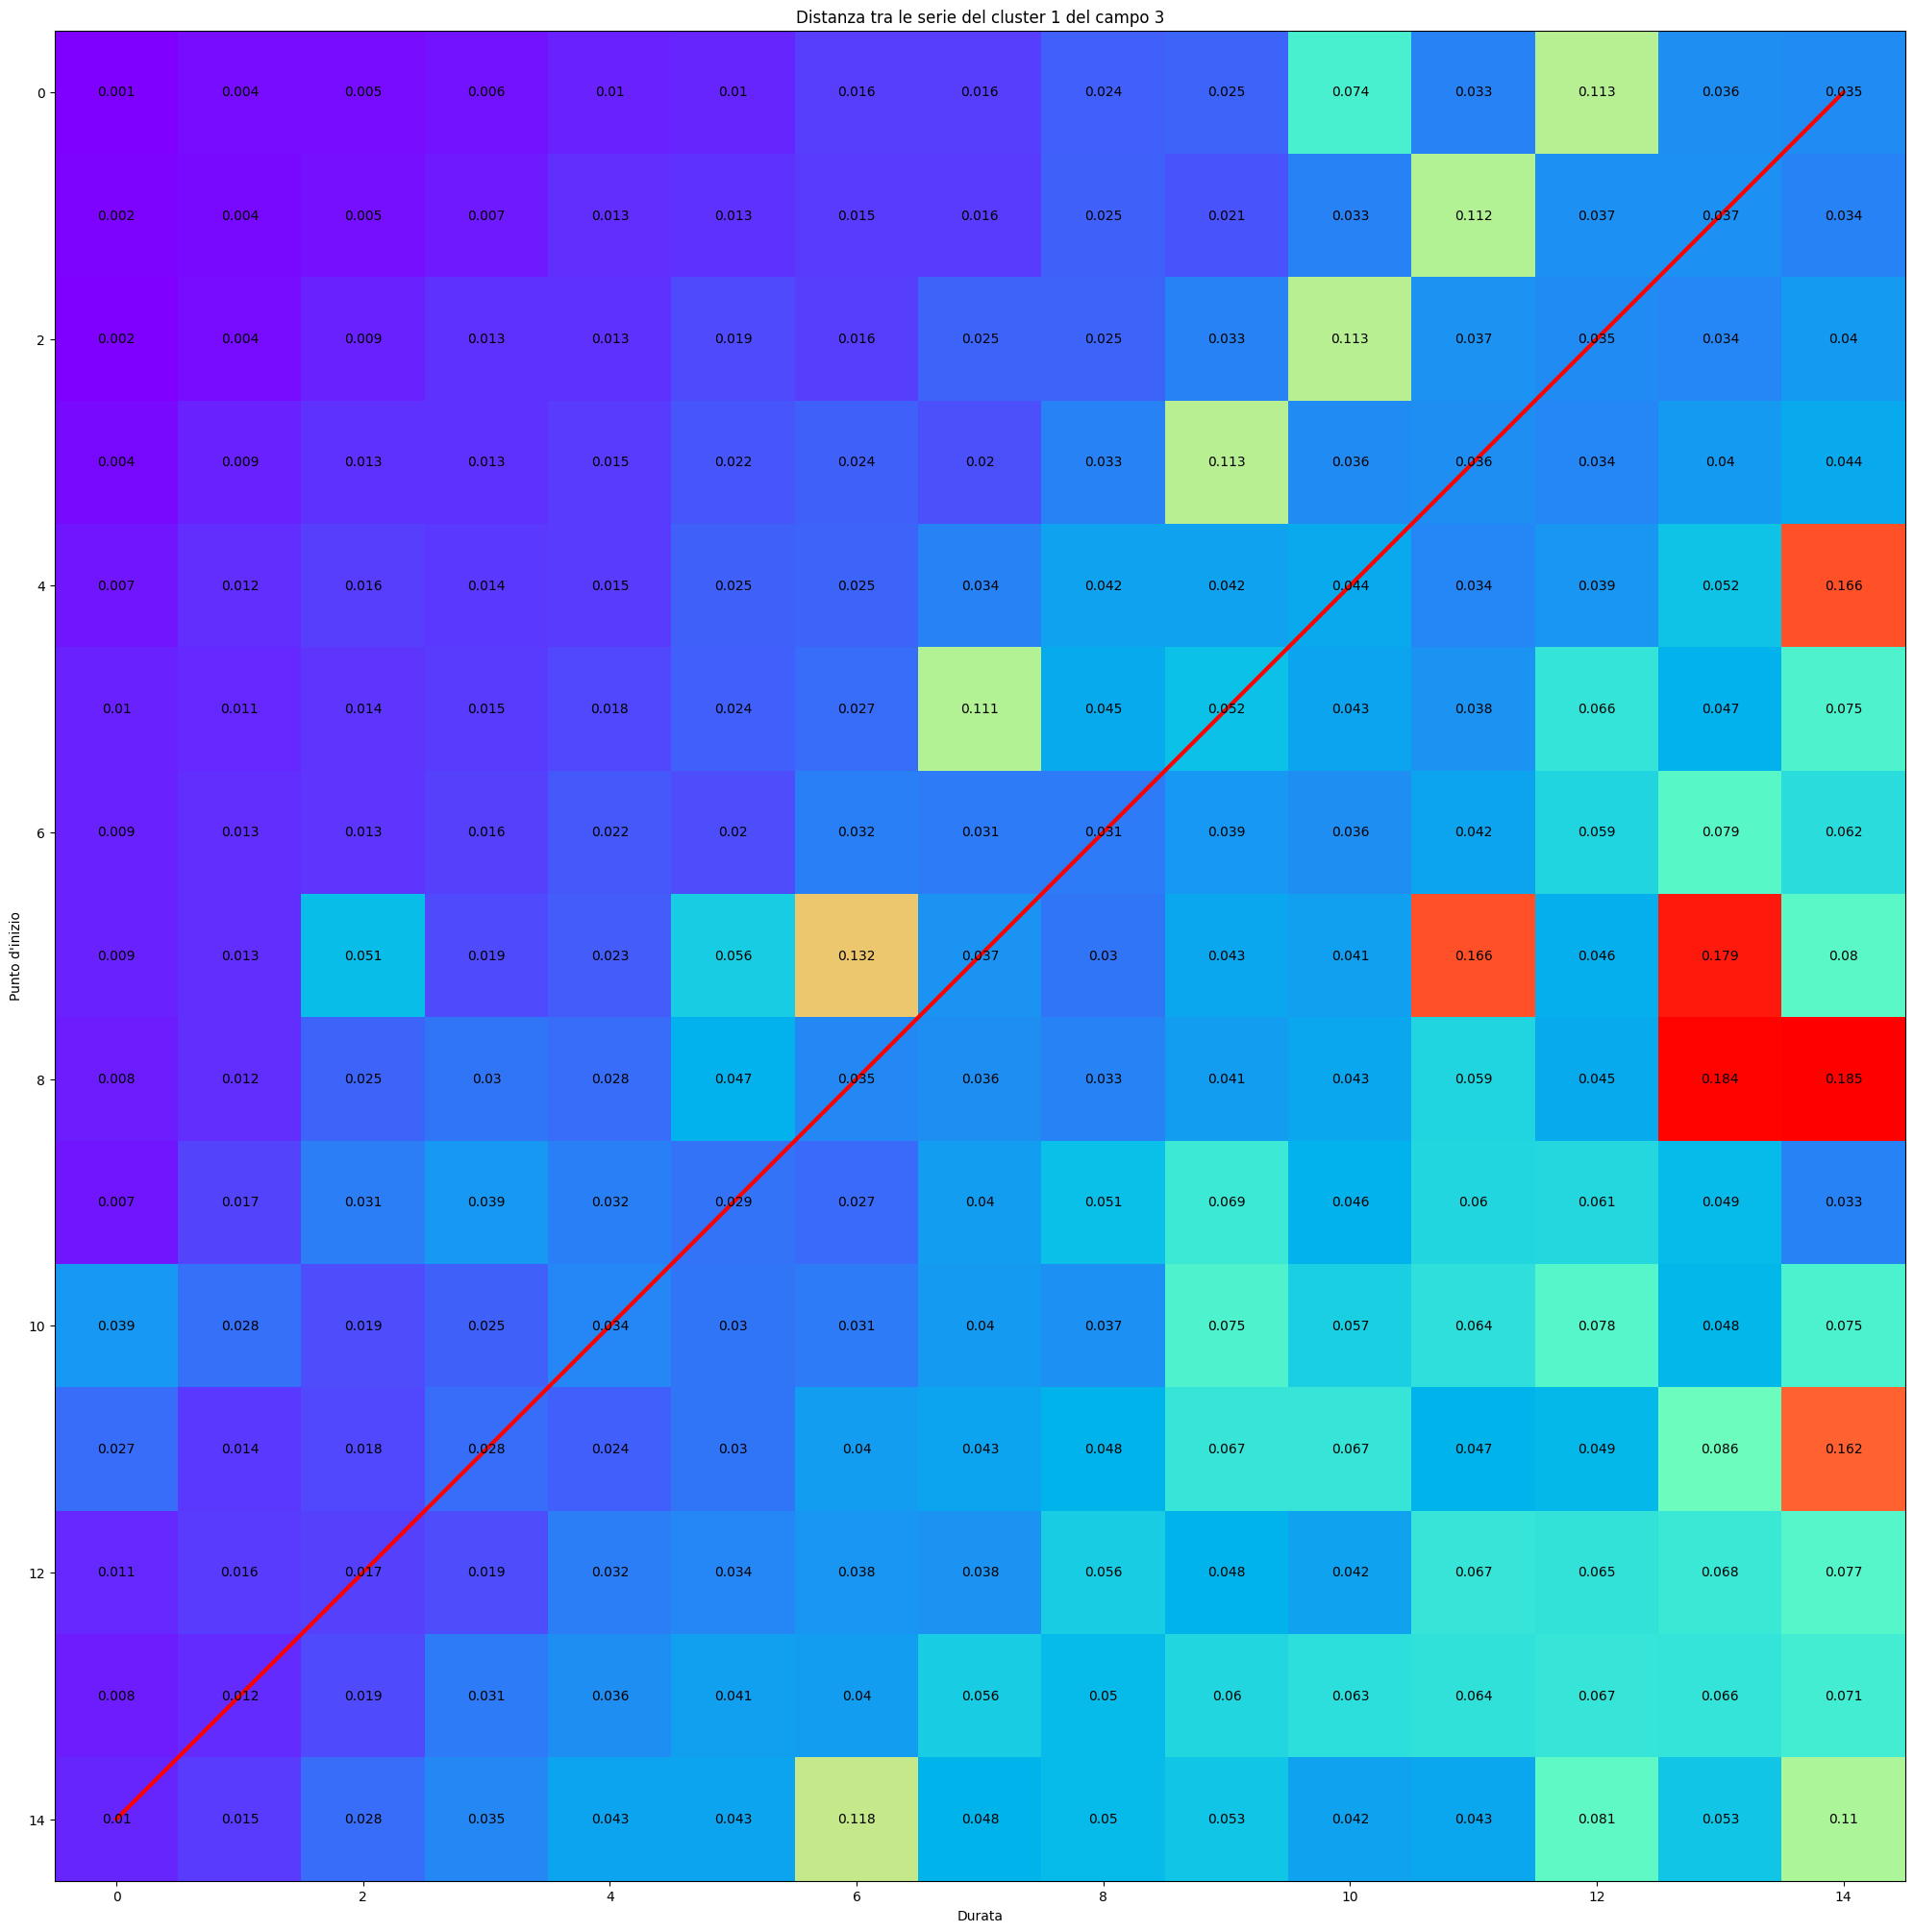

In [41]:
for p in range(0,num_cluster):
    
    fig, ax = plt.subplots()

    image = ax.imshow(coesione_3[:,:,p],cmap='rainbow')


    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")
    plt.title('Distanza tra le serie del cluster '+str(p)+' del campo 3')
    line_start = [0, np.floor(71/5)]
    line_end = [np.floor(71/5), 0]
    plt.plot(line_start, line_end, color="red", linewidth=3)

    fig.set_size_inches(25,25)
    for i in range(0,coesione_3.shape[0]):
        for j in range(0,coesione_3.shape[1]):
            c = np.round(coesione_3[i,j,p],decimals=3)
            ax.text(j, i, str(c), va='center', ha='center')
            #ax.text(j,(i+0.25),str(number_elements_3[i,j,p]),va='center', ha='center')

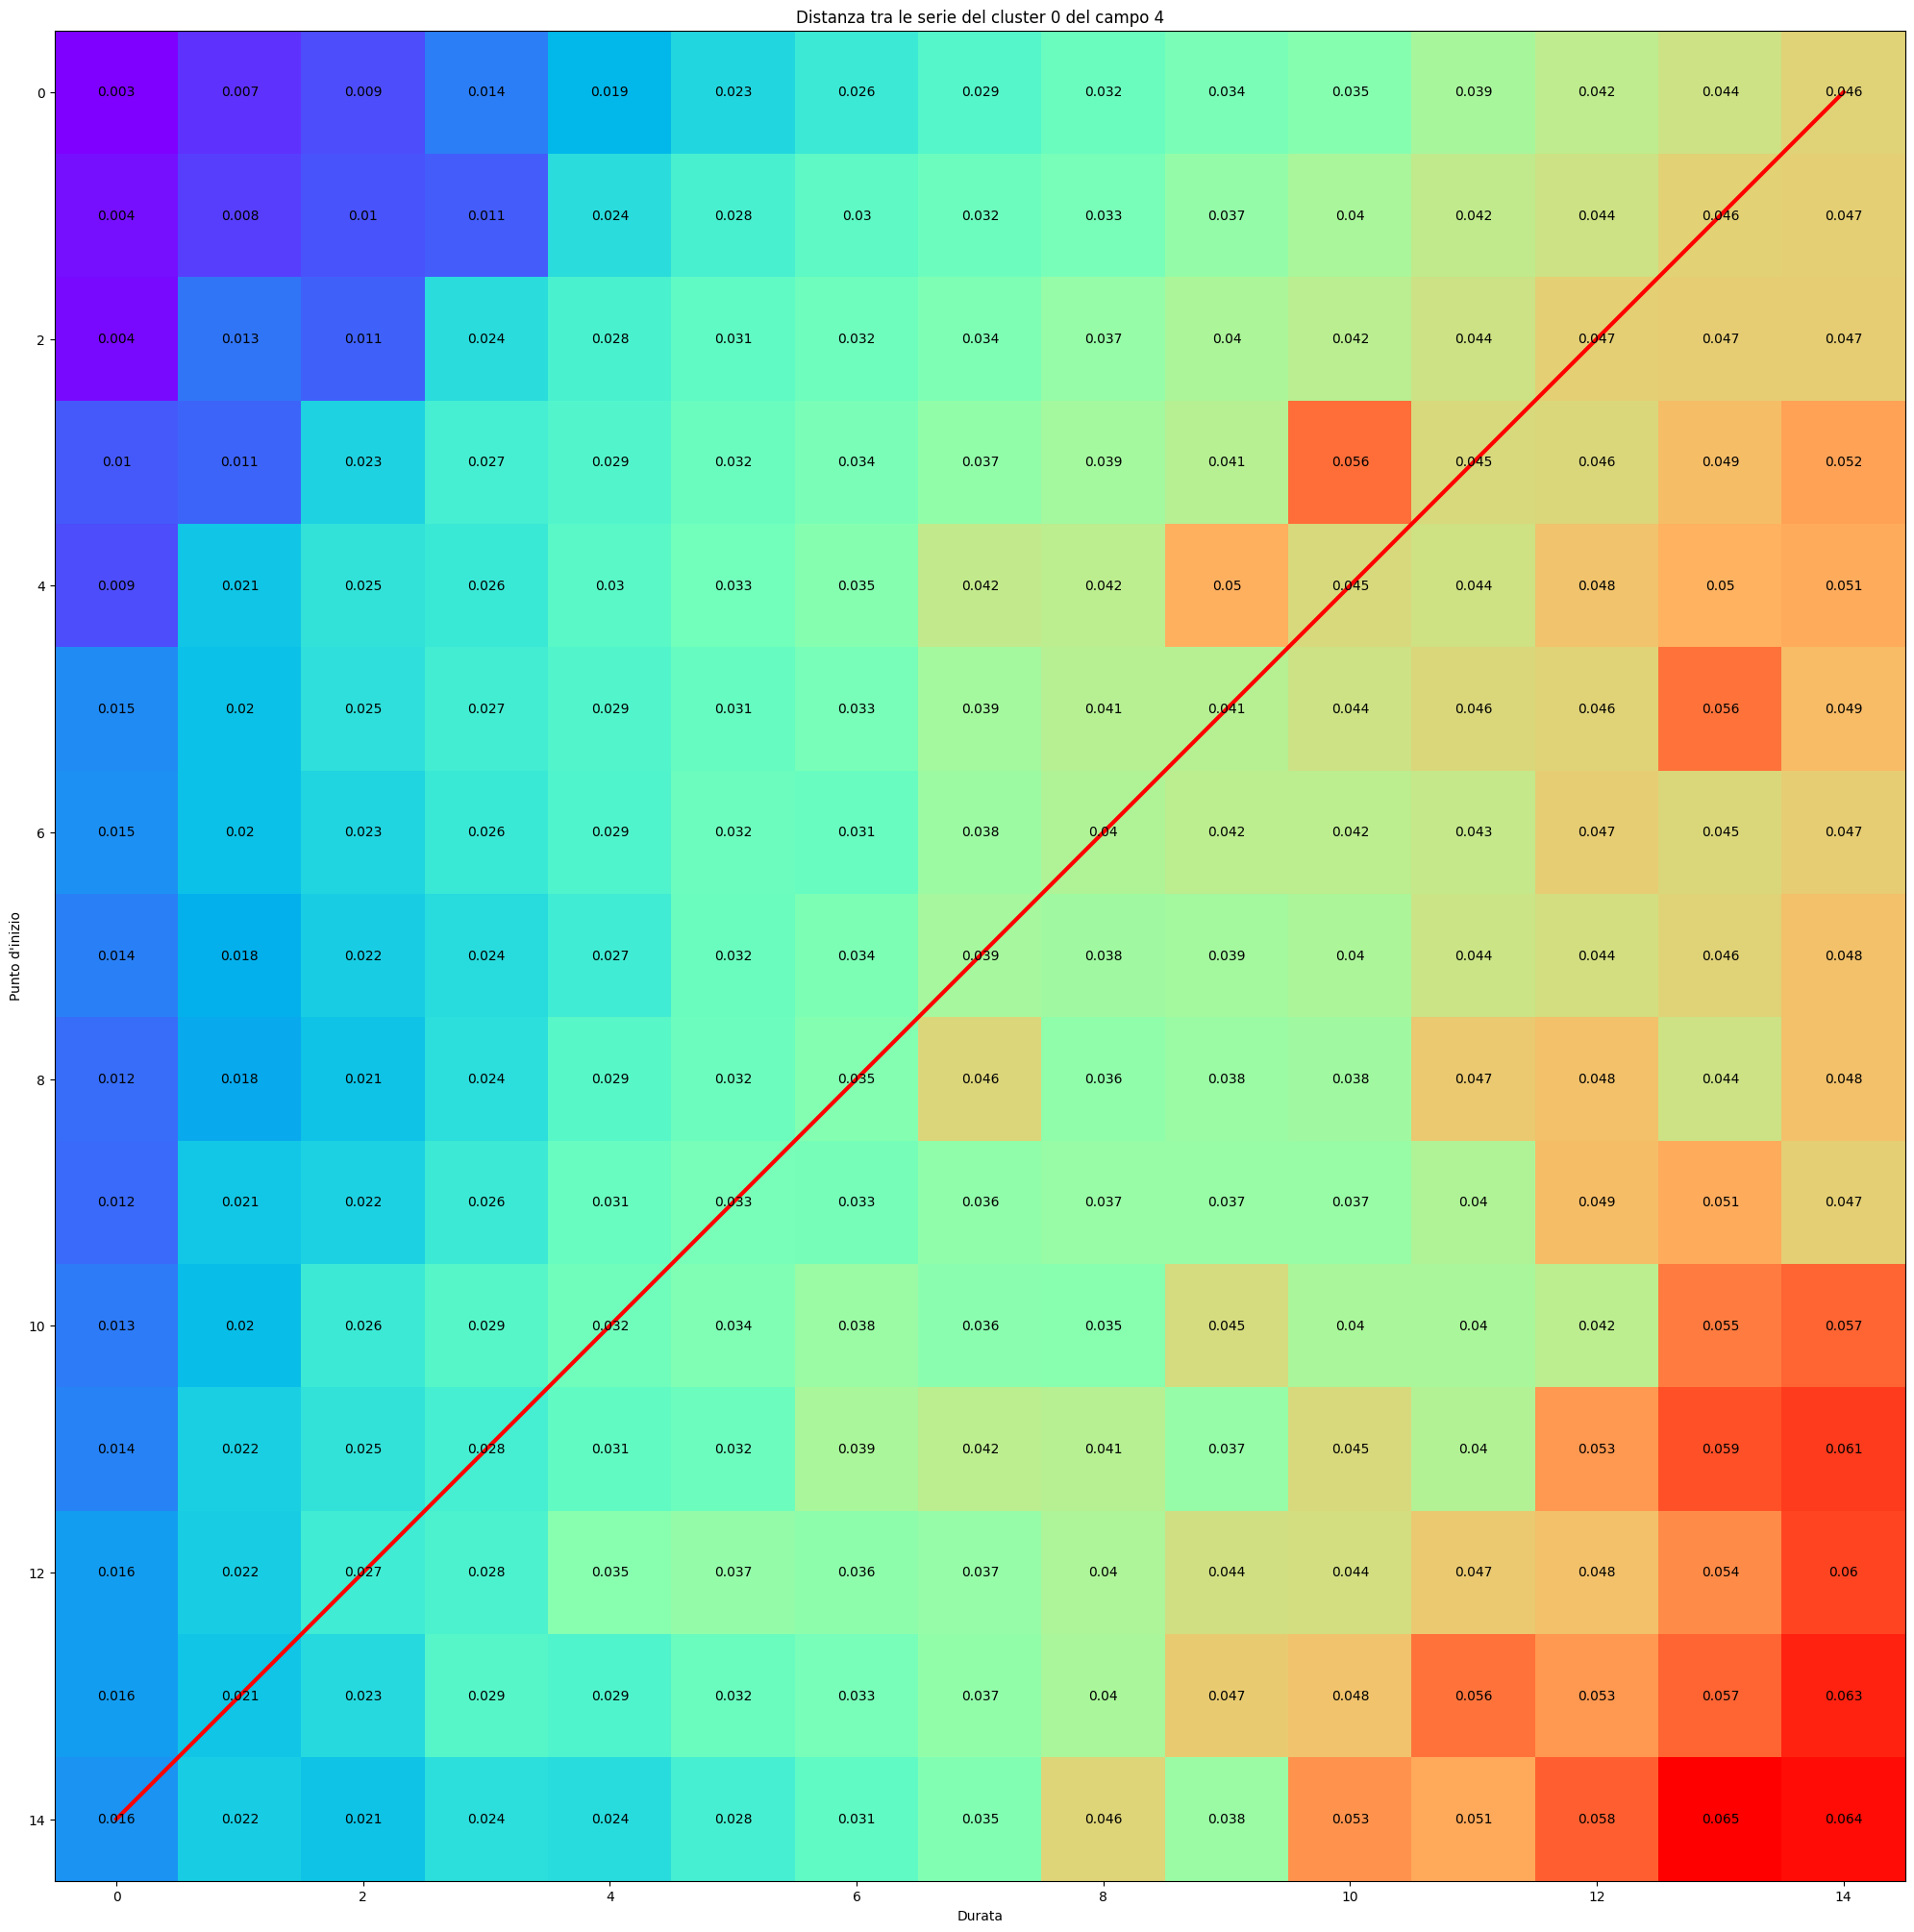

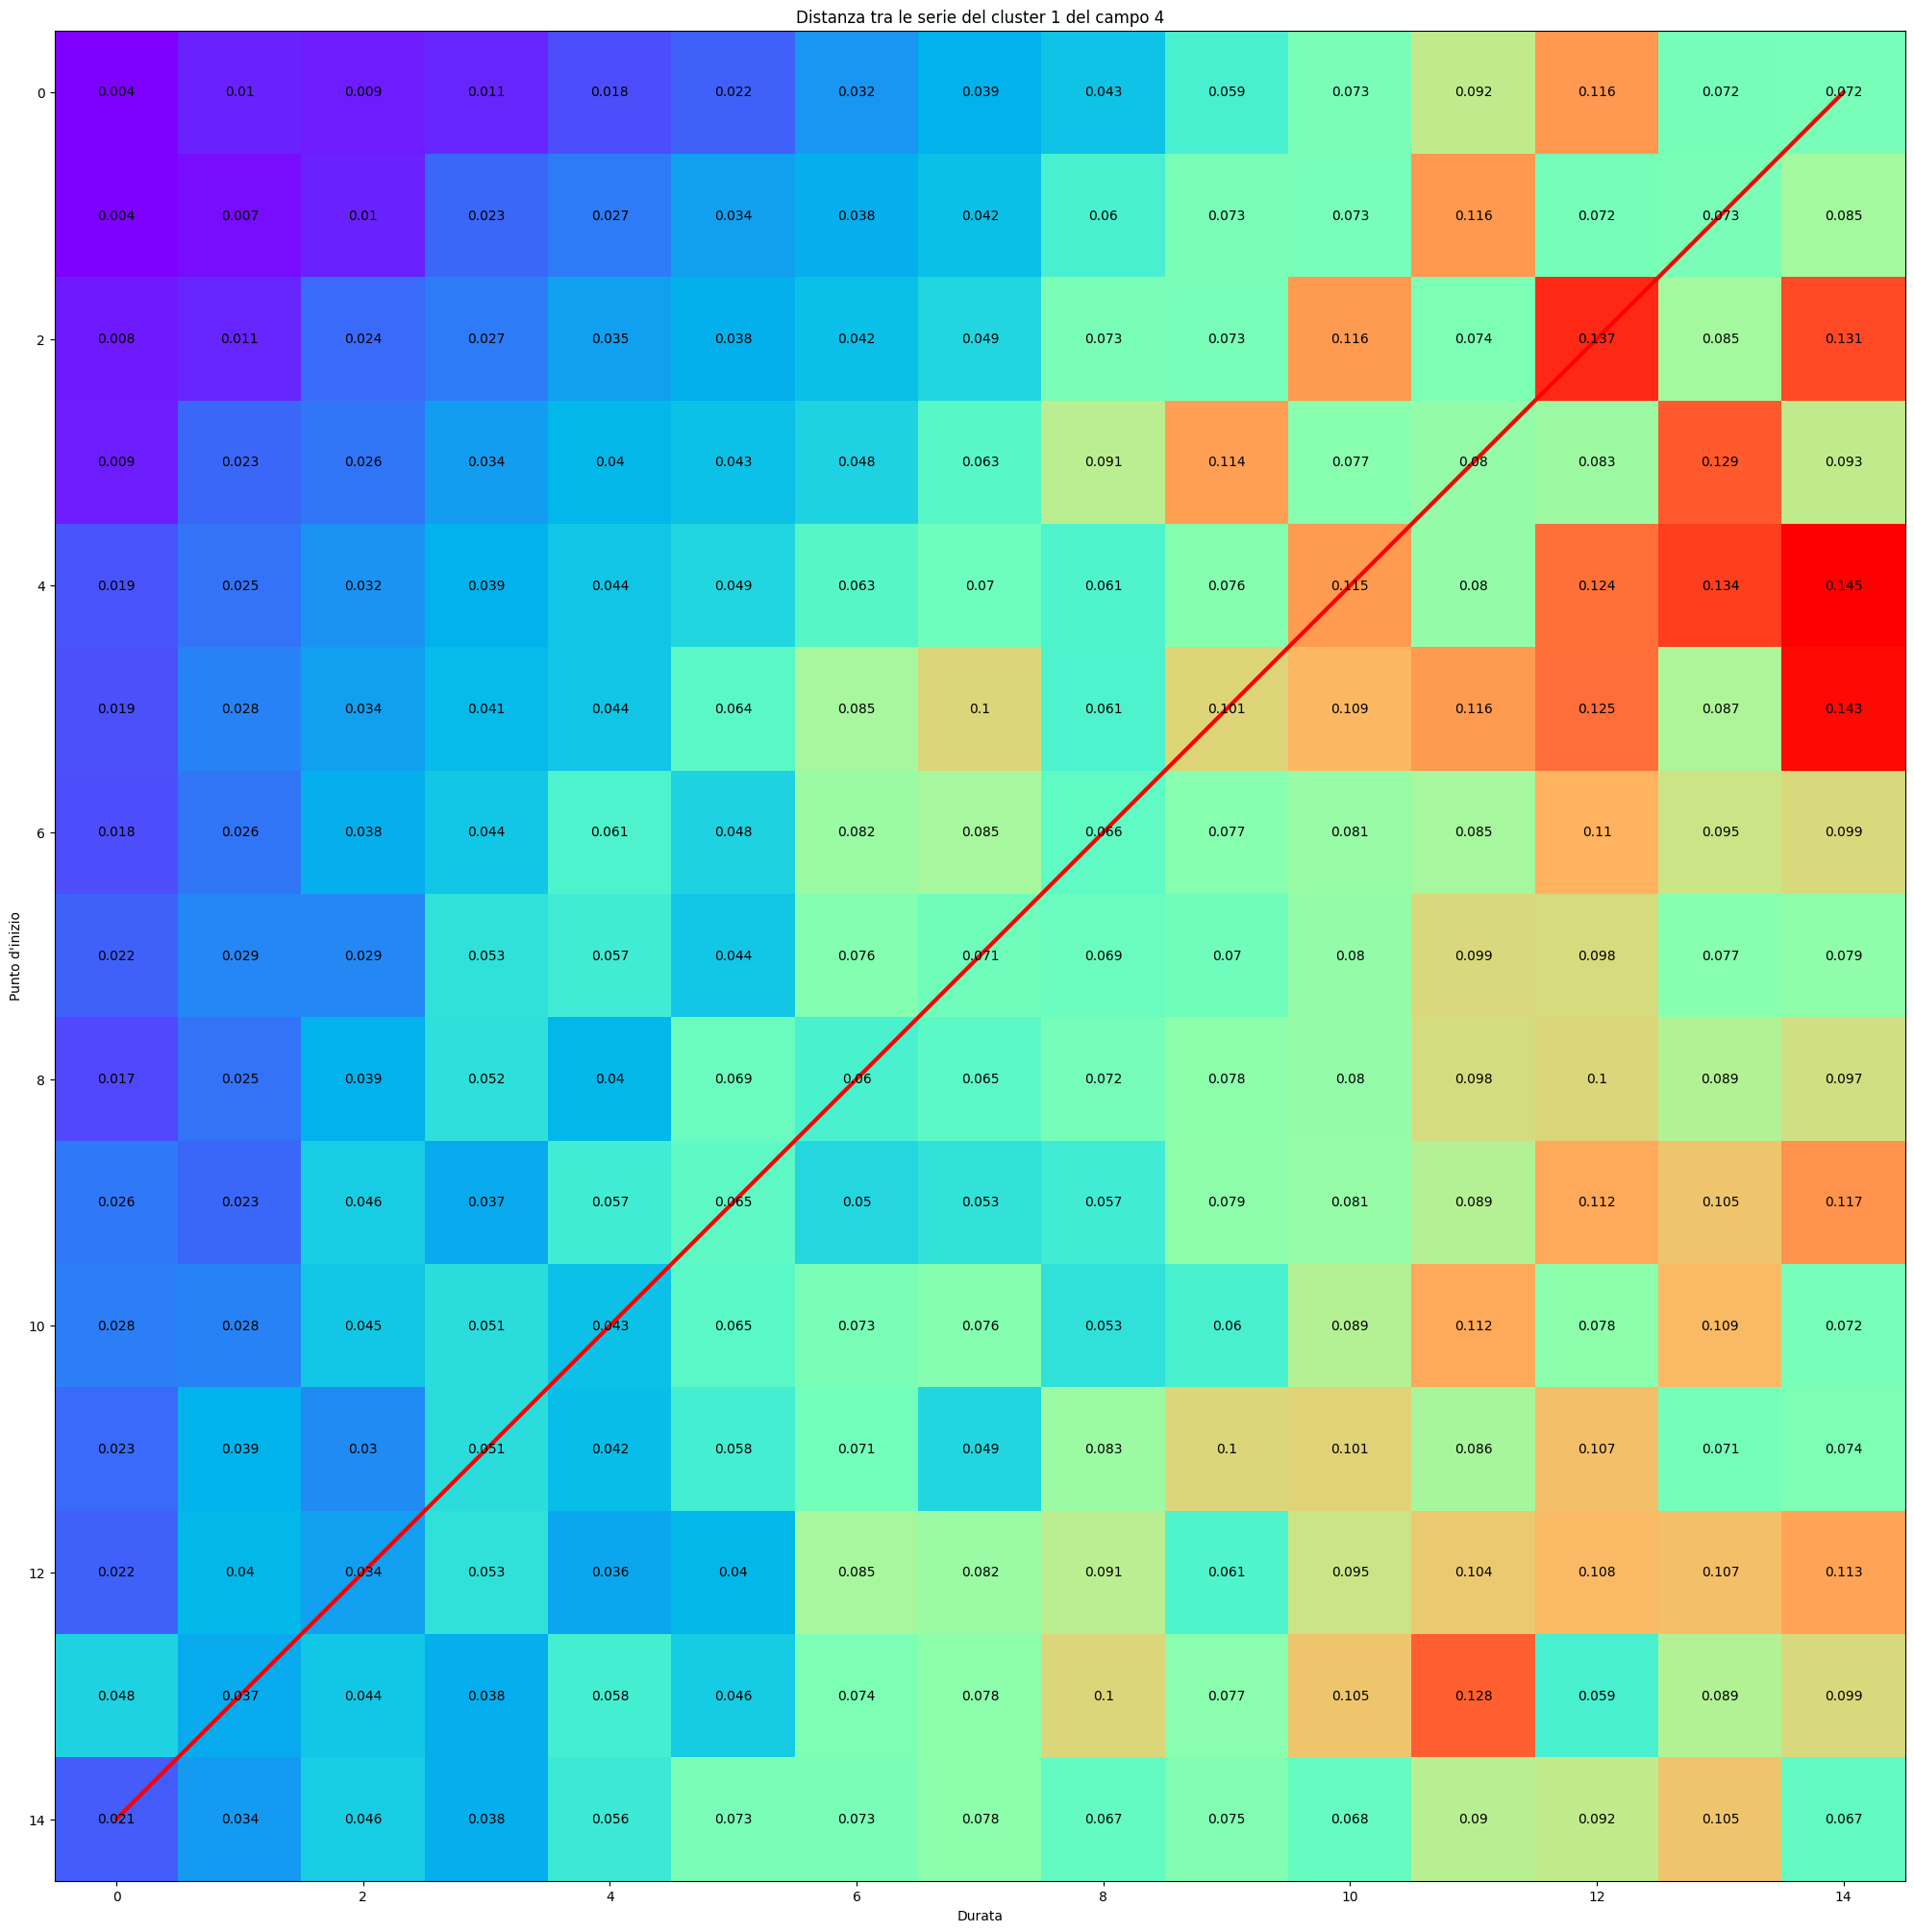

In [42]:
for p in range(0,num_cluster):
    
    fig, ax = plt.subplots()

    image = ax.imshow(coesione_4[:,:,p],cmap='rainbow')


    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")
    plt.title('Distanza tra le serie del cluster '+str(p)+' del campo 4')
    line_start = [0, np.floor(71/5)]
    line_end = [np.floor(71/5), 0]
    plt.plot(line_start, line_end, color="red", linewidth=3)

    fig.set_size_inches(25,25)
    for i in range(0,coesione_4.shape[0]):
        for j in range(0,coesione_4.shape[1]):
            c = np.round(coesione_4[i,j,p],decimals=3)
            ax.text(j, i, str(c), va='center', ha='center')
            #ax.text(j,(i+0.25),str(number_elements_3[i,j,p]),va='center', ha='center')

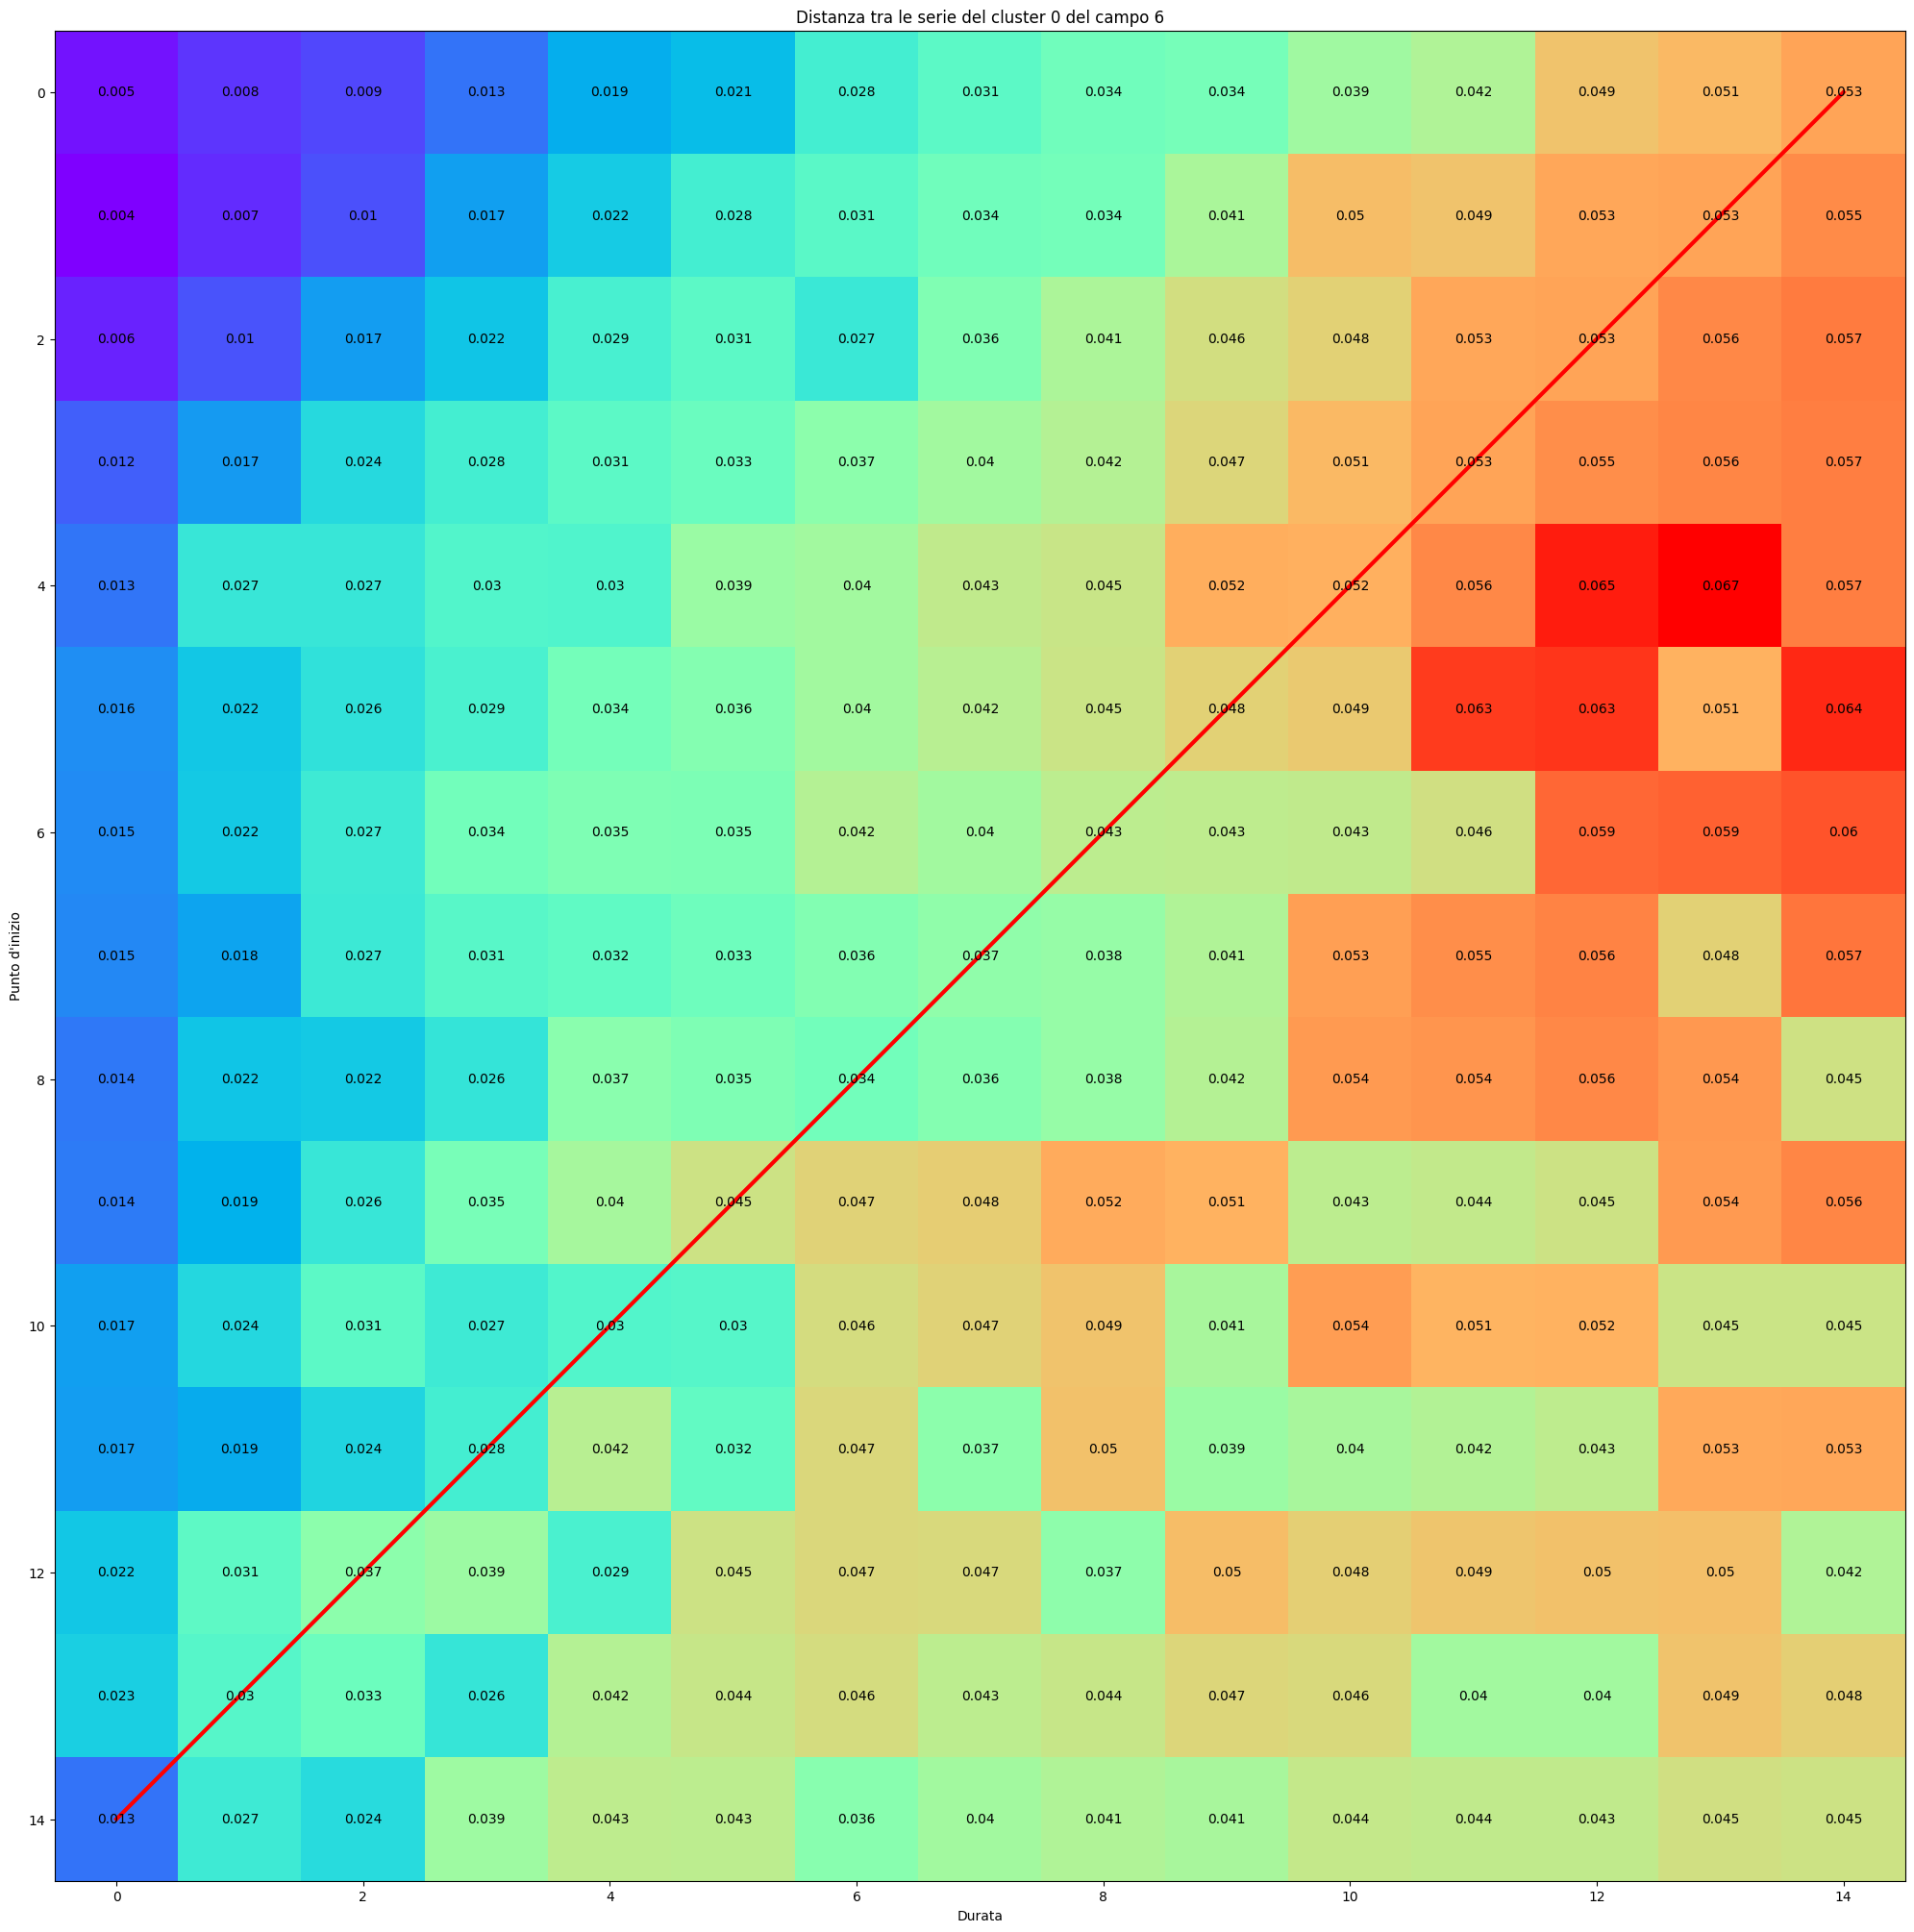

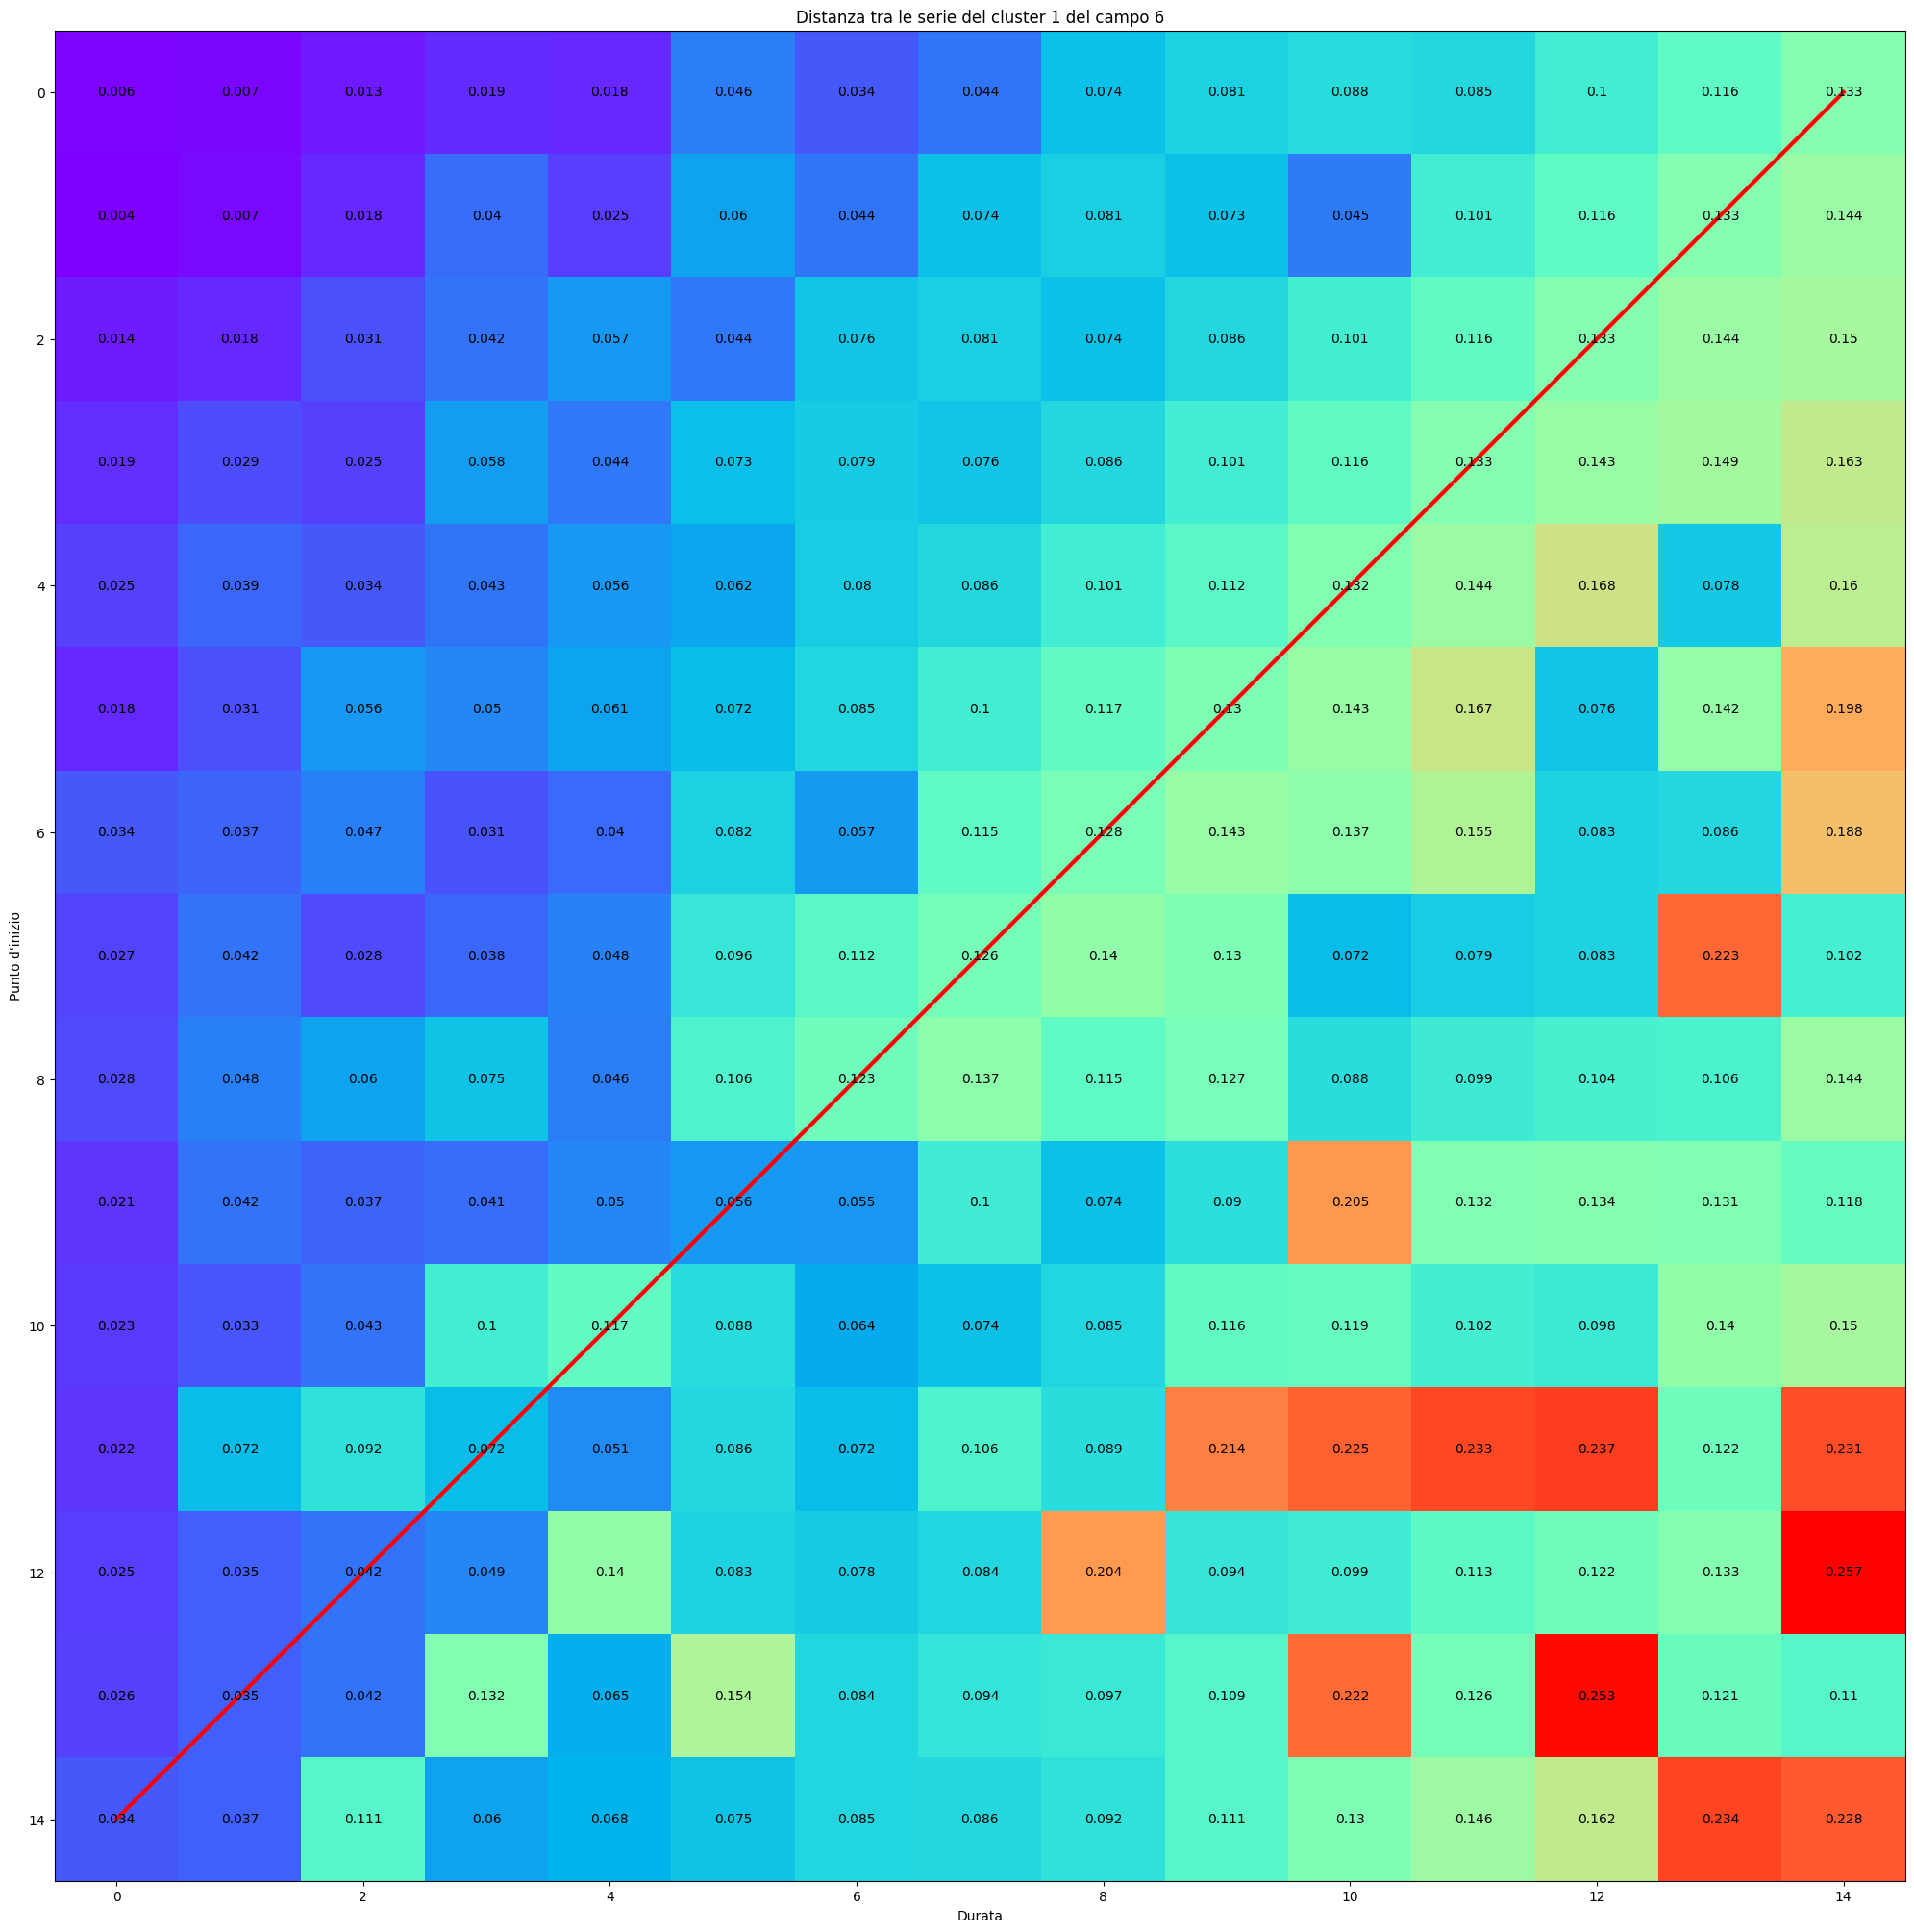

In [43]:
for p in range(0,num_cluster):
    
    fig, ax = plt.subplots()

    image = ax.imshow(coesione_6[:,:,p],cmap='rainbow')


    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")
    plt.title('Distanza tra le serie del cluster '+str(p)+' del campo 6')
    line_start = [0, np.floor(71/5)]
    line_end = [np.floor(71/5), 0]
    plt.plot(line_start, line_end, color="red", linewidth=3)

    fig.set_size_inches(25,25)
    for i in range(0,coesione_6.shape[0]):
        for j in range(0,coesione_6.shape[1]):
            c = np.round(coesione_6[i,j,p],decimals=3)
            ax.text(j, i, str(c), va='center', ha='center')
            #ax.text(j,(i+0.25),str(number_elements_3[i,j,p]),va='center', ha='center')

# Andiamo a rappresentare i valori di separazione dentro delle matrici